In [68]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl  # 新增用于字体控制

def plot_fig(slope, vmax, vmin, cmap, label, save_path, stretch_ratio=1.0):
    """
    绘制地图并保存为矢量图（解决AI字体问题 + 控制拉伸）
    
    参数:
        stretch_ratio: 高度拉伸比例（默认1.0不拉伸，>1.0增加高度）
    """
    # 1. 设置图像尺寸（Nature单栏宽度8.7cm，高度按需拉伸）
    fig_width_cm = 8.7
    fig_height_cm = fig_width_cm * 0.5 * stretch_ratio  # 高度动态调整
    fig = plt.figure(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))
    
    # 2. 字体设置（确保AI可识别）
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    mpl.rcParams['pdf.fonttype'] = 42  # 关键！使文本在AI中可编辑
    mpl.rcParams['ps.fonttype'] = 42   # EPS格式同样生效

    # 3. 地图投影和范围
    # ax = plt.axes(projection=ccrs.PlateCarree())
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-120, 160, -60, 65], crs=ccrs.PlateCarree())

    # 4. 地图要素（精细线条）
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.spines['geo'].set_visible(False)

    # 5. 绘制数据（保持矢量）
    im = slope.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        # aspect=1
        add_colorbar=False,
        rasterized=False  # 确保矢量输出
    )
    ax.set_aspect(1.2)
    # 6. 色标栏（动态调整位置）
    cbar_height = 0.03 / stretch_ratio  # 拉伸时减少色标高度
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, cbar_height])
    cbar = fig.colorbar(
        im,
        cax=cbar_ax,
        orientation="horizontal",
        extend="both",
        pad=0.05
    )
    cbar.set_label(label, fontsize=9, labelpad=2)  # 统一减小字号
    cbar.ax.tick_params(labelsize=8)

    # 7. 保存为PDF/EPS（解决AI兼容性）
    output_path = save_path.replace('.svg', '.pdf')  # 优先用PDF
    plt.savefig(
        output_path,
        format='pdf',  # PDF在AI中兼容性更好
        bbox_inches='tight',
        dpi=300,
        metadata={'CreationDate': None}  # 避免时间戳导致哈希变化
    )
    plt.show()
    plt.close()



In [69]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_trend(slope, p,vmax,vmin,cmap, title, save_path):
   
    # Set up figure and projection
    fig_width_cm = 8.7
    fig_height_cm = fig_width_cm * 0.5  # 高度按比例调整
    fig = plt.figure(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))
    mpl.rcParams['pdf.fonttype'] = 42
    # 2. 字体设置（Nature 推荐使用无衬线字体，如 Arial）
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8  # 基础字号为 8pt

    # 3. 地图投影和范围
    # ax = plt.axes(projection=ccrs.PlateCarree())
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-120, 160, -60, 65], crs=ccrs.PlateCarree())

    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.spines['geo'].set_visible(False)  # 移除边框
    
    # Plot trend data
    im = slope.plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap=cmap, robust=True,vmax=vmax,vmin=vmin,
                   add_colorbar=False)
    
    # Add significance hatching
    sig = (p < 0.05) & (~np.isnan(slope))
    ax.contourf(sig.lon, sig.lat, sig, 
                colors='none', hatches=['////'], 
                levels=[0.5, 1.5], transform=ccrs.PlateCarree(),
                alpha=0)  # Makes the hatching more visible
    
    # Custom colorbar
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                       extend='both', pad=0.1)
    cbar.set_label('Correlation (%)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Gridlines and frame
    gl = ax.gridlines(draw_labels=False)
    gl.xlines = False
    gl.ylines = False
    # gl.xlabel_style = {'size': 10}
    # gl.ylabel_style = {'size': 10}
    # plt.title(title)
    # Remove frame
    ax.spines['geo'].set_visible(False)
    output_path = save_path.replace('.svg', '.eps')  # 替换为 .eps 扩展名
    plt.savefig(
        output_path,
        format='pdf',  # 指定输出 EPS 格式
        bbox_inches='tight',  # 紧凑布局
        dpi=300,  # 虽然 EPS 是矢量，但某些元素可能受 DPI 影响
    )
    # plt.tight_layout()
    plt.show()

In [16]:
import xarray as xr
from os.path import join
import pandas as pd
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict3 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}
def cftime360day_to_datetimeindex(cftime_times):
    # 转成字符串后转换为 pandas datetime（强制30天历近似）
    dates_str = [f"{t.year}-{t.month:02d}-{t.day:02d}" for t in cftime_times]
    return pd.to_datetime(dates_str)



for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\resu'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    season_wwh=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\wwh_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
                    season_swh=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\swh_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
                    
                    ssi_data_wwh = xr.open_dataset(join(fp, f'soilmoist_wwh_{ssp}_median.nc'))['soilmoist-wwh-noirr']
                    ssi_data_swh = xr.open_dataset(join(fp, f'soilmoist_swh_{ssp}_median.nc'))['soilmoist-swh-noirr']
                    ssi_data_swh['time'] = season_swh.time.values;ssi_data_wwh['time'] = season_wwh.time.values
                    ssi_data_wwh=ssi_data_wwh.where(season_wwh);ssi_data_swh=ssi_data_swh.where(season_swh)

                    ssi_data_wwh = ssi_data_wwh.groupby('time.year').mean('time')[:-1,:,:].rename({'year': 'time'})
                    ssi_data_swh = ssi_data_swh.groupby('time.year').mean('time')[:-1,:,:].rename({'year': 'time'})


                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    result_dict3[ssp][crop]['sm'] =ssi.where(area>0)

                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\resu'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
                    ssi_data = xr.open_dataset(join(fp, f'soilmoist_{crop}_{ssp}_median.nc'))[f'soilmoist-{crop}-noirr']
                    ssi_data['time'] = season.time.values
                    ssi_data=ssi_data.where(season)
                    
                    ssi_data = ssi_data.groupby('time.year').mean('time')[:-1,:,:].rename({'year': 'time'})

                    result_dict3[ssp][crop]['sm'] =ssi_data.where(area>0)

                except FileNotFoundError:
                    print(f"Warning: 缺少{crop}数据文件 for {var}-{ssp}")
                    continue


In [33]:
import xarray as xr
from os.path import join

# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict1 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}

exp='default'
# exp='2015co2'
for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr']
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr']
                    pirnreqcum_wwh= xr.open_dataset(join(fp, f'pirnreqcum_wwh_{ssp}_median_{exp}.nc'))[f'pirnreqcum-wwh-firr']
                    pirnreqcum_swh= xr.open_dataset(join(fp, f'pirnreqcum_swh_{ssp}_median_{exp}.nc'))[f'pirnreqcum-swh-firr']
                    evapcum_wwh= xr.open_dataset(join(fp, f'evapcum_wwh_{ssp}_median_{exp}.nc'))[f'evapcum-wwh-noirr']
                    evapcum_swh= xr.open_dataset(join(fp, f'evapcum_swh_{ssp}_median_{exp}.nc'))[f'evapcum-swh-noirr']
                    matyday_wwh= xr.open_dataset(join(fp, f'matyday_wwh_{ssp}_median_{exp}.nc'))[f'matyday-wwh-noirr']
                    matyday_swh= xr.open_dataset(join(fp, f'matyday_swh_{ssp}_median_{exp}.nc'))[f'matyday-swh-noirr']
                    
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    matyday=matyday_wwh.where(area_wwh>0).fillna(0)+matyday_swh.where(area_swh>0).fillna(0)
                    evapcum=evapcum_wwh.where(area_wwh>0).fillna(0)+evapcum_swh.where(area_swh>0).fillna(0)
                    pirnreqcum=pirnreqcum_wwh.where(area_wwh>0).fillna(0)+pirnreqcum_swh.where(area_swh>0).fillna(0)
                    result_dict1[ssp][crop]['yield'] =yied.where(area>0)
                    result_dict1[ssp][crop]['evapcum'] = evapcum.where(area>0)
                    result_dict1[ssp][crop]['pirnreqcum'] = pirnreqcum.where(area>0)
                    result_dict1[ssp][crop]['matyday'] = matyday.where(area>0)

            else:
                # try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

                    yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr']
                    pirnreqcum= xr.open_dataset(join(fp, f'pirnreqcum_{crop}_{ssp}_median_{exp}.nc'))[f'pirnreqcum-{crop}-firr']
                    evapcum= xr.open_dataset(join(fp, f'evapcum_{crop}_{ssp}_median_{exp}.nc'))[f'evapcum-{crop}-noirr']
                    matyday= xr.open_dataset(join(fp, f'matyday_{crop}_{ssp}_median_{exp}.nc'))[f'matyday-{crop}-noirr']
                    result_dict1[ssp][crop]['matyday'] =matyday.where(area>0)
                    result_dict1[ssp][crop]['yield'] =yied.where(area>0)
                    result_dict1[ssp][crop]['evapcum'] = evapcum.where(area>0)
                    result_dict1[ssp][crop]['pirnreqcum'] = pirnreqcum.where(area>0)

In [32]:
import xarray as xr
from os.path import join

# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}

# exp='default'
exp='2015co2'
for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr']
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr']
                    pirnreqcum_wwh= xr.open_dataset(join(fp, f'pirnreqcum_wwh_{ssp}_median_{exp}.nc'))[f'pirnreqcum-wwh-firr']
                    pirnreqcum_swh= xr.open_dataset(join(fp, f'pirnreqcum_swh_{ssp}_median_{exp}.nc'))[f'pirnreqcum-swh-firr']
                    evapcum_wwh= xr.open_dataset(join(fp, f'evapcum_wwh_{ssp}_median_{exp}.nc'))[f'evapcum-wwh-noirr']
                    evapcum_swh= xr.open_dataset(join(fp, f'evapcum_swh_{ssp}_median_{exp}.nc'))[f'evapcum-swh-noirr']
                    matyday_wwh= xr.open_dataset(join(fp, f'matyday_wwh_{ssp}_median_{exp}.nc'))[f'matyday-wwh-noirr']
                    matyday_swh= xr.open_dataset(join(fp, f'matyday_swh_{ssp}_median_{exp}.nc'))[f'matyday-swh-noirr']
                    
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    matyday=matyday_wwh.where(area_wwh>0).fillna(0)+matyday_swh.where(area_swh>0).fillna(0)
                    evapcum=evapcum_wwh.where(area_wwh>0).fillna(0)+evapcum_swh.where(area_swh>0).fillna(0)
                    pirnreqcum=pirnreqcum_wwh.where(area_wwh>0).fillna(0)+pirnreqcum_swh.where(area_swh>0).fillna(0)
                    result_dict2[ssp][crop]['yield'] =yied.where(area>0)
                    result_dict2[ssp][crop]['evapcum'] = evapcum.where(area>0)
                    result_dict2[ssp][crop]['pirnreqcum'] = pirnreqcum.where(area>0)
                    result_dict2[ssp][crop]['matyday'] = matyday.where(area>0)

            else:
                # try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

                    yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr']
                    pirnreqcum= xr.open_dataset(join(fp, f'pirnreqcum_{crop}_{ssp}_median_{exp}.nc'))[f'pirnreqcum-{crop}-firr']
                    evapcum= xr.open_dataset(join(fp, f'evapcum_{crop}_{ssp}_median_{exp}.nc'))[f'evapcum-{crop}-noirr']
                    matyday= xr.open_dataset(join(fp, f'matyday_{crop}_{ssp}_median_{exp}.nc'))[f'matyday-{crop}-noirr']
                    result_dict2[ssp][crop]['matyday'] =matyday.where(area>0)
                    result_dict2[ssp][crop]['yield'] =yied.where(area>0)
                    result_dict2[ssp][crop]['evapcum'] = evapcum.where(area>0)
                    result_dict2[ssp][crop]['pirnreqcum'] = pirnreqcum.where(area>0)

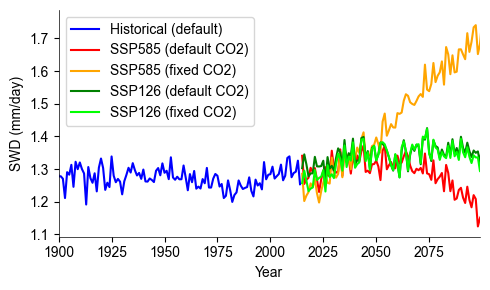

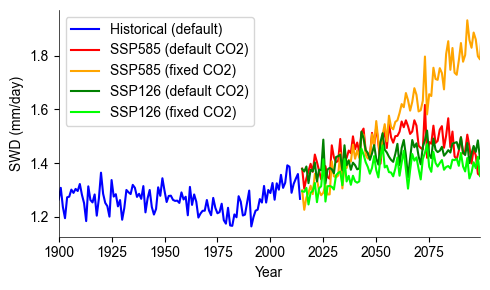

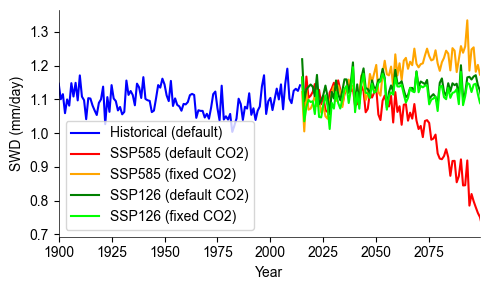

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl

# 时间范围
years_hist = np.arange(1850, 2015)
years_future = np.arange(2015, 2101)

# 作物列表
crops = ['mai', 'soy', 'whe']

for crop in crops:
    # 提取历史和未来场景的数据（单位换算为 mm/day）
    hist = result_dict1['historical'][crop]['pirnreqcum'] / result_dict1['historical'][crop]['matyday']
    
    future_default_585 = result_dict1['ssp585'][crop]['pirnreqcum'] / result_dict1['ssp585'][crop]['matyday']
    future_fixedco2_585 = result_dict2['ssp585'][crop]['pirnreqcum'] / result_dict2['ssp585'][crop]['matyday']
    
    future_default_126 = result_dict1['ssp126'][crop]['pirnreqcum'] / result_dict1['ssp126'][crop]['matyday']
    future_fixedco2_126 = result_dict2['ssp126'][crop]['pirnreqcum'] / result_dict2['ssp126'][crop]['matyday']

    # 空间中值（忽略 NaN）
    hist_mean = hist.median(dim=['lat', 'lon'], skipna=True)
    default_585_mean = future_default_585.median(dim=['lat', 'lon'], skipna=True)
    fixedco2_585_mean = future_fixedco2_585.median(dim=['lat', 'lon'], skipna=True)
    
    default_126_mean = future_default_126.median(dim=['lat', 'lon'], skipna=True)
    fixedco2_126_mean = future_fixedco2_126.median(dim=['lat', 'lon'], skipna=True)

    # 绘图
    plt.figure(figsize=(5, 3))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    
    plt.plot(years_hist, hist_mean, label='Historical (default)', color='blue')
    plt.plot(years_future, default_585_mean, label='SSP585 (default CO2)', color='red')
    plt.plot(years_future, fixedco2_585_mean, label='SSP585 (fixed CO2)', color='orange')
    plt.plot(years_future, default_126_mean, label='SSP126 (default CO2)', color='green')
    plt.plot(years_future, fixedco2_126_mean, label='SSP126 (fixed CO2)', color='lime')

    plt.xlim(1900, 2099)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    plt.xlabel('Year')
    plt.ylabel('SWD (mm/day)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import join
from tqdm.notebook import tqdm

# === 参数设置 ===
crops = ['mai', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']
base_path = Path(r'E:\isimip3b_agricultal')
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)

for exp in ['default', '2015co2']:
    for crop in crops:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

        for ssp in ssps:
            print(f"\nProcessing: {crop} - {ssp}")
            if ssp == 'historical':
                years = np.arange(1850, 2015)
            else:
                years = np.arange(2015, 2101)
            
            pir_files = sorted(list((base_path / 'pirnreqcum').glob(f'*_{ssp}_2015soc_{exp}_pirnreqcum-{crop}-firr_global_annual-gs*.nc')))
            day_files = [join(base_path, 'matyday', str(i).split('\\')[-1].replace(f'pirnreqcum-{crop}-firr', f'matyday-{crop}-noirr')) for i in pir_files]

            all_series = []
            for pir_file, day_file in tqdm(zip(pir_files, day_files), total=len(pir_files)):
                if crop == 'wwh':
                    area_path_wwh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path_wwh)[list(xr.open_dataset(area_path_wwh).data_vars)[0]]
                    area_path_swh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path_swh)[list(xr.open_dataset(area_path_swh).data_vars)[0]]

                    pir_wwh = xr.open_dataset(pir_file, decode_times=False)[f'pirnreqcum-{crop}-firr'].where(area_wwh > 0).fillna(0)
                    pir_swh = xr.open_dataset(str(pir_file).replace('wwh', 'swh'), decode_times=False)[f'pirnreqcum-swh-firr'].where(area_swh > 0).fillna(0)
                    pir = pir_wwh + pir_swh

                    try:
                        maty_wwh = xr.open_dataset(day_file, decode_times=False)[f'matyday-{crop}-noirr'].where(area_wwh > 0).fillna(0)
                        maty_swh = xr.open_dataset(str(day_file).replace('wwh', 'swh'), decode_times=False)[f'matyday-swh-noirr'].where(area_swh > 0).fillna(0)
                        maty = maty_wwh + maty_swh
                    except FileNotFoundError:
                        print(f"缺少文件，跳过: {day_file} 或替代文件")
                        continue
                    except Exception as e:
                        print(f"打开文件错误: {day_file}, 错误信息: {e}")
                        continue
                    
                    maty = maty.where(maty != 0)
                    pir = pir.where(maty != 0)

                else:
                    ds_pir = xr.open_dataset(pir_file, decode_times=False)
                    try:
                        ds_day = xr.open_dataset(day_file, decode_times=False)
                    except FileNotFoundError:
                        print(f"缺少文件，跳过: {day_file}")
                        continue
                    except Exception as e:
                        print(f"打开文件错误: {day_file}, 错误信息: {e}")
                        continue

                    pir = ds_pir[f'pirnreqcum-{crop}-firr'].where(area > 0)
                    maty = ds_day[f'matyday-{crop}-noirr'].where(area > 0)

                swd = pir /maty
                swd=swd.where(~np.isinf(swd), np.nan)
                swd_median = swd.mean(dim=['lat', 'lon'])
                swd_median['time'] = years

                series = swd_median.to_series().reset_index(drop=True)
                all_series.append(series)

            result_df = pd.DataFrame(all_series).T
            result_df.columns = [f'model_{i+1}' for i in range(len(all_series))]
            result_df['year'] = years
            result_df = result_df.set_index('year')

            result_df.to_csv(out_dir / f'swd_{crop}_{ssp}_models_{exp}.csv')



Processing: mai - historical


  0%|          | 0/49 [00:00<?, ?it/s]


Processing: mai - ssp126


  0%|          | 0/49 [00:00<?, ?it/s]


Processing: mai - ssp585


  0%|          | 0/50 [00:00<?, ?it/s]


Processing: wwh - historical


  0%|          | 0/44 [00:00<?, ?it/s]


Processing: wwh - ssp126


  0%|          | 0/44 [00:00<?, ?it/s]


Processing: wwh - ssp585


  0%|          | 0/45 [00:00<?, ?it/s]


Processing: soy - historical


  0%|          | 0/47 [00:00<?, ?it/s]


Processing: soy - ssp126


  0%|          | 0/47 [00:00<?, ?it/s]


Processing: soy - ssp585


  0%|          | 0/47 [00:00<?, ?it/s]


Processing: mai - historical


  0%|          | 0/7 [00:00<?, ?it/s]


Processing: mai - ssp126


  0%|          | 0/47 [00:00<?, ?it/s]


Processing: mai - ssp585


  0%|          | 0/48 [00:00<?, ?it/s]

缺少文件，跳过: E:\isimip3b_agricultal\matyday\dssat-pythia_mri-esm2-0_w5e5_ssp585_2015soc_2015co2_matyday-mai-noirr_global_annual-gs_2015_2100.nc

Processing: wwh - historical


  0%|          | 0/2 [00:00<?, ?it/s]


Processing: wwh - ssp126


  0%|          | 0/42 [00:00<?, ?it/s]


Processing: wwh - ssp585


  0%|          | 0/43 [00:00<?, ?it/s]

缺少文件，跳过: E:\isimip3b_agricultal\matyday\dssat-pythia_mri-esm2-0_w5e5_ssp585_2015soc_2015co2_matyday-wwh-noirr_global_annual-gs_2015_2100.nc 或替代文件

Processing: soy - historical


  0%|          | 0/5 [00:00<?, ?it/s]


Processing: soy - ssp126


  0%|          | 0/45 [00:00<?, ?it/s]


Processing: soy - ssp585


  0%|          | 0/45 [00:00<?, ?it/s]

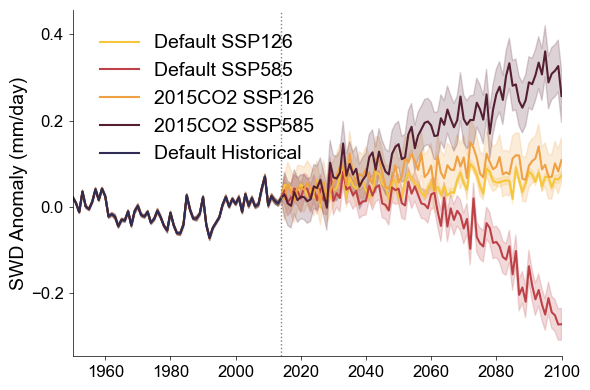

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import matplotlib.ticker as mticker
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
crop = 'mai'

# 读取数据
default_hist = pd.read_csv(out_dir / f'swd_{crop}_historical_models_default.csv', index_col='year')
co2_hist = pd.read_csv(out_dir / f'swd_{crop}_historical_models_2015co2.csv', index_col='year')
default_ssp126 = pd.read_csv(out_dir / f'swd_{crop}_ssp126_models_default.csv', index_col='year')
default_ssp585 = pd.read_csv(out_dir / f'swd_{crop}_ssp585_models_default.csv', index_col='year')
co2_ssp126 = pd.read_csv(out_dir / f'swd_{crop}_ssp126_models_2015co2.csv', index_col='year')
co2_ssp585 = pd.read_csv(out_dir / f'swd_{crop}_ssp585_models_2015co2.csv', index_col='year')

# 合并default的历史 + 未来
default_all_126 = pd.concat([default_hist, default_ssp126])
default_all_585 = pd.concat([default_hist, default_ssp585])
co2_all_126 = pd.concat([default_hist, co2_ssp126])
co2_all_585 = pd.concat([default_hist, co2_ssp585])
# 定义基线期（通常使用历史时期的某一段）
baseline_start = 1900
baseline_end = 2010

# 计算距平的函数
def calculate_anomaly(df):
    baseline = df.loc[baseline_start:baseline_end].mean(axis=0)  # 计算每列的基线平均值
    anomaly_df = df - baseline  # 计算距平
    return anomaly_df

# 计算各数据集的距平
default_all_126_anom = calculate_anomaly(default_all_126)
default_all_585_anom = calculate_anomaly(default_all_585)
co2_ssp126_anom = calculate_anomaly(co2_all_126)
co2_ssp585_anom = calculate_anomaly(co2_all_585)

plt.figure(figsize=(6, 4))

def plot_with_std(df, label, color, linestyle='-'):
    years = df.index
    mean = df.median(axis=1)
    std = df.std(axis=1)
    lower = mean - 0.05*std
    upper = mean + 0.05*std

    plt.plot(years, mean, label=label, color=color, linestyle=linestyle)
    plt.fill_between(years, lower, upper, color=color, alpha=0.2)

# 绘制距平图
plot_with_std(default_all_126_anom, 'Default SSP126', color='#F6C63C')

plot_with_std(default_all_585_anom, 'Default SSP585', color='#BD4146')

# 固定 CO2 情景的距平
plot_with_std(co2_ssp126_anom, '2015CO2 SSP126', color='#EFA143', linestyle='-')
plot_with_std(co2_ssp585_anom, '2015CO2 SSP585', color='#551F33', linestyle='-')
plot_with_std(calculate_anomaly(default_hist), 'Default Historical', color='#2F2D54')
# plot_with_std(calculate_anomaly(co2_hist), '2015CO2 Historical', color='#551F33')
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.set_xlim(1950, 2100)  # 调整范围避免边缘空白
ax.set_ylabel('SWD Anomaly (mm/day)', fontsize=14, labelpad=2)
ax.set_xlabel('', fontsize=9, labelpad=2)

# 9. 刻度设置（主刻度50年，次刻度10年）
ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
# ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
# ax.tick_params(axis='both', which='minor', width=0.3, length=2)

# 10. 图例设置（无边框，左上角）
ax.legend(frameon=False, fontsize=14, loc='upper left', bbox_to_anchor=(0.02, 0.98))
# 辅助设置
plt.axvline(x=2014, linestyle=':', color='gray', linewidth=1)
# plt.axhline(y=0, linestyle='-', color='gray', linewidth=0.5)  # 添加0线表示基线


plt.tight_layout()
plt.show()

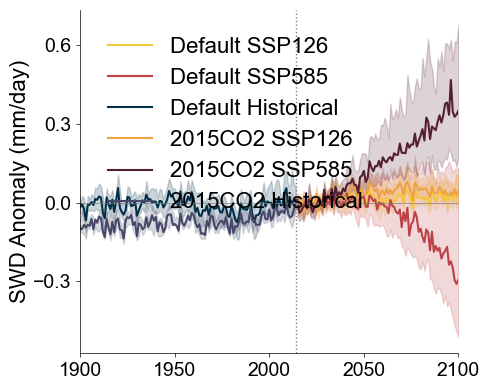

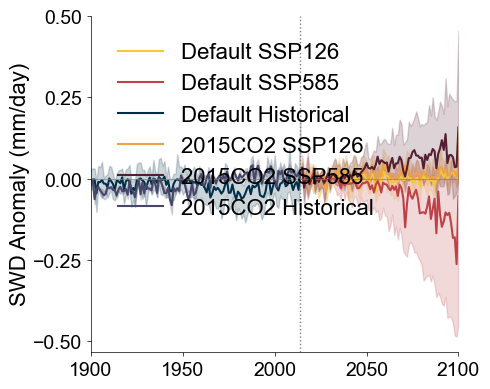

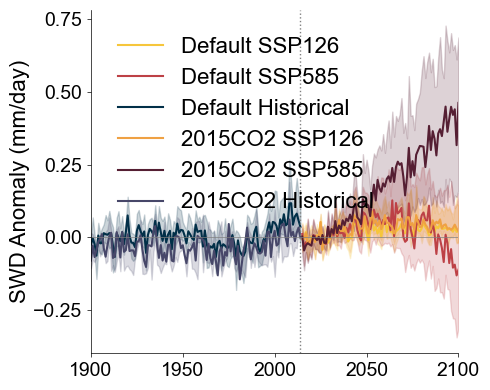

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import matplotlib.ticker as mticker

out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
for crop in crops:
    
    # 读取数据
    default_hist = pd.read_csv(out_dir / f'swd_{crop}_historical_models_default.csv', index_col='year')
    co2_hist = pd.read_csv(out_dir / f'swd_{crop}_historical_models_2015co2.csv', index_col='year')
    default_ssp126 = pd.read_csv(out_dir / f'swd_{crop}_ssp126_models_default.csv', index_col='year')
    default_ssp585 = pd.read_csv(out_dir / f'swd_{crop}_ssp585_models_default.csv', index_col='year')
    co2_ssp126 = pd.read_csv(out_dir / f'swd_{crop}_ssp126_models_2015co2.csv', index_col='year')
    co2_ssp585 = pd.read_csv(out_dir / f'swd_{crop}_ssp585_models_2015co2.csv', index_col='year')
    
    # 合并default的历史 + 未来
    default_all_126 = pd.concat([default_hist, default_ssp126])
    default_all_585 = pd.concat([default_hist, default_ssp585])
    co2_all_126 = pd.concat([default_hist, co2_ssp126])
    co2_all_585 = pd.concat([default_hist, co2_ssp585])
    baseline_start = 2014
    baseline_end = 2030
    # 修改后的计算距平函数 - 使用每个数据集自身的前5年作为基线
    def calculate_self_reference_anomaly(df, reference_years=20):
        # 获取每个数据集的前reference_years年作为基线
        baseline_start = df.index[0]
        baseline_end = df.index[0] + reference_years - 1
        baseline = df.loc[baseline_start:baseline_end].mean(axis=0)
        anomaly_df = df - baseline
        return anomaly_df
    
    # 计算各数据集的距平（使用自身前5年作为参考）
    default_all_126_anom = calculate_self_reference_anomaly(default_ssp126)
    default_all_585_anom = calculate_self_reference_anomaly(default_ssp585)
    co2_ssp126_anom = calculate_self_reference_anomaly(co2_ssp126)
    co2_ssp585_anom = calculate_self_reference_anomaly(co2_ssp585)
    default_hist_anom = calculate_self_reference_anomaly(default_hist)
    
    plt.figure(figsize=(5, 4))
    
    def plot_with_iqr(df, label, color, linestyle='-'):
        years = df.index
        median = df.median(axis=1)
        q25 = df.quantile(0.25, axis=1)
        q75 = df.quantile(0.75, axis=1)
        
        plt.plot(years, median, label=label, color=color, linestyle=linestyle)
        plt.fill_between(years, q25, q75, color=color, alpha=0.2)
    
    # 绘制距平图
    plot_with_iqr(default_all_126_anom, 'Default SSP126', color='#F6C63C')
    plot_with_iqr(default_all_585_anom, 'Default SSP585', color='#BD4146')
    plot_with_iqr(default_hist_anom, 'Default Historical', color='#012F48')
    # 固定 CO2 情景的距平
    plot_with_iqr(co2_ssp126_anom, '2015CO2 SSP126', color='#EFA143', linestyle='-')
    plot_with_iqr(co2_ssp585_anom, '2015CO2 SSP585', color='#551F33', linestyle='-')
    
    plot_with_iqr(calculate_anomaly(co2_hist), '2015CO2 Historical', color='#474769')
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.set_xlim(1900, 2100)  # 调整范围避免边缘空白
    ax.set_ylabel('SWD Anomaly (mm/day)', fontsize=16, labelpad=2)
    ax.set_xlabel('', fontsize=9, labelpad=2)
    
    # 刻度设置（主刻度50年，次刻度10年）
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=14)
    
    # 图例设置（无边框，左上角）
    ax.legend(frameon=False, fontsize=16, loc='upper left', bbox_to_anchor=(0.02, 0.98))
    
    # 辅助设置
    plt.axvline(x=2014, linestyle=':', color='gray', linewidth=1)
    plt.axhline(y=0, linestyle='-', color='gray', linewidth=0.5) 
    
    plt.tight_layout()
    plt.savefig(out_dir / f'swda_boxplot_final_{crop}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [91]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import join
from tqdm.notebook import tqdm

# === 参数设置 ===
crops = ['mai', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']
base_path = Path(r'E:\isimip3b_agricultal')
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)

for exp in ['default', '2015co2']:
    for crop in crops:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

        for ssp in ssps:
            print(f"\nProcessing: {crop} - {ssp}")
            if ssp == 'historical':
                years = np.arange(1850, 2015)
            else:
                years = np.arange(2015, 2101)
            
            day_files = sorted(list((base_path / 'matyday').glob(f'*_{ssp}_2015soc_{exp}_matyday-{crop}-noirr_global_annual-gs*.nc')))

            all_series = []
            for  day_file in tqdm( day_files, total=len(day_files)):
                if crop == 'wwh':
                    area_path_wwh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path_wwh)[list(xr.open_dataset(area_path_wwh).data_vars)[0]]
                    area_path_swh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path_swh)[list(xr.open_dataset(area_path_swh).data_vars)[0]]


                    maty_wwh = xr.open_dataset(day_file, decode_times=False)[f'matyday-{crop}-noirr'].where(area_wwh > 0).fillna(0)
                    maty_swh = xr.open_dataset(str(day_file).replace('wwh', 'swh'), decode_times=False)[f'matyday-swh-noirr'].where(area_swh > 0).fillna(0)
                    maty = maty_wwh + maty_swh
                    
                    maty = maty.where(maty != 0)

                else:

                    ds_day = xr.open_dataset(day_file, decode_times=False)

                    maty = ds_day[f'matyday-{crop}-noirr'].where(area > 0)

                swd = maty
                swd=swd.where(~np.isinf(swd), np.nan)
                swd_median = swd.mean(dim=['lat', 'lon'])
                swd_median['time'] = years

                series = swd_median.to_series().reset_index(drop=True)
                all_series.append(series)

            result_df = pd.DataFrame(all_series).T
            result_df.columns = [f'model_{i+1}' for i in range(len(all_series))]
            result_df['year'] = years
            result_df = result_df.set_index('year')
            result_df.to_csv(out_dir / f'maty_{crop}_{ssp}_models_{exp}.csv')


Processing: mai - historical


  0%|          | 0/59 [00:00<?, ?it/s]


Processing: mai - ssp126


  0%|          | 0/59 [00:00<?, ?it/s]


Processing: mai - ssp585


  0%|          | 0/60 [00:00<?, ?it/s]


Processing: wwh - historical


  0%|          | 0/54 [00:00<?, ?it/s]


Processing: wwh - ssp126


  0%|          | 0/54 [00:00<?, ?it/s]


Processing: wwh - ssp585


  0%|          | 0/55 [00:00<?, ?it/s]


Processing: soy - historical


  0%|          | 0/57 [00:00<?, ?it/s]


Processing: soy - ssp126


  0%|          | 0/57 [00:00<?, ?it/s]


Processing: soy - ssp585


  0%|          | 0/57 [00:00<?, ?it/s]


Processing: mai - historical


  0%|          | 0/8 [00:00<?, ?it/s]


Processing: mai - ssp126


  0%|          | 0/57 [00:00<?, ?it/s]


Processing: mai - ssp585


  0%|          | 0/57 [00:00<?, ?it/s]


Processing: wwh - historical


  0%|          | 0/3 [00:00<?, ?it/s]


Processing: wwh - ssp126


  0%|          | 0/52 [00:00<?, ?it/s]


Processing: wwh - ssp585


  0%|          | 0/52 [00:00<?, ?it/s]


Processing: soy - historical


  0%|          | 0/5 [00:00<?, ?it/s]


Processing: soy - ssp126


  0%|          | 0/55 [00:00<?, ?it/s]


Processing: soy - ssp585


  0%|          | 0/55 [00:00<?, ?it/s]

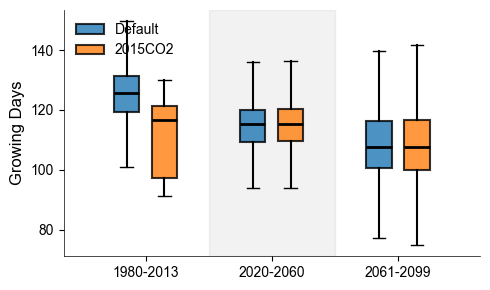

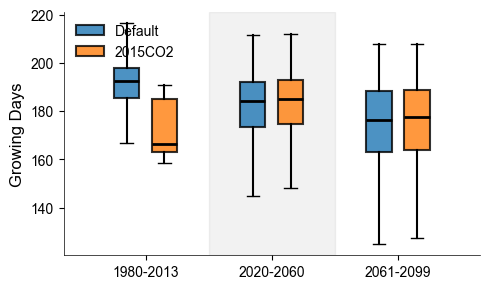

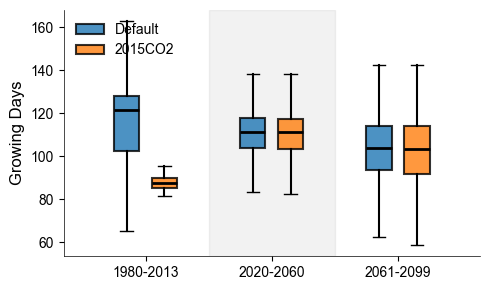

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pathlib import Path

# Set paths and parameters
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
crops = ['mai', 'wwh', 'soy']
experiments = ['default', '2015co2']
periods = ['1980-2013', '2020-2060', '2061-2099']
period_ranges = {
    '1980-2013': (1980, 2013),
    '2020-2060': (2020, 2060),
    '2061-2099': (2061, 2099)
}

# Set up plotting style
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

# Create a figure for each crop
for crop in crops:
    fig, ax = plt.subplots(figsize=(5, 3))
    
    # Prepare data structure
    data = {exp: [] for exp in experiments}
    
    for exp in experiments:
        # Load data
        hist_df = pd.read_csv(out_dir / f'maty_{crop}_historical_models_{exp}.csv', index_col='year')
        ssp126_df = pd.read_csv(out_dir / f'maty_{crop}_ssp126_models_{exp}.csv', index_col='year')
        ssp585_df = pd.read_csv(out_dir / f'maty_{crop}_ssp585_models_{exp}.csv', index_col='year')
        
        for period in periods:
            start, end = period_ranges[period]
            if period == '1980-2013':
                period_data = hist_df.loc[start:end].values.flatten()
            else:
                # Combine both SSPs for future periods
                data_126 = ssp126_df.loc[start:end].values.flatten()
                data_585 = ssp585_df.loc[start:end].values.flatten()
                period_data = np.concatenate([data_126, data_585])
            
            # Remove NaNs and add to data
            data[exp].append(period_data[~np.isnan(period_data)])
    
    # Set positions and width with increased spacing
    pos = np.arange(len(periods))
    width = 0.2  # Reduced width for better spacing
    spacing = 0.1  # Additional spacing between experiment boxes
    
    # Plot boxplots with enhanced styling
    boxprops = dict(linewidth=1.5)
    whiskerprops = dict(linewidth=1.5)
    medianprops = dict(linewidth=2, color='black')
    
    # Default experiment (shifted left)
    bp1 = ax.boxplot(data['default'], 
                    positions=pos - width/2 - spacing/2, 
                    widths=width,
                    patch_artist=True, 
                    boxprops=boxprops,
                    whiskerprops=whiskerprops, 
                    medianprops=medianprops,
                    showfliers=False)
    
    # 2015co2 experiment (shifted right)
    bp2 = ax.boxplot(data['2015co2'], 
                    positions=pos + width/2 + spacing/2, 
                    widths=width,
                    patch_artist=True, 
                    boxprops=boxprops,
                    whiskerprops=whiskerprops, 
                    medianprops=medianprops,
                    showfliers=False)
    
    # Color boxes with distinct colors
    for box in bp1['boxes']:
        box.set(facecolor='#1f77b4', alpha=0.8)
    for box in bp2['boxes']:
        box.set(facecolor='#ff7f0e', alpha=0.8)
    
    # Add shaded background for 2020-2060 period
    ax.axvspan(0.5, 1.5, color='gray', alpha=0.1, zorder=0)
    

    ax.set_xticks(pos)
    ax.set_xticklabels(periods)
    ax.set_ylabel('Growing Days', fontsize=12)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    
    # Remove grid
    ax.grid(False)
    
    # Add legend in upper left
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], 
             ['Default', '2015CO2'], 
             frameon=False,
             loc='upper left')
    
    plt.tight_layout()
    plt.savefig(out_dir / f'growning_days_boxplot_final_{crop}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

mai - Historical
(1980–2013) 中位数: 125.79
mai - SSP126
(2020-2060) 中位数: 116.72
mai - SSP126
(2061-2099) 中位数: 114.89
mai - SSP585
(2020-2060) 中位数: 113.61
mai - SSP585
(2061-2099) 中位数: 101.25


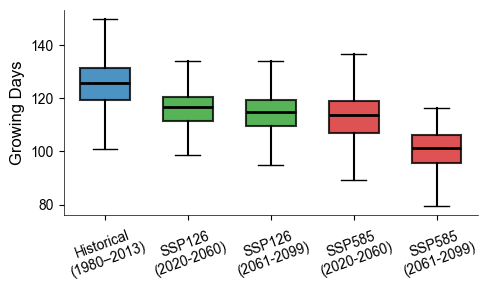

wwh - Historical
(1980–2013) 中位数: 192.39
wwh - SSP126
(2020-2060) 中位数: 185.42
wwh - SSP126
(2061-2099) 中位数: 184.12
wwh - SSP585
(2020-2060) 中位数: 182.78
wwh - SSP585
(2061-2099) 中位数: 167.50


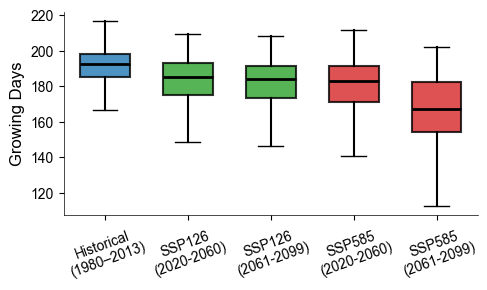

soy - Historical
(1980–2013) 中位数: 121.61
soy - SSP126
(2020-2060) 中位数: 112.53
soy - SSP126
(2061-2099) 中位数: 111.05
soy - SSP585
(2020-2060) 中位数: 109.79
soy - SSP585
(2061-2099) 中位数: 96.45


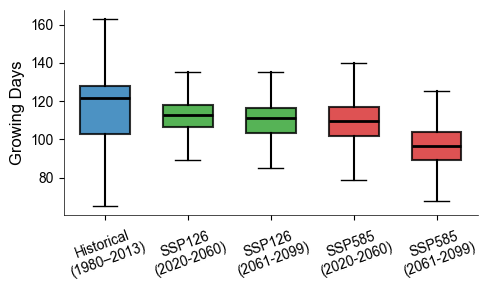

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pathlib import Path

# 设置路径
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
crops = ['mai', 'wwh', 'soy']
experiment = 'default'  # 只画 default 实验
period_ranges = {
    '1980-2013': (1980, 2013),
    '2020-2060': (2020, 2060),
    '2061-2099': (2061, 2099)
}
periods = list(period_ranges.keys())

# 画图样式
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

for crop in crops:
    fig, ax = plt.subplots(figsize=(5, 3))
    
    # 加载数据
    hist_df = pd.read_csv(out_dir / f'maty_{crop}_historical_models_{experiment}.csv', index_col='year')
    ssp126_df = pd.read_csv(out_dir / f'maty_{crop}_ssp126_models_{experiment}.csv', index_col='year')
    ssp585_df = pd.read_csv(out_dir / f'maty_{crop}_ssp585_models_{experiment}.csv', index_col='year')

    # 构造数据列表
    data = []
    labels = []
    colors = []
    positions = []
    
    pos_idx = 0
    width = 0.6
    
    # Historical (only 1980-2013)
    start, end = period_ranges['1980-2013']
    hist_values = hist_df.loc[start:end].values.flatten()
    data.append(hist_values[~np.isnan(hist_values)])
    labels.append('Historical\n(1980–2013)')
    colors.append('#1f77b4')
    positions.append(pos_idx)
    pos_idx += 1

    # SSP126: two periods
    for period in ['2020-2060', '2061-2099']:
        start, end = period_ranges[period]
        values = ssp126_df.loc[start:end].values.flatten()
        data.append(values[~np.isnan(values)])
        labels.append(f'SSP126\n({period})')
        colors.append('#2ca02c')
        positions.append(pos_idx)
        pos_idx += 1

    # SSP585: two periods
    for period in ['2020-2060', '2061-2099']:
        start, end = period_ranges[period]
        values = ssp585_df.loc[start:end].values.flatten()
        data.append(values[~np.isnan(values)])
        labels.append(f'SSP585\n({period})')
        colors.append('#d62728')
        positions.append(pos_idx)
        pos_idx += 1
    for label, values in zip(labels, data):
        median_val = np.median(values)
        print(f'{crop} - {label} 中位数: {median_val:.2f}')

    # 绘制 boxplot
    boxprops = dict(linewidth=1.5)
    whiskerprops = dict(linewidth=1.5)
    medianprops = dict(linewidth=2, color='black')
    
    bp = ax.boxplot(data, 
                    positions=positions, 
                    widths=width,
                    patch_artist=True,
                    boxprops=boxprops,
                    whiskerprops=whiskerprops,
                    medianprops=medianprops,
                    showfliers=False)
    
    # 设置颜色
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    # 美化图像
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=10, rotation=20)
    ax.set_ylabel('Growing Days', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.grid(False)

    plt.tight_layout()
    # plt.savefig(out_dir / f'growning_days_boxplot_default_{crop}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [8]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import join
from tqdm.notebook import tqdm

# === 参数设置 ===
crops = ['mai', 'wwh', 'soy']
exps=['default', '2015co2']
ssps = ['historical', 'ssp126', 'ssp585']
base_path = Path(r'D:\AAUDE\paper\paper8\data\result2')
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)
result_dict1 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}

for exp in exps:
    for crop in crops:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

        for ssp in ssps:
            if exp == '2015co2' and ssp == 'historical':
                continue
            if ssp == 'historical':
                years = np.arange(1850, 2015)
            else:
                years = np.arange(2015, 2101)
            if crop == 'wwh':
                area_path_wwh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                area_wwh = xr.open_dataset(area_path_wwh)[list(xr.open_dataset(area_path_wwh).data_vars)[0]]
                area_path_swh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                area_swh = xr.open_dataset(area_path_swh)[list(xr.open_dataset(area_path_swh).data_vars)[0]]

                pir_wwh = xr.open_dataset(join(base_path,f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'), decode_times=False)[f'ssi_gs_mean'].where(area_wwh > 0).fillna(0)
                pir_swh = xr.open_dataset(join(base_path,f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'), decode_times=False)[f'ssi_gs_mean'].where(area_swh > 0).fillna(0)
                pir = pir_wwh + pir_swh
                
                pir = pir.where(pir != 0)

            else:
                pir = xr.open_dataset(join(r"D:\AAUDE\paper\paper8\data\result2",f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'), decode_times=False)[f'ssi_gs_mean'].where(area > 0)

            swd = pir.where(pir<-0.42).count(dim=['lat','lon'])/pir[2].count()
            # result_dict1[exp][ssp][crop]=swd[1:]
            # result_dict1[exp][ssp][crop]=pir.where(pir<-0.42).count(dim=['lon'])/pir[2].count(dim=['lon'])
            result_dict1[exp][ssp][crop]=pir.where(pir<-0.42).sum(dim=['lon'])/pir[2].count(dim=['lon'])


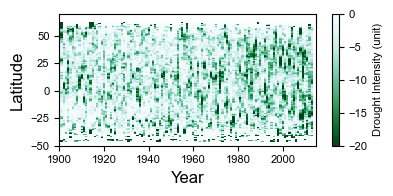

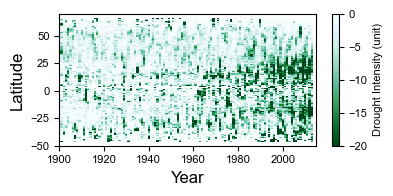

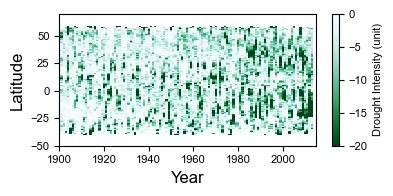

In [63]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

crops = ['mai', 'wwh', 'soy']

for crop in crops:
    # 获取年度干旱频率（%）
    hist = result_dict1['defalut']['historical'][crop] * 100  # DataArray: time, lat, lon

    # 按经度取平均 -> (time, lat)
    # hist_lat_mean = hist.mean(dim='lon', skipna=True)
    hist_lat_mean = hist

    # 创建图像
    fig, ax = plt.subplots(figsize=(4, 2))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    pcm = ax.pcolormesh(
        hist_lat_mean['year'],
        hist_lat_mean['lat'],
        hist_lat_mean.T,  # 转置使 lat 在 y 轴
        cmap='BuGn_r',    # 红蓝反转色系
        shading='auto',
        vmin=-20, vmax=0
    )

    # 颜色条
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', label='Drought Intensity (unit)')
    ax.set_ylim( -50, 70)
    ax.set_xlim( 1900, 2015)
    ax.tick_params(axis='both', which='major', labelsize=8)
    # 标签
    # ax.set_title(f'{crop.upper()} - Frequency of SSI < -0.42')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    plt.tight_layout()
    plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\lat_droght_intensity_{crop}_default.pdf', dpi=300, bbox_inches='tight')
    plt.show()


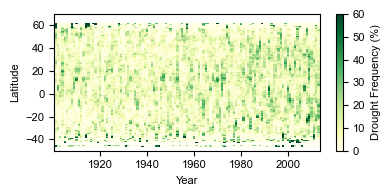

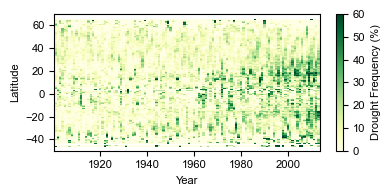

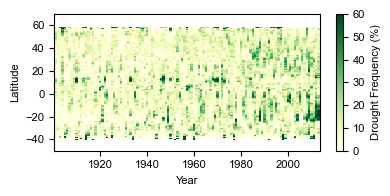

In [45]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

crops = ['mai', 'wwh', 'soy']

for crop in crops:
    # 获取年度干旱频率（%）
    hist = result_dict1['defalut']['historical'][crop] * 100  # DataArray: time, lat, lon

    # 按经度取平均 -> (time, lat)
    # hist_lat_mean = hist.mean(dim='lon', skipna=True)
    hist_lat_mean = hist

    # 创建图像
    fig, ax = plt.subplots(figsize=(4, 2))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    pcm = ax.pcolormesh(
        hist_lat_mean['year'],
        hist_lat_mean['lat'],
        hist_lat_mean.T,  # 转置使 lat 在 y 轴
        cmap='YlGn',    # 红蓝反转色系
        shading='auto',
        vmin=0, vmax=60
    )

    # 颜色条
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', label='Drought Frequency (%)')
    ax.set_ylim( -50, 70)
    # 标签
    # ax.set_title(f'{crop.upper()} - Frequency of SSI < -0.42')
    ax.set_xlabel('Year')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\lat_droght_{crop}_default.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
import xarray as xr
import numpy as np
from scipy.stats import linregress

crops = ['mai', 'wwh', 'soy']

for crop in crops:
    # 获取年度干旱频率数据
    hist = result_dict1['defalut']['historical'][crop]*100  # 百分比
    years = hist['year'].values

    # 切分两个历史阶段
    mask1 = (years >= 1902) & (years < 1980)
    mask2 = (years >= 1980) & (years <= 2013)

    y1 = hist.sel(year=slice(1902, 1979)).values
    y2 = hist.sel(year=slice(1980, 2013)).values

    x1 = years[mask1]
    x2 = years[mask2]

    # 线性拟合
    slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x1, y1)
    slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x2, y2)

    # 计算增长率：slope*年数
    growth1 = slope1 * (x1[-1]-x1[0]+1)
    growth2 = slope2 * (x2[-1]-x2[0]+1)

    print(f"\n{crop.upper()} - 历史时期线性拟合")
    print(f"1902-1980: slope={slope1:.3f} %/yr, growth={growth1:.2f} %, p={p_value1:.4f}")
    print(f"1980-2013: slope={slope2:.3f} %/yr, growth={growth2:.2f} %, p={p_value2:.4f}")



MAI - 历史时期线性拟合
1902-1980: slope=0.025 %/yr, growth=1.92 %, p=0.0181
1980-2013: slope=0.063 %/yr, growth=2.13 %, p=0.1477

WWH - 历史时期线性拟合
1902-1980: slope=0.030 %/yr, growth=2.33 %, p=0.0005
1980-2013: slope=0.190 %/yr, growth=6.45 %, p=0.0001

SOY - 历史时期线性拟合
1902-1980: slope=0.046 %/yr, growth=3.60 %, p=0.0001
1980-2013: slope=0.094 %/yr, growth=3.19 %, p=0.1095


In [23]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import join
from tqdm.notebook import tqdm

# === 参数设置 ===
crops = ['mai', 'wwh', 'soy']
exps=['default', '2015co2']
ssps = ['historical', 'ssp126', 'ssp585']
base_path = Path(r'D:\AAUDE\paper\paper8\data\result2')
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)
result_dict1 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}

for exp in exps:
    for crop in crops:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

        for ssp in ssps:
            if exp == '2015co2' and ssp == 'historical':
                continue
            if ssp == 'historical':
                years = np.arange(1850, 2015)
            else:
                years = np.arange(2015, 2101)
            if crop == 'wwh':
                area_path_wwh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                area_wwh = xr.open_dataset(area_path_wwh)[list(xr.open_dataset(area_path_wwh).data_vars)[0]]
                area_path_swh = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                area_swh = xr.open_dataset(area_path_swh)[list(xr.open_dataset(area_path_swh).data_vars)[0]]

                pir_wwh = xr.open_dataset(join(base_path,f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'), decode_times=False)[f'ssi_gs_mean'].where(area_wwh > 0).fillna(0)
                pir_swh = xr.open_dataset(join(base_path,f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'), decode_times=False)[f'ssi_gs_mean'].where(area_swh > 0).fillna(0)
                pir = pir_wwh + pir_swh
                
                pir = pir.where(pir != 0)

            else:
                pir = xr.open_dataset(join(r"D:\AAUDE\paper\paper8\data\result2",f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'), decode_times=False)[f'ssi_gs_mean'].where(area > 0)
            pir=pir.where(np.isfinite(pir))
            # swd = pir.where(pir<-0.42).count(dim=['lat','lon'])/pir[2].count()
            # result_dict1[exp][ssp][crop]=swd[1:]
            # result_dict1[exp][ssp][crop]=pir.where(pir<-0.42).count(dim=['lon'])/pir[2].count(dim=['lon'])
            result_dict1[exp][ssp][crop]=pir.mean(dim=['lat','lon'])


In [22]:
default_all_126

<xarray.DataArray 'ssi_gs_mean' (year: 198)> Size: 2kB
array([ 4.55815373e+00,  1.19935053e+01,  1.18451384e+01,  5.43329025e-01,
        9.23407536e+00,  4.08232607e+00,  4.97486878e+00,  4.84884635e+00,
        3.56044517e+00, -1.23963404e+00,  2.87463695e+00,  4.64370532e+00,
        6.24833819e+00,  5.50713062e-01,  1.17579863e+00,  4.41639442e+00,
        4.19156915e+00,  8.65148960e+00,  1.19827953e+01, -1.06352413e+00,
       -2.10264881e-01,  6.32958900e+00,  8.56096979e+00,  9.55952262e+00,
        1.86741342e+00,  2.33115447e+00,  4.24258208e+00,  8.91938186e+00,
        7.91708119e+00,  1.33629386e+01,  5.81520056e+00, -1.73001728e+00,
        1.01287759e+00,  7.64770447e+00, -1.24542479e+00,  3.00038328e+00,
        1.50175217e+00,  4.76532540e+00,  4.47741316e+00,  1.30793215e+00,
        1.03763781e+01,  3.17537919e+00,  7.50027008e-01,  5.49618778e+00,
        9.20091941e+00,  6.44938138e+00, -1.62487809e-01,  2.85329821e+00,
       -2.34933580e-01,  3.77768326e+00,  2.81336501e+00,  2.09435804e+00,
       -7.26643233e+00,  5.51547624e-01,  6.44775144e+00,  1.66076125e+00,
       -2.13997786e+00,  2.08968533e+00, -5.76670078e-02,  2.32090597e+00,
        3.82279320e+00, -3.21532097e+00, -2.37461191e+00, -3.01607498e+00,
        1.85639034e+00,  5.54975667e+00,  2.21932740e+00, -1.38322793e+00,
       -3.68117377e+00, -1.83230047e+00, -4.07662284e-01, -5.75000585e+00,
       -4.11479619e-01, -2.22816527e+00, -5.52228649e+00, -1.17744960e+00,
       -4.51579487e+00, -1.80466713e+00,  5.80253762e+00, -6.21028393e-01,
...
       -5.09046007e+00, -8.89906661e+00, -2.79828253e+00, -1.11627143e+01,
       -2.35921427e+00, -2.88427665e+00, -5.17345593e+00, -5.00248638e+00,
       -2.91604583e+00, -6.33993128e+00, -2.66577994e+00, -6.03794712e+00,
        4.95680518e-01, -6.13148048e+00, -9.15399388e+00, -7.41178146e+00,
       -6.54811121e+00, -8.34818163e+00,  1.24556405e+00, -1.28121272e-02,
       -4.72376085e+00, -6.24282013e+00, -1.43970952e+01, -7.80491554e+00,
       -4.18626368e+00, -3.60007258e-01, -5.02973785e+00, -1.25917748e+01,
       -5.07716453e+00,  4.38628544e-01, -8.17199908e+00, -7.14975017e+00,
       -1.06755486e+01, -1.05529656e+01, -4.63334743e+00, -2.15441923e+00,
        1.57209844e+00, -3.50624755e+00, -9.41461323e+00,  2.63983657e+00,
       -6.95014485e+00, -5.74179528e+00, -1.59860002e-01,  2.50578062e+00,
       -2.17100620e+00, -6.51856194e+00, -7.06941018e+00, -3.85838276e+00,
       -9.27285450e-01, -1.69709862e+00, -4.37759692e+00, -9.46354726e+00,
       -2.97580503e+00, -4.98995518e+00,  2.59508175e+00, -9.43787727e+00,
       -2.63483693e+00, -3.16354577e+00, -2.23783766e+00, -5.27143591e+00,
       -3.55192396e+00,  9.23186335e-01, -1.91523624e+00, -5.34808365e+00,
       -4.60517437e+00, -8.57124722e-01, -3.72452182e+00,  2.84730921e-01,
       -3.54176961e+00, -9.42114012e-01, -2.64051082e+00,  8.31263831e-01,
        9.23643142e-01, -5.90931490e-01, -2.61576016e+00,  3.74478346e+00,
       -4.75261449e+00, -3.76860796e+00])
Coordinates:
  * year     (year) int64 2kB 1901 1902 1903 1904 1905 ... 2096 2097 2098 2099

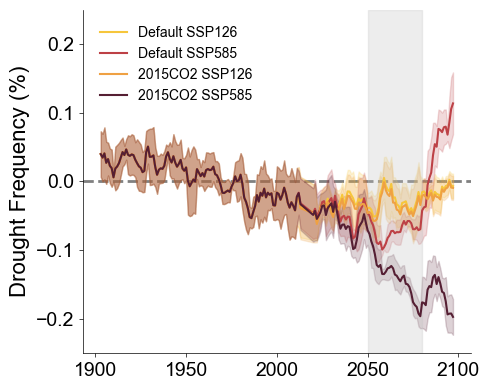

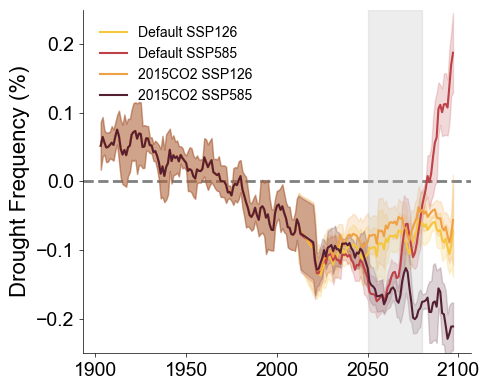

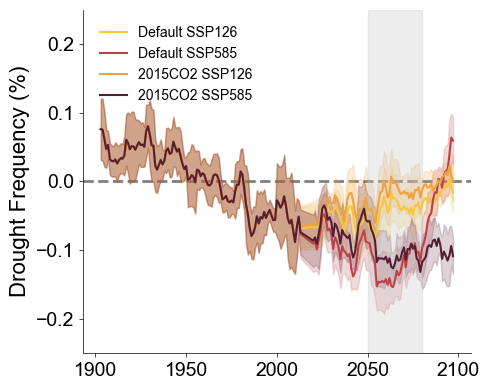

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import numpy as np
from pathlib import Path

# ========== 参数 ==========
crops = ['mai', 'wwh', 'soy']
exps = ['defalut', '2015co2']
ssps = ['historical', 'ssp126', 'ssp585']
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)

def smooth_and_std_xr(data, window=5, dim='year'):
    
    smoothed = data.rolling({dim: window}, center=True).mean()
    std_dev = data.rolling({dim: window}, center=True).std()
    
    return smoothed, std_dev

# ========== 主绘图 ==========
for crop in crops:
    # 读取历史 + 未来（default 和 co2）
    default_hist = result_dict1['default']['historical'][crop]
    default_ssp126 = result_dict1['default']['ssp126'][crop][5:]
    default_ssp585 = result_dict1['default']['ssp585'][crop][5:]
    co2_ssp126 = result_dict1['2015co2']['ssp126'][crop][5:]
    co2_ssp585 = result_dict1['2015co2']['ssp585'][crop][5:]

    # 拼接 default 历史和未来
    default_all_126 = xr.concat([default_hist, default_ssp126], dim='year')
    default_all_585 = xr.concat([default_hist, default_ssp585], dim='year')
    co2_all_126 = xr.concat([default_hist, co2_ssp126], dim='year')
    co2_all_585 = xr.concat([default_hist, co2_ssp585], dim='year')

    # ==== 平滑 + std ====
    d126_mean, d126_std = smooth_and_std_xr(default_all_126)
    d585_mean, d585_std = smooth_and_std_xr(default_all_585)
    c126_mean, c126_std = smooth_and_std_xr(co2_all_126)
    c585_mean, c585_std = smooth_and_std_xr(co2_all_585)

    # ========== 绘图 ==========
    plt.figure(figsize=(5, 4))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    def plot_shaded(mean_df, std_df, label, color, linestyle='-'):
        years = mean_df.year

        plt.plot(years, mean_df, label=label, color=color, linestyle=linestyle)
        plt.fill_between(years, mean_df - std_df, mean_df + std_df, color=color, alpha=0.2)

    plot_shaded(d126_mean, d126_std, 'Default SSP126', color='#F6C63C')
    plot_shaded(d585_mean, d585_std, 'Default SSP585', color='#BD4146')
    plot_shaded(c126_mean, c126_std, '2015CO2 SSP126', color='#EFA143')
    plot_shaded(c585_mean, c585_std, '2015CO2 SSP585', color='#551F33')
    
    # plt.axvline(x=2014, linestyle=':', color='gray', linewidth=1)
    plt.axhline(y=0, linestyle='--', color='gray', linewidth=2,zorder=0)

    # plt.xlim(1950, 2100)
    plt.ylabel('Drought Frequency (%)', fontsize=16)
    plt.xlabel('', fontsize=14)
    # plt.title(f'{crop.upper()} - SWD anomaly', fontsize=13)

    ax = plt.gca()
    ax.axvspan(2050, 2080, color='#C5C5C5', alpha=0.3, label='')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=14)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(0.01, 0.99))
    ax.set_ylim(-0.25,0.25)
    plt.tight_layout()
    plt.savefig(out_dir / f'df_plot_{crop}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [41]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import join
import matplotlib.pyplot as plt

# 参数设置
crops = ['mai', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']
exp = 'default'

base_path = Path(r'D:\AAUDE\paper\paper8\data\result2')
area_path = Path(r'D:\AAUDE\paper\paper8\data\area')
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)

result_dict = {crop: {} for crop in crops}

for crop in crops:
    # 读取种植面积
    if crop == 'wwh':
        area_wwh = xr.open_dataset(area_path / 'spam2020_v1r0_global_H_wwh_R.nc')
        area_swh = xr.open_dataset(area_path / 'spam2020_v1r0_global_H_swh_R.nc')
        area = area_wwh[list(area_wwh.data_vars)[0]] + area_swh[list(area_swh.data_vars)[0]]
    else:
        area = xr.open_dataset(area_path / f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = area[list(area.data_vars)[0]]

    for ssp in ssps:
        # 年份范围
        # years = np.arange(1850, 2015) if ssp == 'historical' else np.arange(2015, 2101)

        # 读取 SPEI growing season 文件
        if crop == 'wwh':
            pir_wwh = xr.open_dataset(base_path / f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_{exp}.nc')['spei_gs_mean']
            pir_swh = xr.open_dataset(base_path / f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_{exp}.nc')['spei_gs_mean']
            pir = (pir_wwh.fillna(0)) + (pir_swh .fillna(0))
            pir = pir.where(pir != 0)  # 屏蔽掉无值
        else:
            pir = xr.open_dataset(base_path / f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_{exp}.nc')['spei_gs_mean']
            pir = pir.where(area > 0)

        # drought = pir.where(pir < -0.54)
        # drought_ratio = drought.count(dim=['lat', 'lon']) / pir.count(dim=['lat', 'lon'])
        # result_dict[crop][ssp] = drought_ratio

        result_dict[crop][ssp] = pir.mean(dim=['lat','lon'])


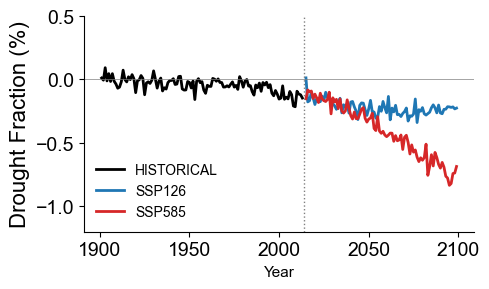

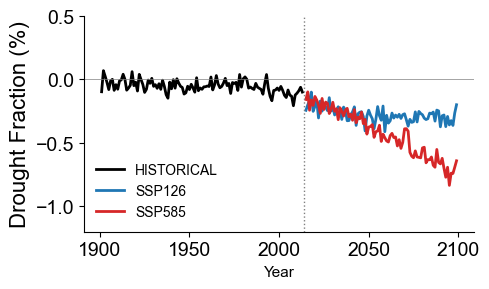

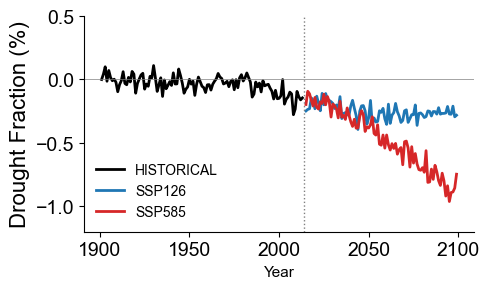

In [64]:
import matplotlib.ticker as mticker

colors = {'historical': 'black', 'ssp126': '#1f77b4', 'ssp585': '#d62728'}

for crop in crops:
    plt.figure(figsize=(5, 3))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    for ssp in ssps:
        ts = result_dict[crop][ssp]
        plt.plot(ts.year, ts.values , label=ssp.upper(), color=colors[ssp], linewidth=2)

    # 图形美化
    plt.axvline(x=2014, linestyle=':', color='gray', linewidth=1)
    plt.axhline(y=0, linestyle='-', color='gray', linewidth=0.5)
    # plt.xlim(1950, 2100)
    plt.ylim(-1.2, 0.5)
    # ax = plt.gca()
    
    plt.ylabel('Drought Fraction (%)', fontsize=16)
    plt.xlabel('Year', fontsize=11)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', labelsize=14)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
    plt.legend(frameon=False, fontsize=10, loc='lower left')
    
    plt.tight_layout()
    plt.savefig(out_dir / f'{crop}_swd_ratio_timeseries.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

In [67]:
import xarray as xr

# 打开数据集并提取 ssi 变量
ds = xr.open_dataset(join(base_path,f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_{exp}.nc'))
ssi = ds.spei_gs_mean

# 展平成一维、去除缺失值后，计算分位数
quantiles = ssi.values.flatten()
quantiles = quantiles[~np.isnan(quantiles)]

# 计算 0.02, 0.05, 0.1 分位数
q_002, q_005, q_01 = np.quantile(quantiles, [0.02, 0.05, 0.10])

print(f"0.02分位数: {q_002:.3f}")
print(f"0.05分位数: {q_005:.3f}")
print(f"0.10分位数: {q_01:.3f}")


0.02分位数: -2.049
0.05分位数: -1.679
0.10分位数: -1.360


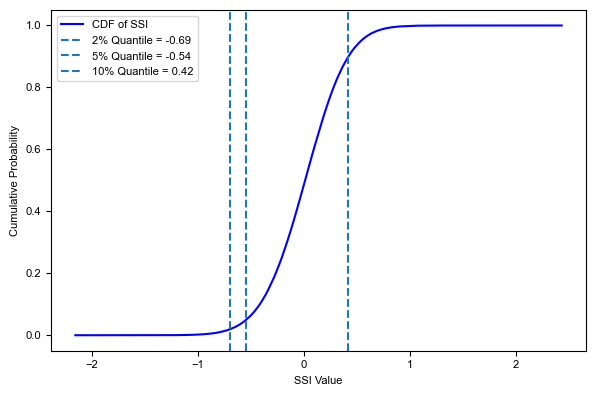

In [102]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join
base_path = (r'D:\AAUDE\paper\paper8\data\result2')
# 读取并提取数据
ds = xr.open_dataset(r"D:\AAUDE\paper\paper8\data\result2\mai_historical_ssi_growing_season_mean_parallel_defalut.nc")
# ds = xr.open_dataset(join(base_path,f'mai_historical_spei_scale3_growing_season_mean_parallel_defalut.nc'))
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
ssi = ds['ssi_gs_mean'].values.flatten()
ssi = ssi[~np.isnan(ssi)]  # 去除缺失值

# # 计算分位数
q_002, q_005, q_01 = np.quantile(ssi, [0.02, 0.05, 0.90])

# 排序并计算累积概率
ssi_sorted = np.sort(ssi)
cum_prob = np.linspace(0, 1, len(ssi_sorted))

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(ssi_sorted, cum_prob, label="CDF of SSI", color="blue")

# 添加分位数垂线
for q, label in zip([q_002, q_005, q_01], ['2%', '5%', '10%']):
    plt.axvline(x=q, linestyle='--', label=f'{label} Quantile = {q:.2f}')
plt.xlabel('SSI Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
import xarray as xr
from os.path import join
import numpy as np
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict1 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}
def change(data,yied,ssp):
    data = data[1:].rename({'year': 'time'})
    # if ssp == 'historical':
    data['time']=yied.time.values
    return data.where(np.isfinite(data))

for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_ssi_growing_season_mean_parallel_defalut.nc'))['ssi_gs_mean']
                    ssi_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_ssi_growing_season_mean_parallel_defalut.nc'))['ssi_gs_mean']
                    spei_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_defalut.nc'))['spei_gs_mean']
                    spei_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_defalut.nc'))['spei_gs_mean']
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_default.nc'))[f'yield-wwh-noirr'][-len(ssi_data_wwh):-1]
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_default.nc'))[f'yield-swh-noirr'][-len(ssi_data_wwh):-1]
                    ssi_data_wwh=change(ssi_data_wwh,yied_wwh,ssp)
                    ssi_data_swh=change(ssi_data_swh,yied_wwh,ssp)
                    spei_data_swh=change(spei_data_swh,yied_wwh,ssp)
                    spei_data_wwh=change(spei_data_wwh,yied_wwh,ssp)
                    
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[ssp][crop]['yield'] =yied.where(yied!=0)
                    result_dict1[ssp][crop]['spei'] = spei.where(spei!=0)
                    result_dict1[ssp][crop]['ssi'] = ssi.where(ssi!=0)
                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_ssi_growing_season_mean_parallel_defalut.nc'))['ssi_gs_mean']
                    spei_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_defalut.nc'))['spei_gs_mean']
                    yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_default.nc'))[f'yield-{crop}-noirr'][-len(ssi_data):-1]
                    ssi_data=change(ssi_data,yied,ssp)
                    spei_data=change(spei_data,yied,ssp)
                    result_dict1[ssp][crop]['yield'] =yied.where(area>0)
                    result_dict1[ssp][crop]['spei'] = spei_data.where(area>0)
                    result_dict1[ssp][crop]['ssi'] = ssi_data.where(area>0)
                except FileNotFoundError:
                    print(f"Warning: 缺少{crop}数据文件 for {var}-{ssp}")
                    continue


In [59]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}
for ssp in ssps:
    for crop in crops:
        # 特殊处理小麦（合并冬小麦和春小麦）
        if crop == 'whe':
            fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
            yied= xr.open_dataset(join(fp, f'expected_yield_wwh_{ssp}_default_v2.nc'))[f'expected_yield'].fillna(0)+\
             xr.open_dataset(join(fp, f'expected_yield_swh_{ssp}_default_v2.nc'))[f'expected_yield'].fillna(0)
            p_value= xr.open_dataset(join(fp, f'expected_yield_swh_{ssp}_default_v2.nc'))[f'p_value']+\
            xr.open_dataset(join(fp, f'expected_yield_wwh_{ssp}_default_v2.nc'))[f'p_value']
            
            result_dict2[ssp][crop]['expect_yield'] =yied.where(yied!=0)
            result_dict2[ssp][crop]['p_value'] = p_value.where(p_value!=0)

        else:
            fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
            yied= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_default_v2.nc'))[f'expected_yield']
            p_value= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_default_v2.nc'))[f'p_value']
            result_dict2[ssp][crop]['expect_yield'] =yied
            result_dict2[ssp][crop]['p_value'] = p_value

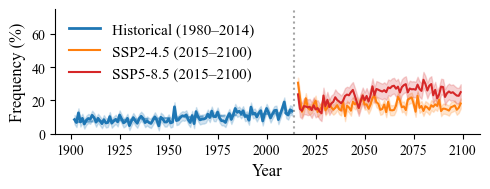

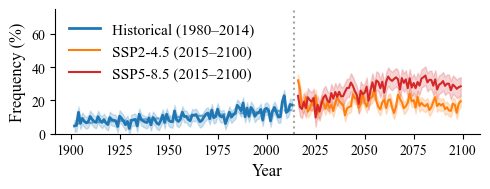

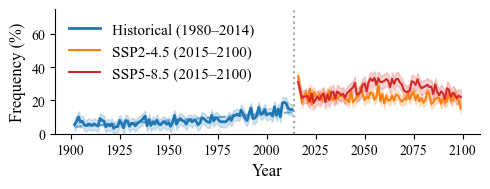

In [61]:
def calculate_drought_frequency(ssp, crop, min_years=5):
    # 数据准备
    yied = result_dict1[ssp][crop]['yield']
    ssi = result_dict1[ssp][crop]['ssi']
    spei = result_dict1[ssp][crop]['spei']
    
    # 创建作物掩膜
    crop_mask = (yied[0] >0)
    
    # 定义干旱事件|(ssi<-0.5) 
    drought_mask = ((ssi < -0.42))

    return (drought_mask.sum(dim=['lat','lon'])/ssi[-1].count())*100
    # return annual_drought.where(annual_drought.count() >= min_years)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe
plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体为新罗马

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'  # 设置字体为 Times New Roman

def plot_drought_timeseries(historical, ssp245, ssp585):
    fig, ax = plt.subplots(figsize=(5, 2))

    # 历史情景：计算均值与标准差
    hist_years = historical.time.dt.year
    hist_vals = historical.values
    z = np.polyfit(hist_years, hist_vals, 1)
    p = np.poly1d(z)

    ax.plot(hist_years, hist_vals, label='Historical (1980–2014)', color='#1f77b4', linewidth=2)
    ax.plot(hist_years, p(hist_years), color='#1f77b4', linestyle='--', alpha=0.6)

    # 添加±1标准差阴影
    hist_std = np.std(hist_vals)
    ax.fill_between(hist_years, hist_vals - hist_std, hist_vals + hist_std, color='#1f77b4', alpha=0.2)

    # SSP245
    ax.plot(ssp245.time.dt.year, ssp245, label='SSP2-4.5 (2015–2100)', color='#ff7f0e', linestyle='-')
    ssp245_std = np.std(ssp245.values)
    ax.fill_between(ssp245.time.dt.year, ssp245 - ssp245_std, ssp245 + ssp245_std, color='#ff7f0e', alpha=0.2)

    # SSP585
    ax.plot(ssp585.time.dt.year, ssp585, label='SSP5-8.5 (2015–2100)', color='#d62728', linestyle='-')
    ssp585_std = np.std(ssp585.values)
    ax.fill_between(ssp585.time.dt.year, ssp585 - ssp585_std, ssp585 + ssp585_std, color='#d62728', alpha=0.2)

    # 垂直线：表示历史与未来的分界点
    ax.axvline(2014, color='gray', linestyle=':', alpha=0.7)

    # 图形美化
    # ax.set_title('Temporal Evolution of Agricultural Drought Frequency', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Frequency (%)', fontsize=12)
    ax.legend(frameon=False, fontsize=11)
    # ax.grid(alpha=0.2)

    # 去掉顶部和右侧边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.ylim(0,75)
    # plt.savefig('drought_frequency_timeseries.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

crops=['mai','soy','whe']
for crop in crops:
    expect_yield=result_dict2[ssp][crop]['expect_yield']
    yied=result_dict1[ssp][crop]['yield']
    expect_yield=expect_yield[-len(yied):]
    expect_yield['time']=yied.time.values
    yield_loss=(yied-expect_yield)/yied
    historical=calculate_drought_frequency(ssps[0], crop, min_years=5)
    ssp126=calculate_drought_frequency(ssps[1], crop, min_years=5)
    ssp585=calculate_drought_frequency(ssps[2], crop, min_years=5)
    plot_drought_timeseries(historical, ssp126, ssp585)

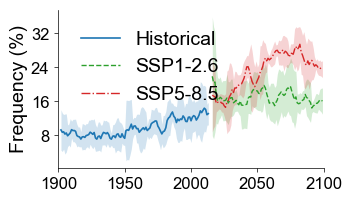

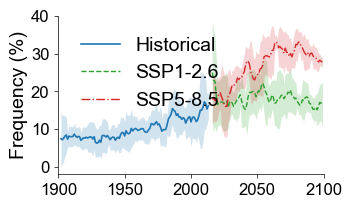

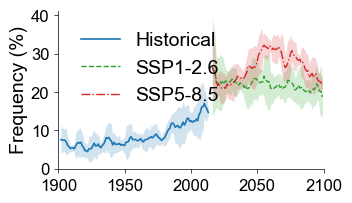

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib as mpl
def plot_drought_timeseries(historical, ssp126, ssp585, save_path=None):
    # 1. 设置图像尺寸（Nature单栏宽度8.7 cm，按比例调整高度）
    fig_width_cm = 8.7
    fig_height_cm = fig_width_cm * 0.6  # 高度比例可根据需要调整
    plt.figure(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))
    mpl.rcParams['pdf.fonttype'] = 42
    # 2. 字体设置（Nature推荐Arial/Helvetica）
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8  # 基础字号8pt
    
    # 3. 坐标轴样式（移除右/上边框）
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # 4. 计算滑动平均和标准差（窗口5年）
    def rolling_stats(series, window=5):
        roll_mean = series.rolling({'time': window}, center=True, min_periods=1).mean()
        roll_std = series.rolling({'time': window}, center=True, min_periods=1).std()
        return roll_mean, 1.96 * roll_std
    
    # 5. 绘制历史数据（蓝色）
    hist_mean, hist_std = rolling_stats(historical)
    ax.fill_between(historical.time.dt.year, 
                   (hist_mean - hist_std).values, 
                   (hist_mean + hist_std).values,
                   color='#1f77b4', alpha=0.2, linewidth=0)
    ax.plot(historical.time.dt.year,hist_mean,color='#1f77b4', linewidth=1.2, label='Historical')
    
    # 6. 绘制SSP1-2.6数据（绿色虚线）
    ssp126_mean, ssp126_std = rolling_stats(ssp126)
    ax.fill_between(ssp126.time.dt.year, 
                   (ssp126_mean - ssp126_std).values,
                   (ssp126_mean + ssp126_std).values,
                   color='#2ca02c', alpha=0.2, linewidth=0)
    ax.plot(ssp126.time.dt.year,ssp126_mean,color='#2ca02c', linestyle='--', linewidth=1.0, label='SSP1-2.6')
    
    # 7. 绘制SSP5-8.5数据（红色点划线）
    ssp585_mean, ssp585_std = rolling_stats(ssp585)
    ax.fill_between(ssp585.time.dt.year, 
                   (ssp585_mean - ssp585_std).values,
                   (ssp585_mean + ssp585_std).values,
                   color='#d62728', alpha=0.2, linewidth=0)
    ax.plot(ssp585.time.dt.year, ssp585_mean,color='#d62728', linestyle='-.', linewidth=1.0, label='SSP5-8.5')
    
    # 8. 坐标轴和标签设置
    ax.set_xlim(1900, 2100)  # 调整范围避免边缘空白
    ax.set_ylabel('Frequency (%)', fontsize=14, labelpad=2)
    ax.set_xlabel('', fontsize=9, labelpad=2)
    
    # 9. 刻度设置（主刻度50年，次刻度10年）
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    # ax.xaxis.set_minor_locator(mticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
    # ax.tick_params(axis='both', which='minor', width=0.3, length=2)
    

    ax.legend(frameon=False, fontsize=14, loc='upper left', bbox_to_anchor=(0.02, 0.98))
    output_path = save_path.replace('.svg', '.tif')
    # plt.savefig(
    #     output_path,
    #     format='pdf',
    #     dpi=300,
    #     bbox_inches='tight',
    #     transparent=True,
    # )
    plt.show()
    plt.close()

# 示例调用
for crop in crops:
    historical = calculate_drought_frequency('historical', crop)
    ssp126 = calculate_drought_frequency('ssp126', crop)
    ssp585 = calculate_drought_frequency('ssp585', crop)
    plot_drought_timeseries(
        historical, ssp126, ssp585,
        save_path=rf'D:\AAUDE\paper\paper8\framework\drought_frequency_{crop}.pdf'
    )

In [88]:
for ssp in ssps:
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:]
        yied=result_dict1[ssp][crop]['yield']
        expect_yield=expect_yield[-len(yied):]
        expect_yield['time']=yied.time.values
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi']
        spei=result_dict1[ssp][crop]['spei']
        spei['time']=yied.time.values
        ssi['time']=yied.time.values
        drought_mask = ( (spei < -0.52))
        prob=(((yield_loss<0)&drought_mask).sum(dim='time')/drought_mask.sum(dim='time'))*100
        prob=prob.where(prob!=0)
        print(f'ssi:{crop}_{ssp}:{(prob).mean(skipna=True).values}±{prob.std(skipna=True).values}')
        drought_mask = ( (ssi < -0.42))
        prob=(((yield_loss<0)&drought_mask).sum(dim='time')/drought_mask.sum(dim='time'))*100
        prob=prob.where(prob!=0)
        print(f'spei:{crop}_{ssp}:{(prob).mean(skipna=True).values}±{prob.std(skipna=True).values}')

ssi:mai_historical:69.67227943594982±23.37864792712031
spei:mai_historical:67.40199764579789±21.531849192286526
ssi:soy_historical:71.70543337186243±22.58374948718067
spei:soy_historical:71.84335291788516±20.02874480820477
ssi:whe_historical:76.69884951875872±22.153961505029123
spei:whe_historical:72.31785882137349±20.873800606656005
ssi:mai_ssp126:64.58437687519894±19.35754686224488
spei:mai_ssp126:67.29059336386538±20.968768376346414
ssi:soy_ssp126:67.36089605217667±18.013231790447843
spei:soy_ssp126:71.58464582065177±20.760673434658873
ssi:whe_ssp126:63.51505345110453±18.63034125086602
spei:whe_ssp126:67.21686417579079±21.145857010199144
ssi:mai_ssp585:57.5978912723844±15.674480907185831
spei:mai_ssp585:63.89356485264508±20.465532117467742
ssi:soy_ssp585:60.67467776841249±14.642371183448573
spei:soy_ssp585:66.60183151162182±20.307598146254016
ssi:whe_ssp585:56.78146320487051±15.884683424682379
spei:whe_ssp585:63.639266452778116±21.239546674217426


In [4]:
import matplotlib as mpl
for ssp in ssps:
    if ssp=='historical':
        idx=0
    else:
        idx=0
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-len(yied):]
        expect_yield=expect_yield[-idx:]
        expect_yield['time']=yied.time.values
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
        spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
        drought_mask = ( (ssi < -0.42))
        # drought_mask = ((spei < -0.5) | (ssi < -0.5))
        prob=(((yield_loss<0)&drought_mask).sum(dim='time')/drought_mask.sum(dim='time'))*100
        prob=prob.where(prob!=0)
        print(f'{crop}_{ssp}:{(prob).mean(skipna=True).values}±{prob.std(skipna=True).values}')
        plot_fig(prob,100,30,'RdPu','Probability (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_probability_loss.pdf')

NameError: name 'result_dict2' is not defined

mai_historical:12.34825159345203±8.122415453725502


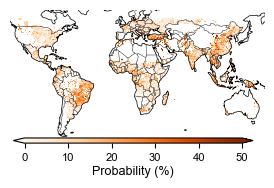

soy_historical:13.716726634937636±8.196535594331335


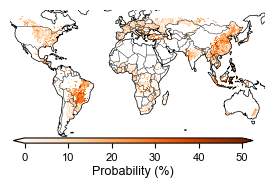

whe_historical:12.54693384374771±10.128926191062645


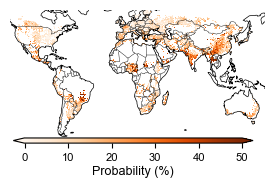

mai_ssp126:16.51429491825723±17.249155298526507


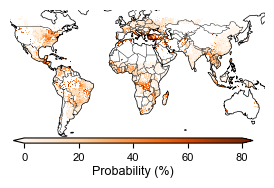

soy_ssp126:17.456703510049202±18.548855102293956


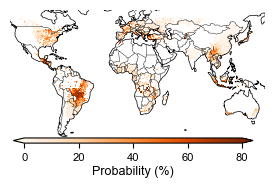

whe_ssp126:21.0369956317413±24.12808459935315


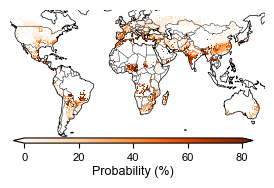

mai_ssp585:26.075988086613542±30.775315446494112


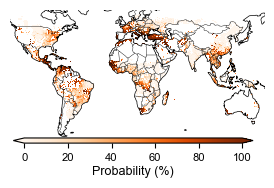

soy_ssp585:30.101926004368252±34.180057885148194


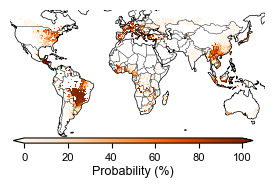

whe_ssp585:26.266484483365424±32.00533452368105


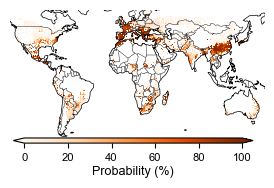

In [101]:
crop_prob_dict = {}
for ssp in ssps:
    crop_prob_dict[ssp] = {}
    if ssp=='historical':
        idx=33;vmax=50
    else:
        idx=30
    if ssp=='ssp126':
        vmax=80
    if ssp=='ssp585':
        vmax=100
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-len(yied):]
        expect_yield=expect_yield[-idx:]
        expect_yield['time']=yied.time.values
        yield_loss=(yied-expect_yield)/yied*100
        area=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\area\spam2020_v1r0_global_H_{crop}_R.nc').__xarray_dataarray_variable__
        ssi=result_dict1[ssp][crop]['ssi'][-idx:]
        spei=result_dict1[ssp][crop]['spei'][-idx:]

        # drought_mask = ((spei < -0.5) | (ssi < -0.5))
        drought_mask = ((ssi < -0.42))
        # prob=(((yield_loss<0)&drought_mask).sum(dim='time')/drought_mask.sum(dim='time'))*100
        count_valid = spei.count(dim='time')
        prob = (drought_mask.sum(dim='time') / count_valid) * 100
        prob = prob.where(count_valid > 0) 
        prob=prob.where(area>0)
        crop_prob_dict[ssp][crop] = prob
        print(f'{crop}_{ssp}:{(prob).mean(skipna=True).values}±{prob.std(skipna=True).values}')
        plot_fig(prob,0,vmax,'Oranges','Probability (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_probability_occure.pdf')

mai ssp126 0.6996198536890113


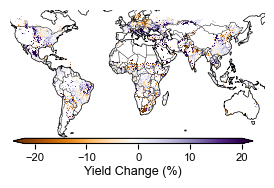

mai ssp585 1.1999039130898854


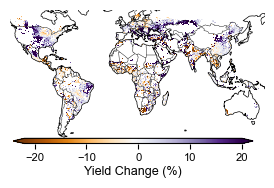

soy ssp126 -1.3872275194964439


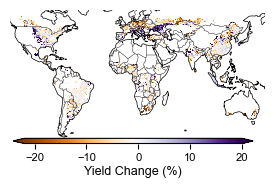

soy ssp585 -1.2505238599180521


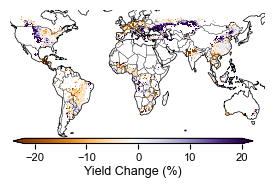

whe ssp126 -0.2825879835499576


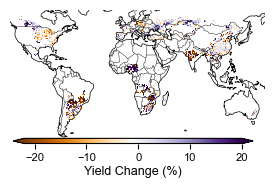

whe ssp585 1.3450312091263705


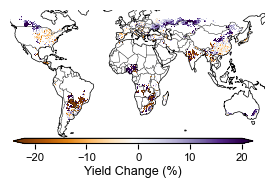

In [16]:
crop_prob_dict = {}
for ssp in ssps:
    crop_prob_dict[ssp] = {}
    if ssp=='historical':
        idx=33
    else:
        idx=30
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-len(yied):]
        expect_yield['time']=yied.time.values
        yied = yied.where(yied>0)
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
        spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
        spei['time']=yied.time.values
        ssi['time']=yied.time.values
        drought_mask = ((spei < -0.5) | (ssi < -0.5))
        yield_change_drought = yield_loss.where( drought_mask).mean(dim='time')
        # yield_change_drought = yield_loss.where(drought_mask&(yield_loss<0)).mean(dim='time')
        yield_change_drought=yield_change_drought.where(yield_change_drought!=0)
        # yield_change_drought=yield_change_drought.where(abs(yield_change_drought)<200)
        crop_prob_dict[ssp][crop] = yield_change_drought
import xarray as xr
import numpy as np

for crop in crops:
    for future_ssp in ['ssp126', 'ssp585']:
        diff = crop_prob_dict[future_ssp][crop] - crop_prob_dict['historical'][crop]
        vmax_diff = np.nanmax(np.abs(diff.values))
        diff=diff.where(diff!=0)
        print(crop,future_ssp,diff.median().values)
        plot_fig(diff, -20, 20, 'PuOr', 'Yield Change (%)', 
                 save_path=rf'D:\AAUDE\paper\paper8\fig_region\{crop}_{future_ssp}_vs_historical_loss_mean.pdf')


In [10]:
crop_prob_dict = {}
for ssp in ssps:
    crop_prob_dict[ssp] = {}
    if ssp=='historical':
        idx=33
    else:
        idx=30
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-len(yied):]
        expect_yield['time']=yied.time.values
        yied = yied.where(yied>0)
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
        spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
        spei['time']=yied.time.values
        ssi['time']=yied.time.values
        drought_mask = ((spei < -0.5) | (ssi < -0.5))
        yield_change_drought = yield_loss.where( drought_mask).sum(dim='time')/idx*10
        # yield_change_drought = yield_loss.where(drought_mask&(yield_loss<0)).mean(dim='time')
        yield_change_drought=yield_change_drought.where(yield_change_drought!=0)
        # yield_change_drought=yield_change_drought.where(abs(yield_change_drought)<200)
        crop_prob_dict[ssp][crop] = yield_change_drought

mai ssp126 -2.0872405145361688


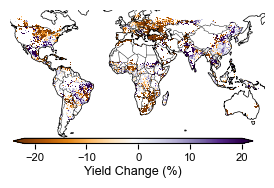

mai ssp585 -5.860366894969797


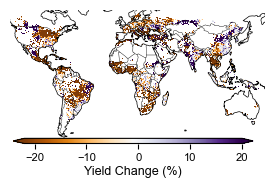

soy ssp126 -8.567911177335535


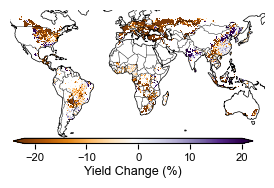

soy ssp585 -15.700216860555678


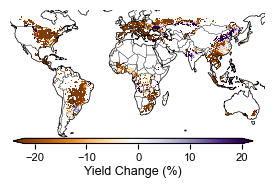

whe ssp126 -5.736274030155662


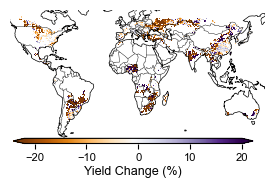

whe ssp585 -7.54636468431816


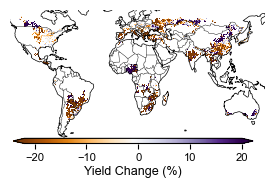

In [15]:
import xarray as xr
import numpy as np

for crop in crops:
    for future_ssp in ['ssp126', 'ssp585']:
        diff = crop_prob_dict[future_ssp][crop] - crop_prob_dict['historical'][crop]
        vmax_diff = np.nanmax(np.abs(diff.values))
        diff=diff.where(diff!=0)
        print(crop,future_ssp,diff.median().values)
        plot_fig(diff, -20, 20, 'PuOr', 'Yield Change (%)', 
                 save_path=rf'D:\AAUDE\paper\paper8\fig_region\{crop}_{future_ssp}_vs_historical_loss_decade.pdf')


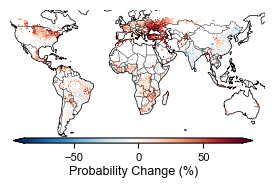

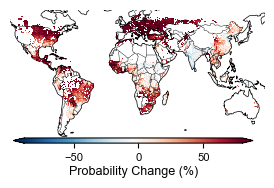

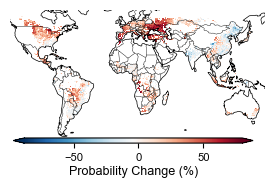

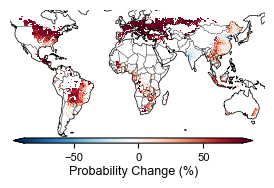

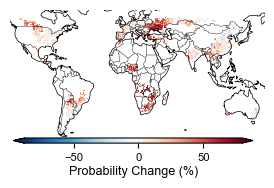

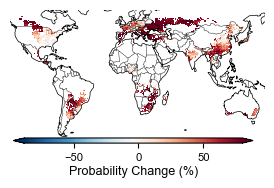

In [25]:
import xarray as xr
import numpy as np

for crop in crops:
    for future_ssp in ['ssp126', 'ssp585']:
        diff = crop_prob_dict[future_ssp][crop] - crop_prob_dict['historical'][crop]
        vmax_diff = np.nanmax(np.abs(diff.values))
        plot_fig(diff, -80, 80, 'RdBu_r', 'Probability Change (%)', 
                 save_path=rf'D:\AAUDE\paper\paper8\framework\{crop}_{future_ssp}_vs_historical_prob_diff.pdf')


In [96]:
yield_change_drought

<xarray.DataArray (lat: 360, lon: 30)> Size: 86kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 240B 165.2 165.8 166.2 166.8 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

mai_historical:-14.731375124190025±19.597682151504866


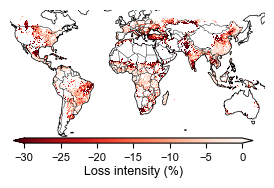

mai_historical:-8.25401966876076±17.22076180835415


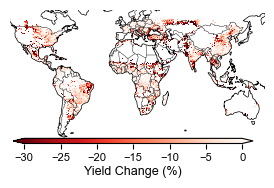

soy_historical:-14.333119513519941±15.555249360195202


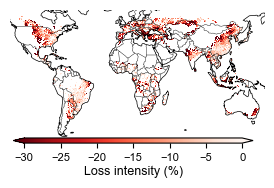

soy_historical:-6.801697654699501±13.648441946908326


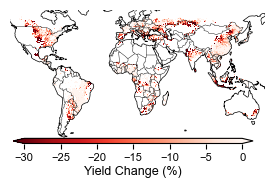

whe_historical:-23.758317843257494±29.946883940003772


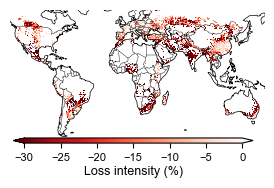

whe_historical:-14.022222914108921±27.137551855342167


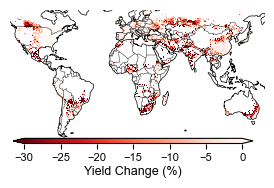

mai_ssp126:-13.868453811824569±18.78752584125531


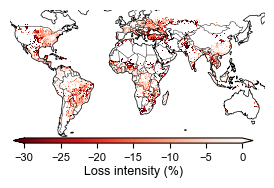

mai_ssp126:-8.073902194891357±16.832168532470295


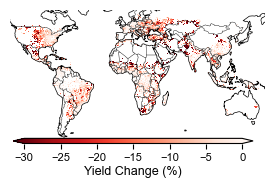

soy_ssp126:-12.437293727187193±14.20139443792528


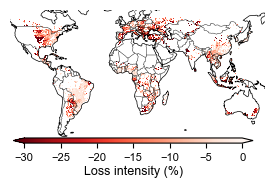

soy_ssp126:-8.184405003403835±13.230802400656222


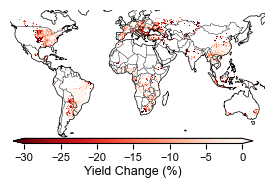

whe_ssp126:-22.560427423462503±30.200504256283146


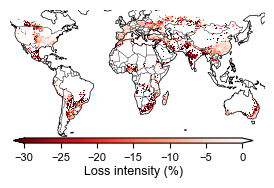

whe_ssp126:-13.259929866716707±26.362799661353872


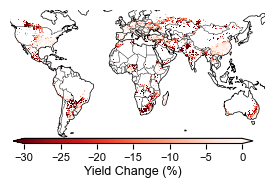

mai_ssp585:-15.44117864687423±19.923921765638486


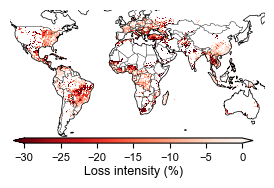

mai_ssp585:-8.132173652561649±17.312985264140853


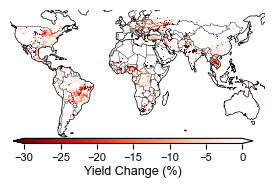

soy_ssp585:-13.141004305801829±12.960963704260669


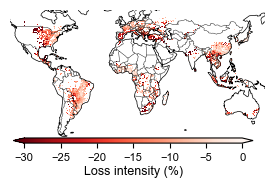

soy_ssp585:-6.563369681994136±11.899332070786095


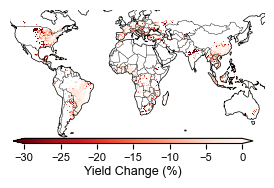

whe_ssp585:-26.84764759170446±37.00080411336781


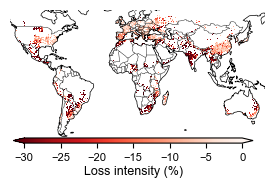

whe_ssp585:-15.02108706046761±33.5391624638726


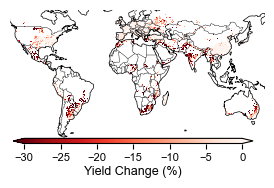

In [98]:
for ssp in ssps:
    if ssp=='historical':
        idx=33
    else:
        idx=30
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-idx:]
        yied = yied.where(yied>0)
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][-idx:]
        spei=result_dict1[ssp][crop]['spei'][-idx:]
        # drought_mask = ((spei < -0.5) | (ssi < -0.42))
        drought_mask = ( (ssi < -0.42))
        yield_change_drought = yield_loss.where(drought_mask).mean(dim='time')
        yield_change_drought=yield_change_drought.where(abs(yield_change_drought)<200)
        loss_intensity = yield_loss.where((yield_loss<0) & drought_mask).mean(dim='time')
        loss_intensity=loss_intensity.where(abs(loss_intensity)<200)
        print(f'{crop}_{ssp}:{(loss_intensity).mean(skipna=True).values}±{loss_intensity.std(skipna=True).values}')
        plot_fig(loss_intensity,0,-30,'Reds_r','Loss intensity (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_probability_loss_intensity.pdf')
        print(f'{crop}_{ssp}:{(yield_change_drought).mean(skipna=True).values}±{yield_change_drought.std(skipna=True).values}')
        plot_fig(yield_change_drought,0,-30,'Reds_r','Yield Change (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_probability_yield_change_drought.pdf')

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mai_historical:-14.622150107488599±18.47530265756696


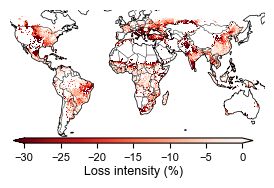

mai_historical:-9.259604134279108±16.6499711948825


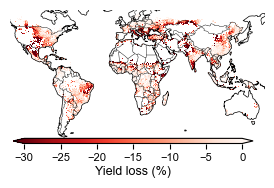

soy_historical:-13.496780935061665±14.061556311315417


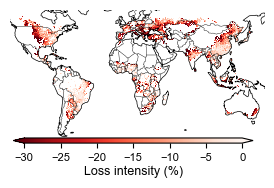

soy_historical:-6.073754732944813±13.009093329183326


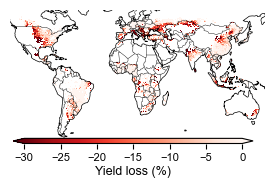

whe_historical:-20.748465732907317±28.608253940395013


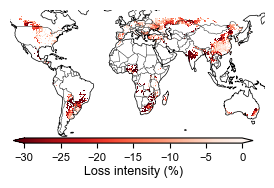

whe_historical:-12.532250546388227±25.574051777721234


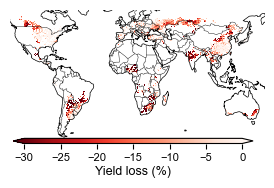

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mai_ssp126:-13.322241005503825±17.71487101395525


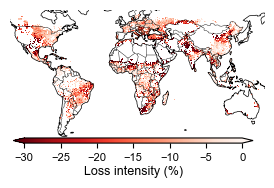

mai_ssp126:-8.00821289226163±15.728850351742093


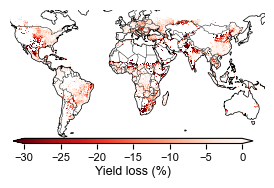

soy_ssp126:-11.730720049433707±11.370620094796623


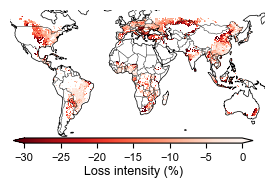

soy_ssp126:-7.147272034662066±10.318764879403046


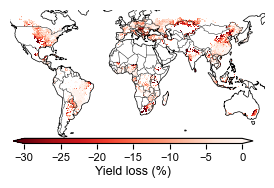

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


whe_ssp126:-18.12071444673384±25.56318166046897


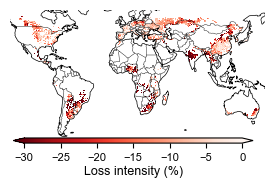

whe_ssp126:-10.656347077229594±21.87802174430031


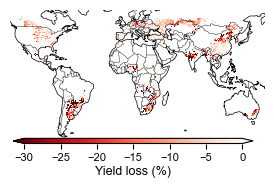

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mai_ssp585:-12.88648605758617±16.13568056230737


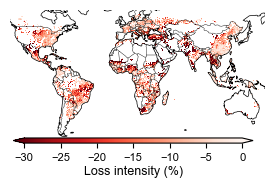

mai_ssp585:-4.2241669689701±13.58746348849227


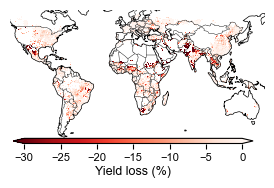

soy_ssp585:-12.357226852584077±12.870200698059318


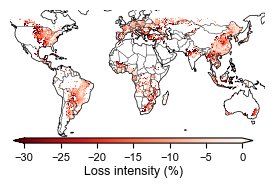

soy_ssp585:-3.43146877726353±11.776080969309481


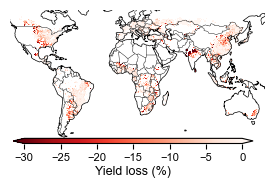

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


whe_ssp585:-20.427505466927773±31.565362210117538


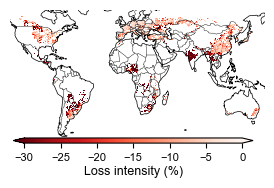

whe_ssp585:-6.187243132669566±25.581214065615896


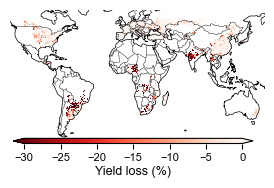

In [8]:
for ssp in ssps:
    if ssp=='historical':
        idx=33
    else:
        idx=30
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-idx:]
        expect_yield['time']=yied.time.values
        # yied = yied.where(yied>0)
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
        spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
        spei['time']=yied.time.values
        ssi['time']=yied.time.values
        drought_mask = ((spei < -0.5) &(spei >-1 ))|( (ssi < -0.5)&(ssi >-1 ))
        yield_change_drought = yield_loss.where(drought_mask).mean(dim='time')
        yield_change_drought=yield_change_drought.where(abs(yield_change_drought)<200)
        loss_intensity = yield_loss.where((yield_loss<0) & drought_mask).mean(dim='time')
        loss_intensity=loss_intensity.where(abs(loss_intensity)<200)
        print(f'{crop}_{ssp}:{(loss_intensity).mean(skipna=True).values}±{loss_intensity.std(skipna=True).values}')
        plot_fig(loss_intensity,0,-30,'Reds_r','Loss intensity (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\fig_level\{crop}_{ssp}_loss_intensity_mild.pdf')
        print(f'{crop}_{ssp}:{(yield_change_drought).mean(skipna=True).values}±{yield_change_drought.std(skipna=True).values}')
        plot_fig(yield_change_drought,0,-30,'Reds_r','Yield loss (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\fig_level\{crop}_{ssp}_yield_change_drought_mild.pdf')

mai_historical:-27.130193787865284±29.98619978295077


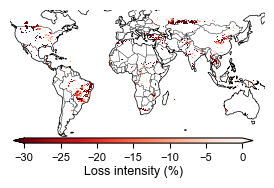

mai_historical:-21.423065876359455±30.064352425558212


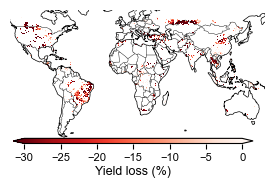

soy_historical:-23.425025345598396±22.96400822190568


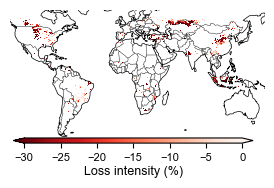

soy_historical:-15.72598959673937±24.288895315387272


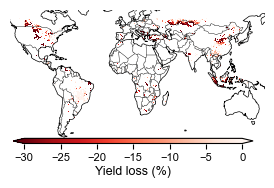

whe_historical:-37.645069276302095±34.54221433397664


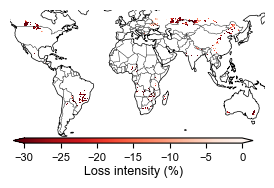

whe_historical:-33.56802269303602±35.07572139094492


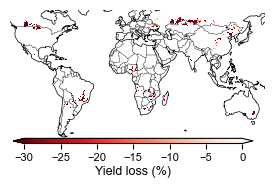

mai_ssp126:-22.65698158661315±25.125607926594455


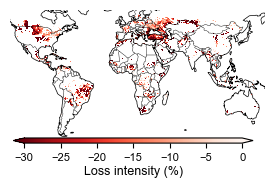

mai_ssp126:-18.72543175043899±24.59818617807753


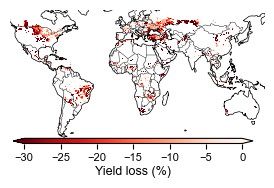

soy_ssp126:-21.154632171089844±19.9129408386252


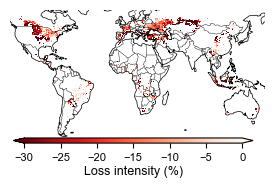

soy_ssp126:-18.14467641542385±19.872603484408796


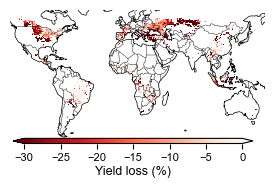

whe_ssp126:-28.569996186549407±31.308984260575315


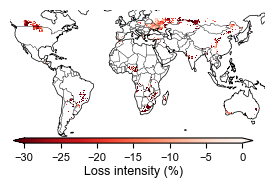

whe_ssp126:-23.29246911041518±30.967830302281637


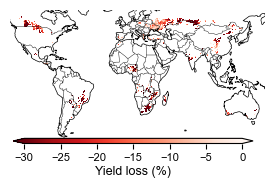

mai_ssp585:-16.31036403050397±21.03208554020077


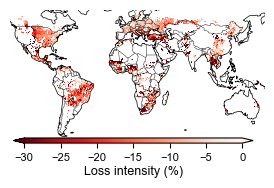

mai_ssp585:-8.95231789381465±18.701384926657855


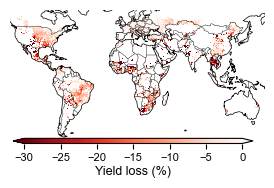

soy_ssp585:-14.993746595270972±13.883342852021835


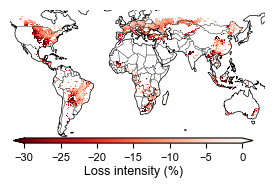

soy_ssp585:-8.424755259823488±13.107857601382733


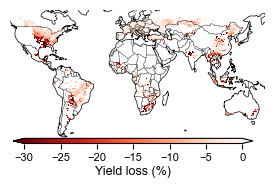

whe_ssp585:-23.93050853957945±34.09620657686164


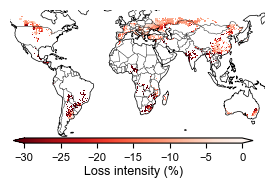

whe_ssp585:-11.853151997084±30.616726835183584


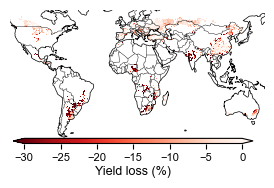

In [9]:
for ssp in ssps:
    if ssp=='historical':
        idx=33
    else:
        idx=30
    for crop in crops:
        expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1]
        yied=result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield=expect_yield[-idx:]
        expect_yield['time']=yied.time.values
        yied = yied.where(yied>0)
        yield_loss=(yied-expect_yield)/yied*100
        
        ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
        spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
        spei['time']=yied.time.values
        ssi['time']=yied.time.values
        drought_mask = ((spei < -1) | (ssi < -1))
        yield_change_drought = yield_loss.where(drought_mask).mean(dim='time')
        yield_change_drought=yield_change_drought.where(abs(yield_change_drought)<200)
        loss_intensity = yield_loss.where((yield_loss<0) & drought_mask).mean(dim='time')
        loss_intensity=loss_intensity.where(abs(loss_intensity)<200)
        print(f'{crop}_{ssp}:{(loss_intensity).mean(skipna=True).values}±{loss_intensity.std(skipna=True).values}')
        plot_fig(loss_intensity,0,-30,'Reds_r','Loss intensity (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\fig_level\{crop}_{ssp}_loss_intensity_severse.pdf')
        print(f'{crop}_{ssp}:{(yield_change_drought).mean(skipna=True).values}±{yield_change_drought.std(skipna=True).values}')
        plot_fig(yield_change_drought,0,-30,'Reds_r','Yield loss (%)',\
                 save_path=rf'D:\AAUDE\paper\paper8\fig_level\{crop}_{ssp}_yield_change_drought_severse.pdf')

### drought level

In [54]:
import pandas as pd
frequency_data = []

for ssp in ssps:
    idx = 33 if ssp == 'historical' else 30
    for crop in crops:
        # 获取基础数据
        expect_yield = (result_dict2[ssp][crop]['expect_yield'])[:-1]
        yied = result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yied = yied.where(yied > 0)
        yield_loss = (yied - expect_yield) / yied * 100

        ssi = result_dict1[ssp][crop]['ssi'][ -idx:]
        spei = result_dict1[ssp][crop]['spei'][ -idx:]
        spei['time'] = yied.time.values
        ssi['time'] = yied.time.values

        for drought_type, mask_expr in {
            'mild': ((spei < -0.42) & (spei > -0.67)) | ((ssi < -0.42) & (ssi > -67)),
            'severe': (spei < -0.67) | (ssi < -67),
            'drought': (spei < -0.42) | (ssi < -0.42)
            }.items():
            drought_mask = mask_expr
            
            # 计算干旱频率和标准差
            freq_per_pixel = mask_expr.sum(dim=['lat','lon'])/spei[6].count()  # 转换为百分比
            freque = freq_per_pixel.mean().values.item()
            std = freq_per_pixel.std().values.item()
            
            # 单独存储频率数据用于绘图
            freq_df = pd.DataFrame({
                'Frequency (%)': [freque],  # 注意这里改为列表形式
                'std (%)': [std],          # 注意这里改为列表形式
                'SSP': [ssp],
                'Crop': [crop],
                'Drought': [drought_type],
                'SSP_Drought': [f"{ssp}_{drought_type}"]
            })
            frequency_data.append(freq_df)

# 合并数据
frequency_df = pd.concat(frequency_data, ignore_index=True)

<Figure size 400x300 with 0 Axes>

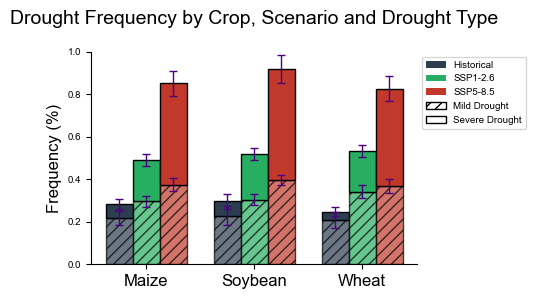

累计柱状图已保存至: D:/AAUDE/paper/paper8/fig_level\stacked_drought_frequency.pdf


In [57]:
def plot_stacked_drought_frequency(frequency_df, save_dir):
    """绘制分时期干旱频率累计柱状图"""
    mpl.rcParams['pdf.fonttype'] = 42
    plt.figure(figsize=(4, 3))
    plt.rcParams["font.family"] = "Arial"
    # 筛选需要的数据（只保留mild和severe）
    plot_df = frequency_df[frequency_df['Drought'].isin(['mild', 'severe'])]
    
    # 设置颜色
    ssp_colors = {
        'historical': '#2c3e50',  # 深蓝
        'ssp126': '#27ae60',     # 绿色
        'ssp585': '#c0392b'      # 红色
    }
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(5, 3))
    
    # 每个SSP创建一个柱状组
    bar_width = 0.25
    positions = np.arange(len(['mai', 'soy', 'whe']))  # 作物位置
    
    # 创建图案
    mild_pattern = '///'
    severe_pattern = ''
    
    for i, ssp in enumerate(['historical', 'ssp126', 'ssp585']):
        ssp_df = plot_df[plot_df['SSP'] == ssp]
        
        # 计算底部位置（用于堆叠）
        bottom = np.zeros(len(positions))
        
        for drought_type in ['mild', 'severe']:
            # 获取当前干旱类型数据
            values = []
            stds = []
            for crop in ['mai', 'soy', 'whe']:
                subset = ssp_df[(ssp_df['Crop'] == crop) & (ssp_df['Drought'] == drought_type)]
                values.append(subset['Frequency (%)'].mean() if not subset.empty else 0)
                stds.append(subset['std (%)'].mean() if not subset.empty else 0)
            
            # 绘制柱状图
            bars = ax.bar(
                positions + i * bar_width,
                values,
                width=bar_width,
                bottom=bottom,
                color=ssp_colors[ssp],
                edgecolor='black',
                label=f'{ssp.upper()} {drought_type.capitalize()}',
                alpha=0.7 if drought_type == 'mild' else 1.0
            )
            
            # 添加图案区分干旱类型
            if drought_type == 'mild':
                for bar in bars:
                    bar.set_hatch(mild_pattern)
            
            # 添加误差棒（在柱子顶部）
            for j in range(len(positions)):
                if values[j] > 0:  # 只对有值的柱子添加误差棒
                    ax.errorbar(
                        positions[j] + i * bar_width,
                        bottom[j] + values[j],  # 误差棒在柱子顶部
                        yerr=stds[j],
                        fmt='none',
                        ecolor='indigo',
                        elinewidth=1,
                        capsize=3,
                        capthick=1
                    )
            
            bottom += values
    
    # 设置x轴
    ax.set_xticks(positions + bar_width)
    ax.set_xticklabels(['Maize', 'Soybean', 'Wheat'], fontsize=12)
    
    # 设置y轴
    ax.set_ylabel('Frequency (%)', fontsize=12)
    ax.set_ylim(0, 1)  # 限制最大100%
    
    # 添加标题和网格
    ax.set_title('Drought Frequency by Crop, Scenario and Drought Type', fontsize=14, pad=20)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # 创建自定义图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=ssp_colors['historical'], label='Historical'),
        Patch(facecolor=ssp_colors['ssp126'], label='SSP1-2.6'),
        Patch(facecolor=ssp_colors['ssp585'], label='SSP5-8.5'),
        Patch(facecolor='white', edgecolor='black', hatch=mild_pattern, label='Mild Drought'),
        Patch(facecolor='white', edgecolor='black', hatch=severe_pattern, label='Severe Drought')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(False)
    # 调整布局
    plt.tight_layout()
    
    # 保存图形
    output_path = os.path.join(save_dir, 'stacked_drought_frequency.pdf')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return output_path
import os
# 运行绘图
if __name__ == '__main__':
    import numpy as np
    stacked_path = plot_stacked_drought_frequency(frequency_df, 'D:/AAUDE/paper/paper8/fig_level')
    print(f"累计柱状图已保存至: {stacked_path}")

In [87]:
yield_change_drought

<xarray.DataArray (lat: 360, lon: 720)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [90]:
# 假设 yield_change_drought 是 xarray.DataArray
min_val = yield_change_drought.min().item()  # 最小值
min_loc = yield_change_drought.where(yield_change_drought == min_val, drop=True)  # 最小值所在位置

# 获取经纬度坐标
coords = {dim: min_loc[dim].values[0] for dim in min_loc.dims if dim in ['lat', 'lon']}

print("最小值：", min_val)
print("最小值对应的坐标：", coords)


最小值： -299.1579628678792
最小值对应的坐标： {'lat': 31.75, 'lon': -4.75}


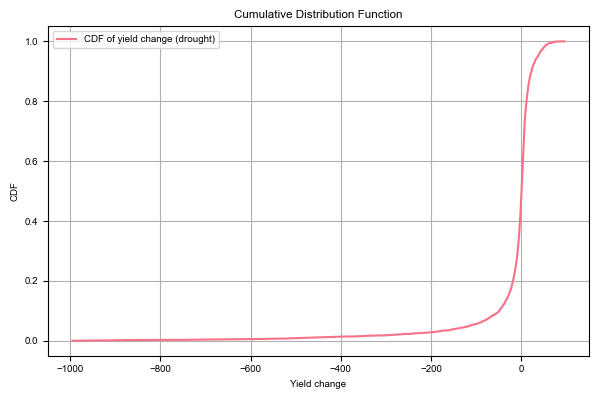

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 yield_change_drought 是一个 numpy 数组
aa=yield_loss[2].where(ssi[2]<-0.42)
data = aa.where(aa>-1000).values.flatten()

# 去掉 NaN
data = data[~np.isnan(data)]

# 计算 CDF
sorted_data = np.sort(data)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(sorted_data, cdf, label='CDF of yield change (drought)')
plt.xlabel('Yield change')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 准备容器
all_data = []

for ssp in ssps:
    idx = 33 if ssp == 'historical' else 30
    for crop in crops:
        # 获取基础数据
        expect_yield = (result_dict2[ssp][crop]['expect_yield'])[:-1]
        yied = result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yied = yied.where(yied > 0)
        yield_loss = (yied - expect_yield) / yied * 100

        ssi = result_dict1[ssp][crop]['ssi'][-idx:]
        spei = result_dict1[ssp][crop]['spei'][ -idx:]
        spei['time'] = yied.time.values
        ssi['time'] = yied.time.values

        for drought_type, mask_expr in {
            'mild': ((spei < -0.42) & (spei > -0.67)) | ((ssi < -0.42) & (ssi > -67)),
            'severe': (spei < -0.67) | (ssi < -67),
            'drought': (spei < -0.42) | (ssi < -0.42)
            }.items():
            drought_mask = mask_expr
            # 产量变化
            yield_change_drought = yield_loss.where(drought_mask).sum(dim='time')
            # yield_change_drought = yield_change_drought.where(np.isfinite(yield_change_drought))
            yield_change_drought = yield_change_drought.where(abs(yield_change_drought) < 300)
            yield_change_drought = yield_change_drought.where(yield_change_drought!=0)
            # 损失强度
            loss_intensity = yield_loss.where((yield_loss < 0) & drought_mask).sum(dim='time')
            
            # # loss_intensity.plot(vmin=-100)
            # plt.show()
            # loss_intensity = loss_intensity.where(abs(loss_intensity) < 200)
            loss_intensity = loss_intensity.where(loss_intensity!=0)
            print(crop,ssp,drought_type,(yield_change_drought/idx*10).mean().values,(yield_change_drought/idx*10).std().values)
            # 转为 DataFrame 并加入容器
            data_df = pd.DataFrame({
                'Yield Change (%)': yield_change_drought.values.flatten()/idx*10,
                'Loss Intensity (%)': loss_intensity.values.flatten()/idx*10
            })
            data_df['SSP'] = ssp
            data_df['Crop'] = crop
            data_df['Drought'] = drought_type
            data_df['SSP'] = f"{ssp}_{drought_type}"

            all_data.append(data_df)

# 合并
final_df = pd.concat(all_data, ignore_index=True)

mai historical mild -11.653258460056135 18.424285455840177
mai historical severe -8.560684474436352 14.80681822015971
mai historical drought -13.07520964971608 19.89473077329963
soy historical mild -9.570736337142844 19.806552969380483
soy historical severe -7.066035783888311 13.905739312231079
soy historical drought -10.626167125143171 21.590648421240306
whe historical mild -13.11375451919655 21.593750135310717
whe historical severe -11.650036908461397 17.85772299901279
whe historical drought -13.814430115197098 22.276175012561392
mai ssp126 mild -11.604204506082542 18.60305146937725
mai ssp126 severe -14.730419665134137 20.76813436637623
mai ssp126 drought -16.049578082808477 22.0405716851783
soy ssp126 mild -13.414251296230631 17.980567144712463
soy ssp126 severe -19.221266542636986 22.151026336751432
soy ssp126 drought -21.653075547514522 23.680336569756786
whe ssp126 mild -12.715642899899414 21.522294247565
whe ssp126 severe -18.140135425128133 23.187281920817757
whe ssp126 drough

In [59]:

# 1. 全局样式设置
# rcParams.update({
#     'font.family': 'Arial',
#     'font.size': 9,
#     'axes.linewidth': 0.8,
#     'xtick.major.width': 0.8,
#     'ytick.major.width': 0.8,
#     'xtick.major.size': 4,
#     'ytick.major.size': 4,
#     'pdf.fonttype': 42,
#     'ps.fonttype': 42
# })

# 2. 颜色和样式配置
ssp_colors = {
    'historical': '#2c3e50',  # 蓝色
    'ssp126': '#27ae60',     # 橙色
    'ssp585': '#c0392b'      # 红色
}

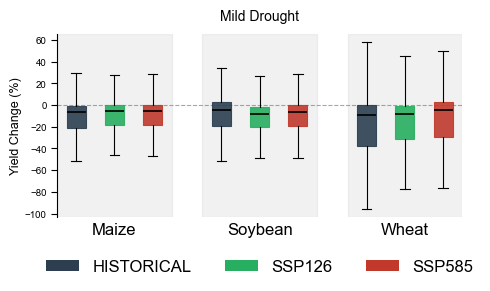

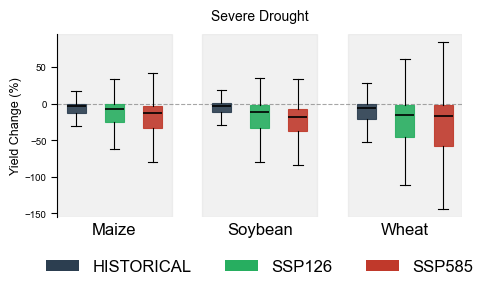

轻度干旱图表已保存至: D:/AAUDE/paper/paper8/fig_level\yield_change_mild_decodes.pdf
重度干旱图表已保存至: D:/AAUDE/paper/paper8/fig_level\yield_change_severe_decodes.pdf


In [63]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba

def plot_mild_drought_boxplot(final_df, save_dir):
    """绘制轻度干旱的箱线图"""
    return _plot_single_drought_type(final_df, 'mild', save_dir)

def plot_severe_drought_boxplot(final_df, save_dir):
    """绘制重度干旱的箱线图"""
    return _plot_single_drought_type(final_df, 'severe', save_dir)
def _plot_single_drought_type(final_df, drought_type, save_dir):
    """内部函数：绘制单一干旱类型的箱线图"""
    mpl.rcParams['pdf.fonttype'] = 42
    # 调整图像大小，宽8cm，高5cm，宽高比适中
    fig, ax = plt.subplots(figsize=(5, 3))  
    
    # 筛选数据
    plot_df = final_df[final_df['SSP'].str.endswith(drought_type)]

    # 参数设置
    n_ssps = len(ssp_colors)
    crops = list(plot_df['Crop'].unique())
    n_crops = len(crops)
    width = 0.5  # 适中箱体宽度，notch更明显
    group_gap = 0.8

    # 计算箱体位置
    positions = []
    for crop_idx in range(n_crops):
        start_pos = crop_idx * (n_ssps + group_gap)
        positions.extend([start_pos + i for i in range(n_ssps)])

    # 准备绘图数据
    plot_data = []
    for crop in crops:
        for ssp in ssp_colors.keys():
            scenario = f"{ssp}_{drought_type}"
            subset = plot_df[(plot_df['Crop'] == crop) & (plot_df['SSP'] == scenario)]
            plot_data.append(subset['Yield Change (%)'].dropna().values)

    # 箱线样式设置
    boxprops = dict(linewidth=0.8, alpha=0.9)
    whiskerprops = dict(linewidth=0.8, linestyle='-')
    capprops = dict(linewidth=0.8)
    medianprops = dict(linewidth=1.2, color='black')

    boxes = ax.boxplot(
        plot_data,
        positions=positions,
        widths=width,
        notch=False,  # 箱体内凹
        patch_artist=True,
        showfliers=False,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        zorder=3
        # whiskerprops=True, 
    )

    # 箱体上色
    for i, box in enumerate(boxes['boxes']):
        ssp = list(ssp_colors.keys())[i % n_ssps]
        rgba = to_rgba(ssp_colors[ssp], alpha=0.6)
        box.set_facecolor(rgba)
        box.set_edgecolor(rgba)

    # 设置 x 轴标签与刻度
    ax.set_xticks([i * (n_ssps + group_gap) + (n_ssps / 2) - 0.5 for i in range(n_crops)])
    ax.set_xticklabels([crop_names[crop] for crop in crops], fontsize=12)

    # 设置 y 轴标签与基准线
    ax.set_ylabel('Yield Change (%)', fontsize=9, labelpad=2)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7, zorder=2)

    # 关闭网格线
    ax.grid(False)

    # 设置边框样式，右侧边框隐藏
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # 设置y轴刻度线，只显示左侧刻度线（主刻度）
    ax.tick_params(axis='y', direction='out', length=4, width=0.8, colors='black')
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(True)  # 左边主刻度线显示
        tick.tick2line.set_visible(False) # 右边刻度线隐藏

    # x轴刻度线全部隐藏
    ax.tick_params(axis='x', which='both', length=0)

    # 背景灰色分组区块
    for crop_idx in range(n_crops):
        start_pos = crop_idx * (n_ssps + group_gap)
        ax.axvspan(start_pos - 0.5, start_pos + n_ssps - 0.5,
                   color='lightgrey', alpha=0.3, zorder=0)

    # 设置标题
    title = 'Mild Drought' if drought_type == 'mild' else 'Severe Drought'
    ax.set_title(title, fontsize=10, pad=10)

    # 添加图例
    legend_elements = [
        patches.Patch(facecolor=color, label=ssp.upper(), edgecolor='none')
        for ssp, color in ssp_colors.items()
    ]
    ax.legend(handles=legend_elements,
              loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              ncol=n_ssps,
              frameon=False,
              fontsize=12)

    plt.tight_layout()

    # 保存路径
    output_path = os.path.join(save_dir, f'yield_change_{drought_type}_decodes.pdf')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

    return output_path


if __name__ == '__main__':
    mild_path = plot_mild_drought_boxplot(final_df, 'D:/AAUDE/paper/paper8/fig_level')
    severe_path = plot_severe_drought_boxplot(final_df, 'D:/AAUDE/paper/paper8/fig_level')
    print(f"轻度干旱图表已保存至: {mild_path}")
    print(f"重度干旱图表已保存至: {severe_path}")


In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 准备容器
all_data = []

for ssp in ssps:
    idx = 33 if ssp == 'historical' else 30
    for crop in crops:
        # 获取基础数据
        expect_yield = (result_dict2[ssp][crop]['expect_yield'])[:-1]
        yied = result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yied = yied.where(yied > 0)
        yield_loss = (yied - expect_yield) / yied * 100

        ssi = result_dict1[ssp][crop]['ssi'][ -idx:]
        spei = result_dict1[ssp][crop]['spei'][ -idx:]
        spei['time'] = yied.time.values
        ssi['time'] = yied.time.values

        for drought_type, mask_expr in {
            'mild':  ((ssi < -0.42) & (ssi > -0.54)),
            'severe': (spei < -0.54) | (ssi < -0.54),
            'drought': (spei < -0.42) | (ssi < -0.42)
            }.items():
            drought_mask = mask_expr
            # 产量变化
            yield_change_drought = yield_loss.where(drought_mask).mean(dim='time')
            # yield_change_drought = yield_change_drought.where(abs(yield_change_drought) < 200)
            yield_change_drought = yield_change_drought.where(yield_change_drought!=0)
            # 损失强度
            loss_intensity = yield_loss.where((yield_loss < 0) & drought_mask).mean(dim='time')
            # loss_intensity = loss_intensity.where(abs(loss_intensity) < 200)
            loss_intensity = loss_intensity.where(loss_intensity!=0)

            # 转为 DataFrame 并加入容器
            data_df = pd.DataFrame({
                'Yield Change (%)': yield_change_drought.values.flatten()/1,
                'Loss Intensity (%)': loss_intensity.values.flatten()/1
            })
            data_df['SSP'] = ssp
            data_df['Crop'] = crop
            data_df['Drought'] = drought_type
            data_df['SSP'] = f"{ssp}_{drought_type}"

            all_data.append(data_df)

# 合并
final_df = pd.concat(all_data, ignore_index=True)

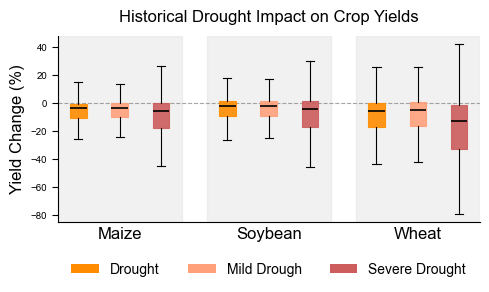

历史情景干旱图表已保存至: D:/AAUDE/paper/paper8/fig_level\yield_change_historical_all_droughts.pdf


In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import to_rgba

def plot_historical_drought_boxplot(final_df, save_dir):
    """绘制历史情景下所有干旱类型的箱线图"""
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    # 调整图像大小
    fig, ax = plt.subplots(figsize=(5, 3))  
    
    # 筛选历史数据
    plot_df = final_df[final_df['SSP'].str.startswith('historical')]
    
    # 参数设置
    drought_types = ['drought', 'mild', 'severe']  # 添加了新的drought类型
    n_drought_types = len(drought_types)
    crops = list(plot_df['Crop'].unique())
    n_crops = len(crops)
    width = 0.4  # 箱体宽度
    group_gap = 0.6
    
    # 颜色设置 - 为三种干旱类型设置不同颜色
    drought_colors = {
        'drought': '#FF8C00',
        'mild': '#FFA07A',    # 轻度干旱 (浅橙色)
          # 一般干旱 (深橙色)
        'severe': '#CD5C5C'    # 重度干旱 (深红色)
    }
    
    # 计算箱体位置
    positions = []
    for crop_idx in range(n_crops):
        start_pos = crop_idx * (n_drought_types + group_gap)
        positions.extend([start_pos + i for i in range(n_drought_types)])
    
    # 准备绘图数据
    plot_data = []
    for crop in crops:
        for dtype in drought_types:
            scenario = f"historical_{dtype}"
            subset = plot_df[(plot_df['Crop'] == crop) & (plot_df['SSP'] == scenario)]
            plot_data.append(subset['Yield Change (%)'].dropna().values)
    
    # 箱线样式设置
    boxprops = dict(linewidth=0.8, alpha=0.9)
    whiskerprops = dict(linewidth=0.8, linestyle='-')
    capprops = dict(linewidth=0.8)
    medianprops = dict(linewidth=1.2, color='black')
    
    boxes = ax.boxplot(
        plot_data,
        positions=positions,
        widths=width,
        notch=False,
        patch_artist=True,
        showfliers=False,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        zorder=3
    )
    
    # 箱体上色
    for i, box in enumerate(boxes['boxes']):
        dtype = drought_types[i % n_drought_types]
        rgba = to_rgba(drought_colors[dtype], alpha=0.8)
        box.set_facecolor(rgba)
        box.set_edgecolor(rgba)
    
    # 设置 x 轴标签与刻度
    ax.set_xticks([i * (n_drought_types + group_gap) + (n_drought_types / 2) - 0.5 for i in range(n_crops)])
    ax.set_xticklabels([crop_names[crop] for crop in crops], fontsize=12)
    
    # 设置 y 轴标签与基准线
    ax.set_ylabel('Yield Change (%)', fontsize=12)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7, zorder=2)
    
    # 关闭网格线
    ax.grid(False)
    
    # 设置边框样式
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(0.8)
        ax.spines[spine].set_color('black')
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
    
    # 设置刻度线
    ax.tick_params(axis='y', direction='out', length=4, width=0.8, colors='black')
    ax.tick_params(axis='x', which='both', length=0)
    
    # 背景灰色分组区块
    for crop_idx in range(n_crops):
        start_pos = crop_idx * (n_drought_types + group_gap)
        ax.axvspan(start_pos - 0.5, start_pos + n_drought_types - 0.5,
                   color='lightgrey', alpha=0.3, zorder=0)
    
    # 设置标题
    ax.set_title('Historical Drought Impact on Crop Yields', fontsize=12, pad=10)
    
    # 添加图例
    legend_elements = [
        patches.Patch(facecolor=drought_colors['drought'], label='Drought', edgecolor='none'),
        patches.Patch(facecolor=drought_colors['mild'], label='Mild Drough', edgecolor='none'),
        
        patches.Patch(facecolor=drought_colors['severe'], label='Severe Drought', edgecolor='none')
    ]
    ax.legend(handles=legend_elements,
              loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              ncol=3,
              frameon=False,
              fontsize=10)
    
    plt.tight_layout()
    
    # 保存路径
    output_path = os.path.join(save_dir, 'yield_change_historical_all_droughts.pdf')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()
    
    return output_path


if __name__ == '__main__':
    # 假设已经定义了 crop_names 和运行了前面的代码得到 final_df
    crop_names = {
        'mai': 'Maize',
        # 'rice': 'Rice',
        'soy': 'Soybean',
        'whe': 'Wheat'
    }
    
    combined_path = plot_historical_drought_boxplot(final_df, 'D:/AAUDE/paper/paper8/fig_level')
    print(f"历史情景干旱图表已保存至: {combined_path}")

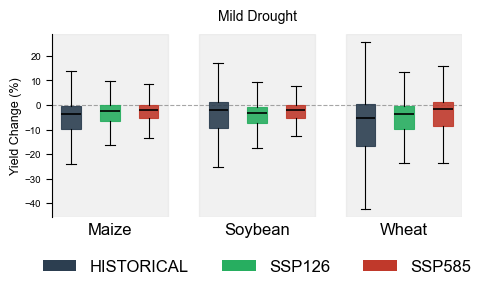

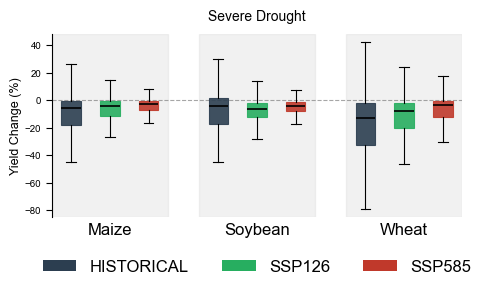

轻度干旱图表已保存至: D:/AAUDE/paper/paper8/fig_level\yield_change_mild.pdf
重度干旱图表已保存至: D:/AAUDE/paper/paper8/fig_level\yield_change_severe.pdf


In [67]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba

def plot_mild_drought_boxplot(final_df, save_dir):
    """绘制轻度干旱的箱线图"""
    return _plot_single_drought_type(final_df, 'mild', save_dir)

def plot_severe_drought_boxplot(final_df, save_dir):
    """绘制重度干旱的箱线图"""
    return _plot_single_drought_type(final_df, 'severe', save_dir)
def _plot_single_drought_type(final_df, drought_type, save_dir):
    """内部函数：绘制单一干旱类型的箱线图"""
    mpl.rcParams['pdf.fonttype'] = 42
    # 调整图像大小，宽8cm，高5cm，宽高比适中
    fig, ax = plt.subplots(figsize=(5, 3))  
    
    # 筛选数据
    plot_df = final_df[final_df['SSP'].str.endswith(drought_type)]

    # 参数设置
    n_ssps = len(ssp_colors)
    crops = list(plot_df['Crop'].unique())
    n_crops = len(crops)
    width = 0.5  # 适中箱体宽度，notch更明显
    group_gap = 0.8

    # 计算箱体位置
    positions = []
    for crop_idx in range(n_crops):
        start_pos = crop_idx * (n_ssps + group_gap)
        positions.extend([start_pos + i for i in range(n_ssps)])

    # 准备绘图数据
    plot_data = []
    for crop in crops:
        for ssp in ssp_colors.keys():
            scenario = f"{ssp}_{drought_type}"
            subset = plot_df[(plot_df['Crop'] == crop) & (plot_df['SSP'] == scenario)]
            plot_data.append(subset['Yield Change (%)'].dropna().values)

    # 箱线样式设置
    boxprops = dict(linewidth=0.8, alpha=0.9)
    whiskerprops = dict(linewidth=0.8, linestyle='-')
    capprops = dict(linewidth=0.8)
    medianprops = dict(linewidth=1.2, color='black')

    boxes = ax.boxplot(
        plot_data,
        positions=positions,
        widths=width,
        notch=False,  # 箱体内凹
        patch_artist=True,
        showfliers=False,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        zorder=3
        # whiskerprops=True, 
    )

    # 箱体上色
    for i, box in enumerate(boxes['boxes']):
        ssp = list(ssp_colors.keys())[i % n_ssps]
        rgba = to_rgba(ssp_colors[ssp], alpha=0.6)
        box.set_facecolor(rgba)
        box.set_edgecolor(rgba)

    # 设置 x 轴标签与刻度
    ax.set_xticks([i * (n_ssps + group_gap) + (n_ssps / 2) - 0.5 for i in range(n_crops)])
    ax.set_xticklabels([crop_names[crop] for crop in crops], fontsize=12)

    # 设置 y 轴标签与基准线
    ax.set_ylabel('Yield Change (%)', fontsize=9, labelpad=2)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7, zorder=2)

    # 关闭网格线
    ax.grid(False)

    # 设置边框样式，右侧边框隐藏
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # 设置y轴刻度线，只显示左侧刻度线（主刻度）
    ax.tick_params(axis='y', direction='out', length=4, width=0.8, colors='black')
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(True)  # 左边主刻度线显示
        tick.tick2line.set_visible(False) # 右边刻度线隐藏

    # x轴刻度线全部隐藏
    ax.tick_params(axis='x', which='both', length=0)

    # 背景灰色分组区块
    for crop_idx in range(n_crops):
        start_pos = crop_idx * (n_ssps + group_gap)
        ax.axvspan(start_pos - 0.5, start_pos + n_ssps - 0.5,
                   color='lightgrey', alpha=0.3, zorder=0)

    # 设置标题
    title = 'Mild Drought' if drought_type == 'mild' else 'Severe Drought'
    ax.set_title(title, fontsize=10, pad=10)

    # 添加图例
    legend_elements = [
        patches.Patch(facecolor=color, label=ssp.upper(), edgecolor='none')
        for ssp, color in ssp_colors.items()
    ]
    ax.legend(handles=legend_elements,
              loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              ncol=n_ssps,
              frameon=False,
              fontsize=12)

    plt.tight_layout()

    # 保存路径
    output_path = os.path.join(save_dir, f'yield_change_{drought_type}.pdf')
    # plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

    return output_path

crop_names = {
        'mai': 'Maize',
        'soy': 'Soybean',
        'whe': 'Wheat'
    }
if __name__ == '__main__':
    mild_path = plot_mild_drought_boxplot(final_df, 'D:/AAUDE/paper/paper8/fig_level')
    severe_path = plot_severe_drought_boxplot(final_df, 'D:/AAUDE/paper/paper8/fig_level')
    print(f"轻度干旱图表已保存至: {mild_path}")
    print(f"重度干旱图表已保存至: {severe_path}")


### single 

Processing SSPs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

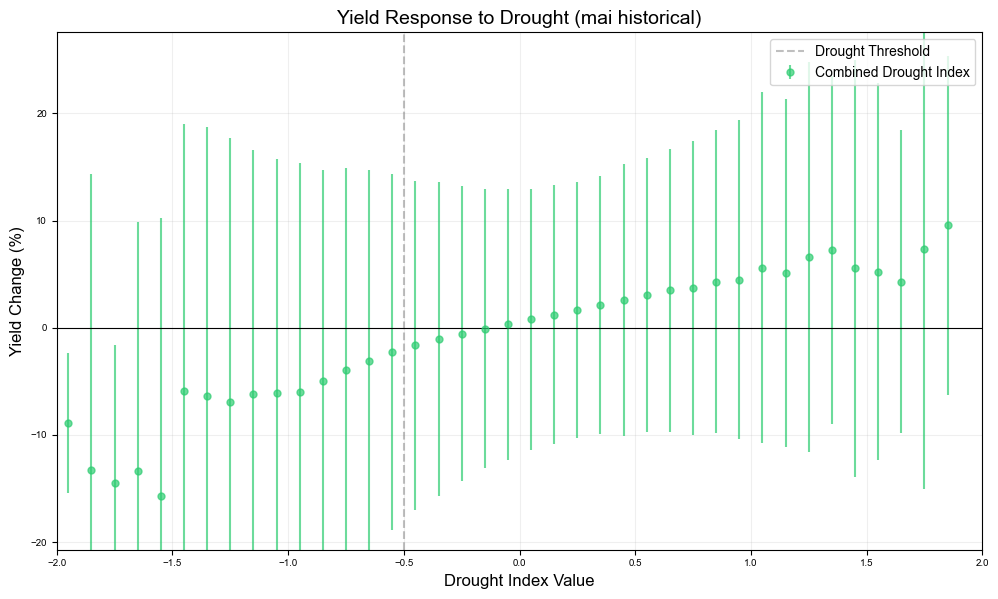

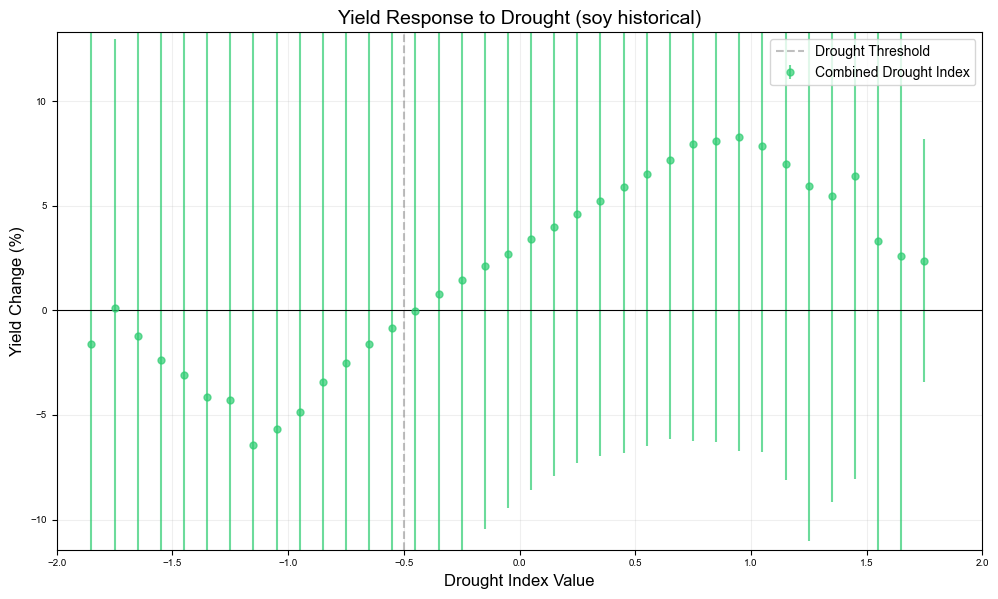

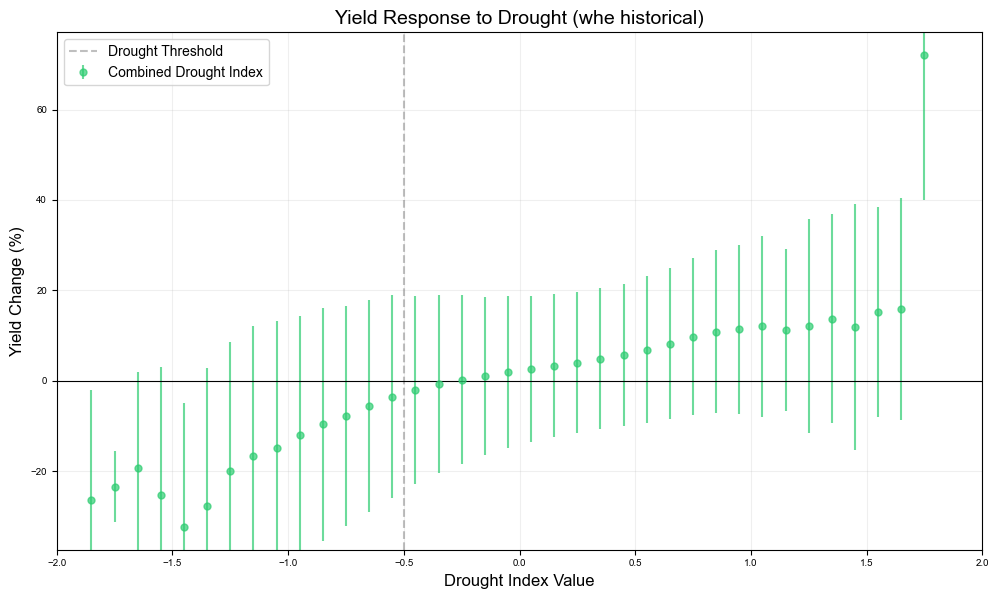

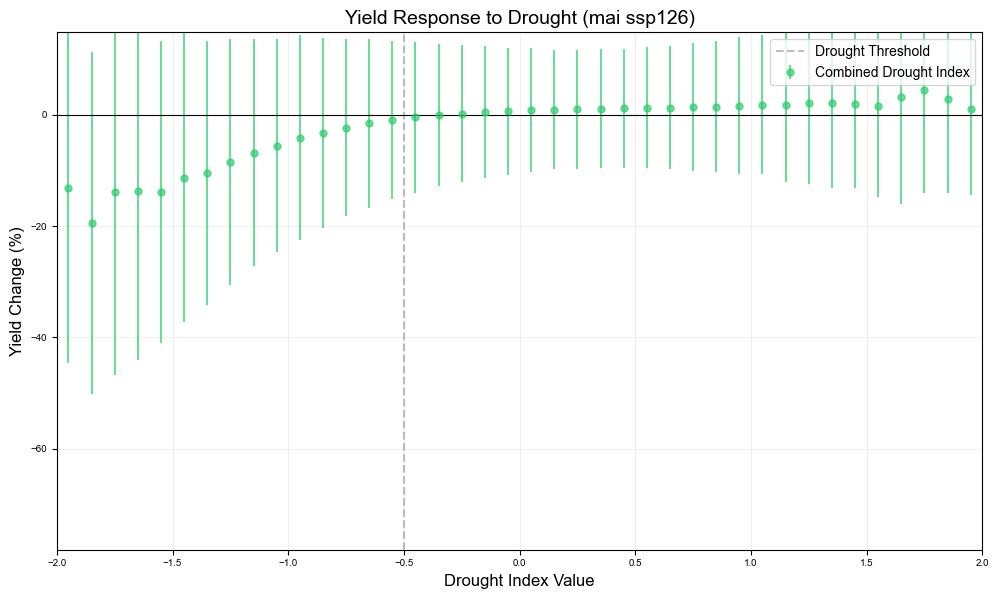

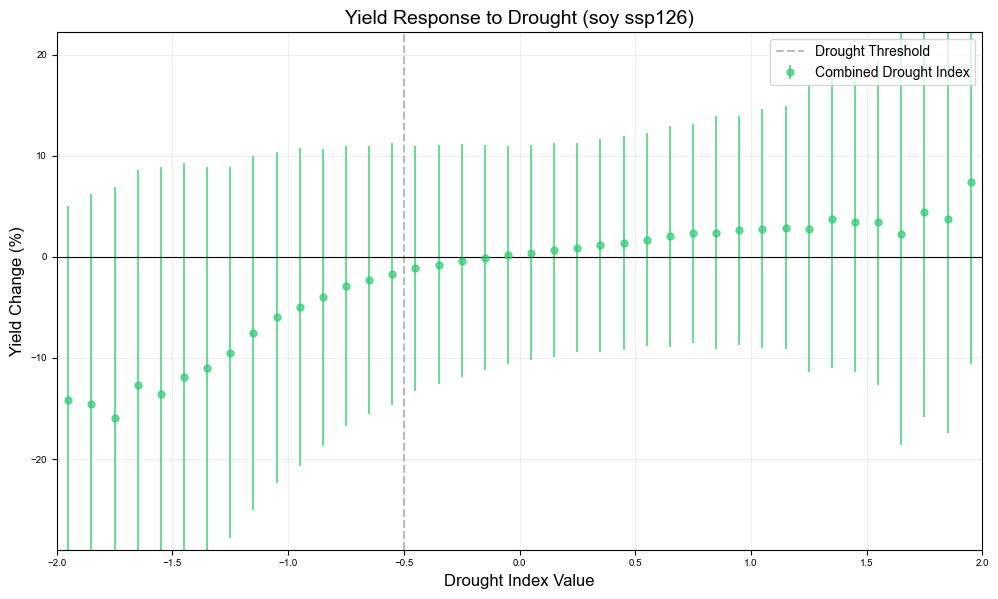

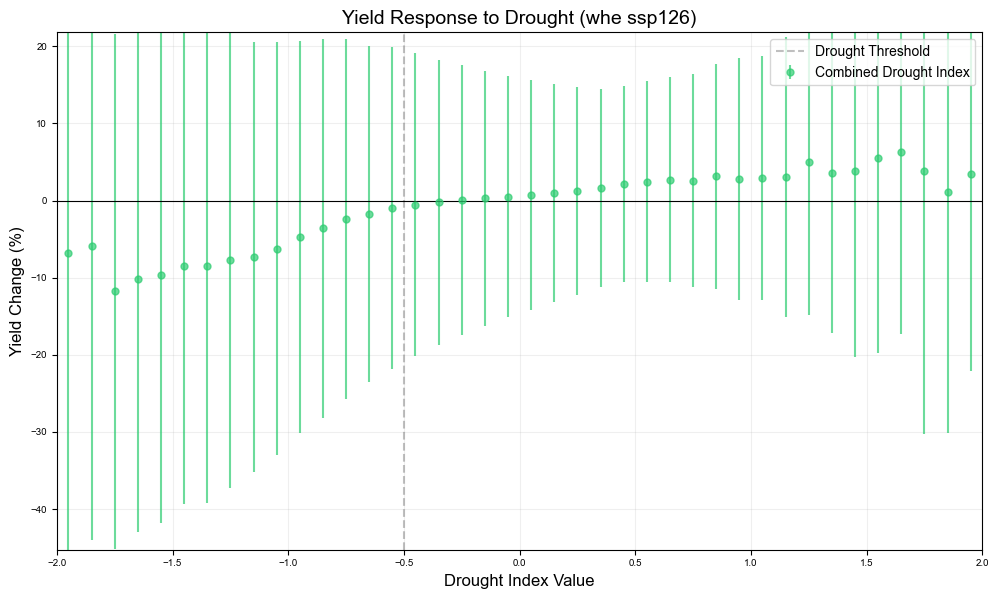

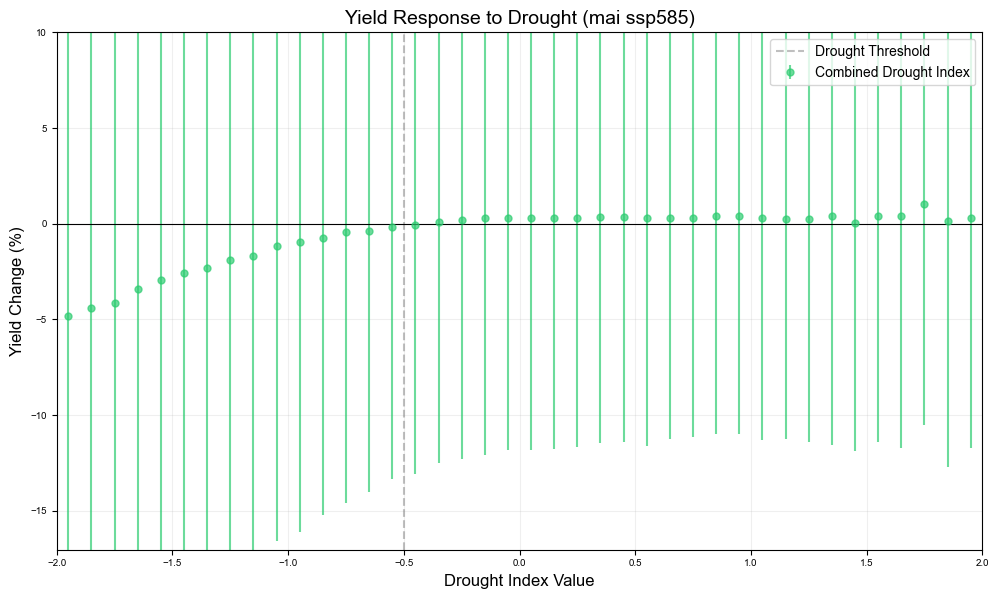

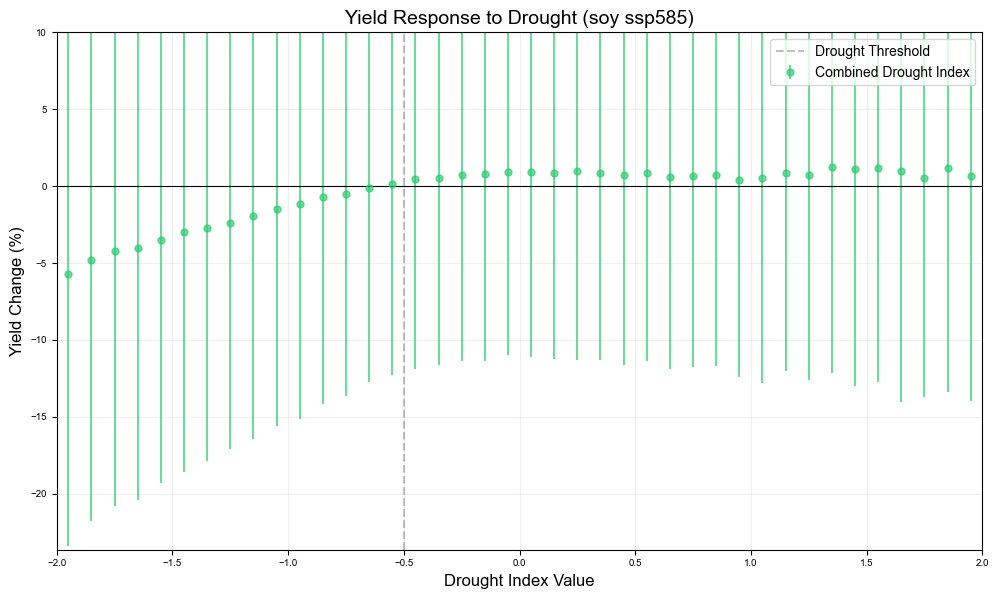

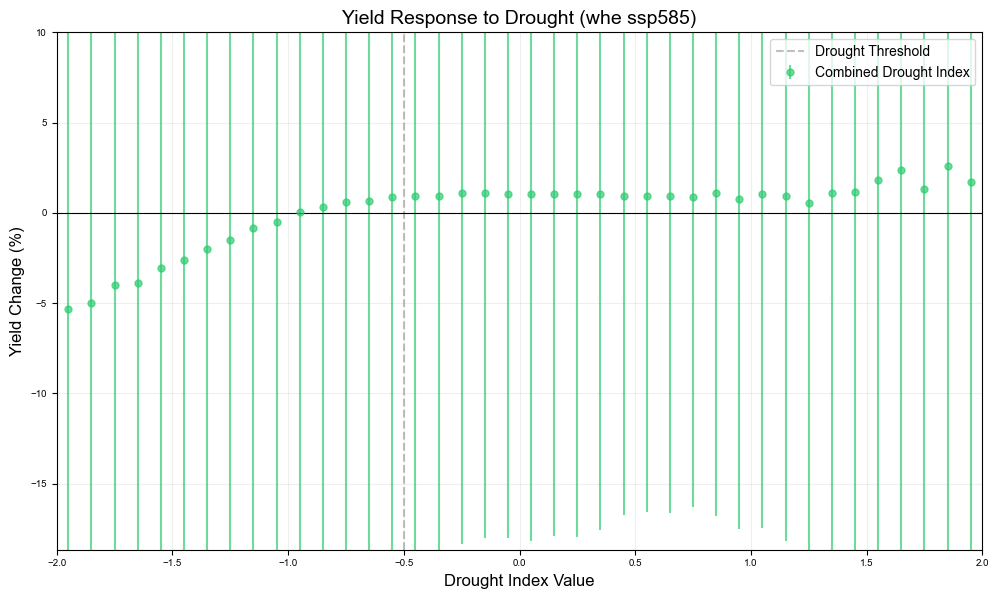


示例统计结果:

mai historical 在-1.0~-0.9区间:
样本数: 7638
平均产量变化: -5.99%
标准差: 21.33


In [80]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # 用于显示进度

# 设置绘图风格
sns.set_palette("husl")
plt.rcParams['font.family'] = 'Arial'

def analyze_drought_bins(result_dict1, result_dict2, bins=np.arange(-3, 3, 0.1)):
    """分析不同干旱区间下的产量变化（合并SSI和SPEI）"""
    results = {}
    
    for ssp in tqdm(ssps, desc='Processing SSPs'):
        results[ssp] = {}
        idx = 33 if ssp == 'historical' else 30  # 时间长度
        
        for crop in tqdm(crops, desc='Processing Crops', leave=False):
            try:
                # 加载主导类型数据
                dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
                
                # 准备产量数据
                expect_yield = result_dict2[ssp][crop]['expect_yield'][:-1]
                yied = result_dict1[ssp][crop]['yield'][-idx:]
                expect_yield = expect_yield[-idx:]
                yied = yied.where(yied > 0)
                yield_loss = (yied - expect_yield) / yied * 100
                
                # 获取干旱指数数据（合并SSI和SPEI）
                ssi = result_dict1[ssp][crop]['ssi'][ -idx:]
                spei = result_dict1[ssp][crop]['spei'][ -idx:]
                
                # 应用筛选条件
                mask = (abs(yield_loss) < 100) 
                ssi = ssi.where(mask)
                spei = spei.where(mask)
                yield_loss = yield_loss.where(mask)
                
                # 初始化结果存储
                results[ssp][crop] = {
                    'bins': [],
                    'yield_mean': [],
                    'yield_std': [],
                    'count': []
                }
                
                # 分析每个区间
                for i in tqdm(range(len(bins)-1), desc='Processing Bins', leave=False):
                    lower, upper = bins[i], bins[i+1]
                    
                    # 筛选当前区间的数据
                    di_mask = ((spei >= lower) & (spei < upper))|((ssi >= lower) & (ssi < upper))
                    yl_values = yield_loss.where(di_mask).values
                    yl_values = yl_values[~np.isnan(yl_values)]
                    
                    # 存储结果
                    results[ssp][crop]['bins'].append((lower + upper)/2)
                    results[ssp][crop]['yield_mean'].append(np.median(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['yield_std'].append(np.std(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['count'].append(len(yl_values))
                    
            except Exception as e:
                print(f"Error processing {ssp}-{crop}: {str(e)}")
                continue
                
    return results

def plot_combined_response(results, crop, ssp):
    """绘制合并的干旱响应曲线"""
    if ssp not in results or crop not in results[ssp]:
        print(f"No data for {crop}-{ssp}")
        return
    
    data = results[ssp][crop]
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制响应曲线（合并SSI和SPEI）
    plt.errorbar(data['bins'], data['yield_mean'], 
                yerr=data['yield_std'], fmt='o', markersize=5,
                color='#2ecc71', alpha=0.7, 
                label='Combined Drought Index')
    
    # 图形装饰
    plt.title(f'Yield Response to Drought ({crop} {ssp})', fontsize=14)
    plt.xlabel('Drought Index Value', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.5, label='Drought Threshold')
    plt.axhline(y=0, color='black', linewidth=0.8)
    
    # 设置坐标范围
    plt.xlim(-2, 2)
    y_min = np.nanmin(data['yield_mean']) - 5
    y_max = np.nanmax(data['yield_mean']) + 5
    plt.ylim(y_min, max(y_max, 10))  # 限制y轴最大值
    
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    
    # 显示并保存图形
    plt.tight_layout()
    # save_path = f'{save_dir}/{crop}_{ssp}_combined_drought_response.png'
    plt.show()
    plt.close()
    # print(f"Saved to {save_path}")

# 运行分析
if __name__ == '__main__':
    bins = np.arange(-3, 3, 0.1)
    
    # 运行分析（合并SSI和SPEI）
    results = analyze_drought_bins(result_dict1, result_dict2, bins)
    
    # 为每个作物和情景绘制图形
    for ssp in ssps:
        for crop in crops:
            plot_combined_response(results, crop, ssp)
    
    # 打印统计结果示例
    print("\n示例统计结果:")
    ssp_example = ssps[0]
    crop_example = crops[0]
    if ssp_example in results and crop_example in results[ssp_example]:
        data = results[ssp_example][crop_example]
        print(f"\n{crop_example} {ssp_example} 在-1.0~-0.9区间:")
        idx = np.where((np.array(data['bins']) >= -1.0) & (np.array(data['bins']) < -0.9))[0]
        if len(idx) > 0:
            idx = idx[0]
            print(f"样本数: {data['count'][idx]}")
            print(f"平均产量变化: {data['yield_mean'][idx]:.2f}%")
            print(f"标准差: {data['yield_std'][idx]:.2f}")

In [7]:
import xarray as xr
from os.path import join
import numpy as np
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
exps=['default','2015co2']
# var='ssi'
result_dict1 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps 
}
def change(data,yied,ssp):
    data = data[1:].rename({'year': 'time'})
    # if ssp == 'historical':
    data['time']=yied.time.values
    return data.where(np.isfinite(data))

for exp in exps:
    if exp =='2015co2' :
        continue
    for ssp in ssps:
        
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    ssi_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    spei_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr'][-len(ssi_data_wwh):-1]
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr'][-len(ssi_data_wwh):-1]
                    ssi_data_wwh=change(ssi_data_wwh,yied_wwh,ssp)
                    ssi_data_swh=change(ssi_data_swh,yied_wwh,ssp)
                    spei_data_swh=change(spei_data_swh,yied_wwh,ssp)
                    spei_data_wwh=change(spei_data_wwh,yied_wwh,ssp)
                    
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[ssp][crop]['yield'] =yied.where(yied!=0)
                    result_dict1[ssp][crop]['spei'] = spei.where(spei!=0)
                    result_dict1[ssp][crop]['ssi'] = ssi.where(ssi!=0)
                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                # try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr'][-len(ssi_data):-1]
                    ssi_data=change(ssi_data,yied,ssp)
                    spei_data=change(spei_data,yied,ssp)
                    result_dict1[ssp][crop]['yield'] =yied.where(area>0)
                    result_dict1[ssp][crop]['spei'] = spei_data.where(area>0)
                    result_dict1[ssp][crop]['ssi'] = ssi_data.where(area>0)


In [6]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    ssp: {
            crop: {} for crop in crops
    } for ssp in ssps
}
exps=['default','2015co2']
for exp in exps:
    if exp =='2015co2' :
        continue
    for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'expected_yield_wwh_{ssp}_{exp}_v2.nc'))[f'expected_yield'].fillna(0)+\
                 xr.open_dataset(join(fp, f'expected_yield_swh_{ssp}_{exp}_v2.nc'))[f'expected_yield'].fillna(0)
                p_value= xr.open_dataset(join(fp, f'expected_yield_swh_{ssp}_{exp}_v2.nc'))[f'p_value']+\
                xr.open_dataset(join(fp, f'expected_yield_wwh_{ssp}_{exp}_v2.nc'))[f'p_value']
                
                result_dict2[ssp][crop]['expect_yield'] =yied.where(yied!=0)
                result_dict2[ssp][crop]['p_value'] = p_value.where(p_value!=0)
    
            else:
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_{exp}_v2.nc'))[f'expected_yield']
                p_value= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_{exp}_v2.nc'))[f'p_value']
                result_dict2[ssp][crop]['expect_yield'] =yied
                result_dict2[ssp][crop]['p_value'] = p_value

In [27]:
result_dict2[ssp][crop]['expect_yield'][-30:]

<xarray.DataArray 'expected_yield' (time: 30, lat: 360, lon: 720)> Size: 31MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 240B 2071-01-01 2072-01-01 ... 2100-01-01
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

In [111]:
idx=30
dominant_type = xr.open_dataset(f"D:/AAUDE/paper/paper8/data/copula/impact_type_{crop}_{ssp}.nc").impact_type

# 准备产量数据
expect_yield = result_dict2[ssp][crop]['expect_yield'][:-1]
yied = result_dict1[ssp][crop]['yield'][-idx:]
expect_yield = expect_yield[-idx:]
expect_yield['time'] = yied.time.values
yied = yied.where(yied > 0)
yield_loss = (yied - expect_yield) / expect_yield * 100

# 获取干旱指数数据（合并SSI和SPEI）
ssi = result_dict1[ssp][crop]['ssi'][ -idx:]
ssi['time'] = yied.time.values

# 应用筛选条件
mask = (abs(yield_loss) < 100) & (dominant_type ==1)

In [105]:
result_dict1[ssp][crop]['yield'][:,120,505]

<xarray.DataArray (time: 84)> Size: 672B
array([9.14999992e-02, 1.61699995e-01, 1.40000001e-01, 3.61813953e-01,
       2.28399999e-01, 4.14000005e-01, 1.19999997e-01, 5.83487749e-01,
       3.24679673e-01, 8.49362314e-02, 3.58000010e-01, 3.88999999e-01,
       1.06449824e-01, 2.74250008e-01, 1.28999993e-01, 6.12000000e-01,
       4.97000009e-01, 1.75999999e-01, 6.59664632e-01, 6.70000017e-01,
       1.58294261e-01, 3.79999995e-01, 4.43000004e-01, 5.72000000e-01,
       2.96999991e-01, 9.27080177e-02, 1.61100000e-01, 2.36999996e-01,
       1.70000002e-01, 1.51000000e-01, 2.70000011e-01, 1.79638237e-01,
       8.90720598e-02, 2.98299998e-01, 3.19315046e-01, 2.63000000e-01,
       1.12000003e-01, 1.44207853e-01, 8.64670649e-02, 8.54050070e-02,
       3.26000005e-01, 2.77500004e-02, 9.52038495e-03, 9.09999982e-02,
       2.96999991e-01, 1.67481940e-01, 1.35999998e-01, 4.49000001e-01,
       7.96311796e-02, 1.94000001e-01, 7.97373354e-02, 8.46769139e-02,
       2.86899999e-01, 8.24903697e-02, 2.11540803e-01, 8.73007588e-02,
       8.40805098e-02, 4.39999998e-02, 1.40000000e-02, 8.01635310e-02,
       3.50014135e-03, 1.74999996e-02, 3.21000010e-01, 8.30565169e-02,
       8.54195431e-02, 8.07006434e-02, 8.00000038e-03, 8.36210139e-02,
       8.30473267e-02, 5.00000007e-02, 7.95347728e-02, 1.25448815e-06,
       8.26825574e-02, 1.08000003e-01, 8.23808387e-02, 7.95679241e-02,
       1.60000008e-02, 5.93406148e-04, 2.80001186e-02, 8.17135945e-02,
       8.83249679e-30,            nan,            nan, 1.59059316e-01])
Coordinates:
    lon      float64 8B 72.75
    lat      float64 8B 29.75
  * time     (time) datetime64[ns] 672B 2016-01-01 2017-01-01 ... 2099-01-01

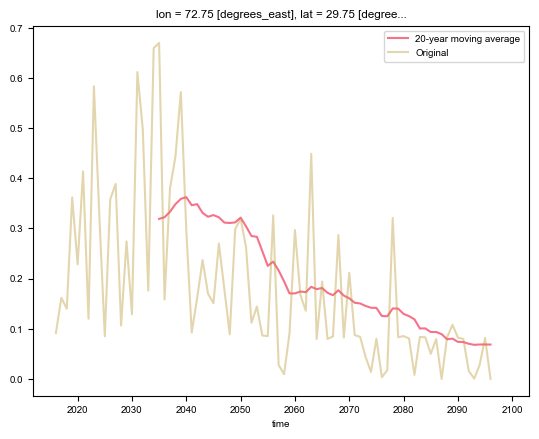

In [110]:
# 假设窗口大小为5年，center=True表示窗口居中
window_size = 20
result_dict1[ssp][crop]['yield'][:, 120, 505]\
    .rolling(time=window_size).mean().plot(label=f'{window_size}-year moving average')


# 如果需要原始曲线一起画
result_dict1[ssp][crop]['yield'][:, 120, 505]\
    .plot(alpha=0.4, label='Original')

plt.legend()
plt.show()


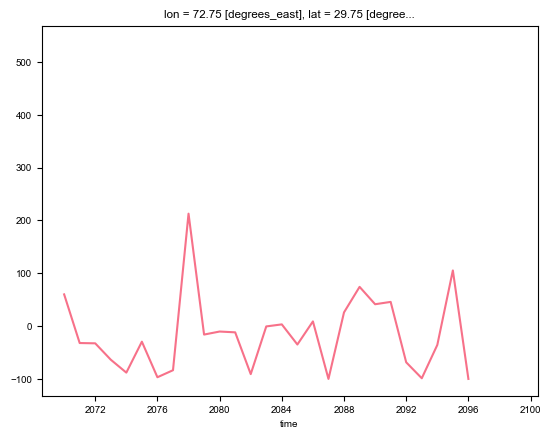

In [114]:
# result_dict1[ssp][crop]['yield'][:,120,505].plot()
yield_loss[:,120,505].plot()
# result_dict2[ssp][crop]['expect_yield'][:,120,505].plot()

In [97]:
# 找到最小值的扁平索引
min_idx = yield_loss.argmin(dim=None)

# 将扁平索引转为各个维度的索引
dim_indices = np.unravel_index(min_idx.item(), yield_loss.shape)

# 对应每个维度的索引位置
index_dict = {dim: idx for dim, idx in zip(yield_loss.dims, dim_indices)}

print("最小值索引位置：", index_dict)


最小值索引位置： {'time': 26, 'lat': 120, 'lon': 505}


Processing SSPs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/59 [00:00<?, ?it/s]

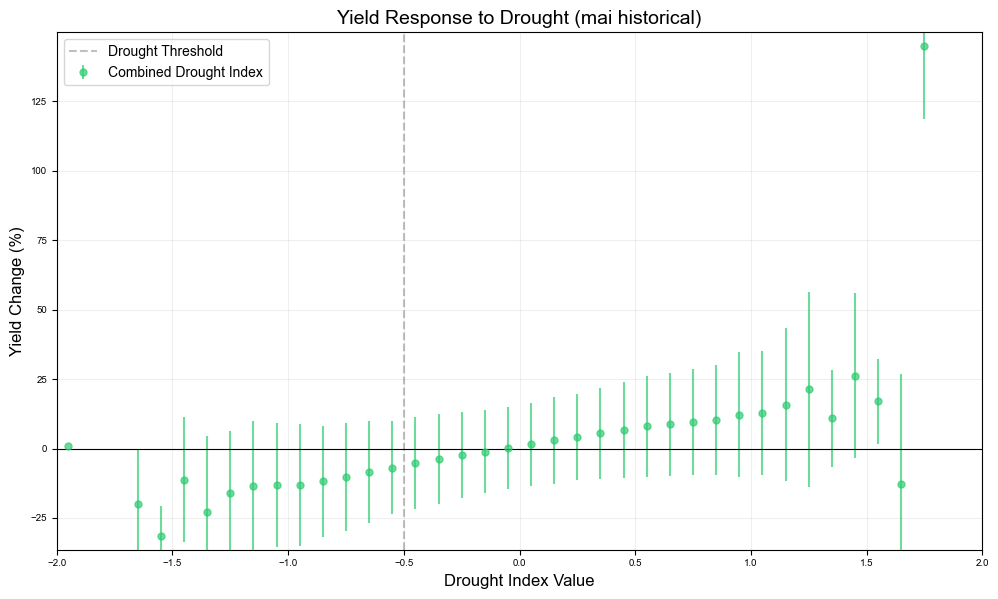

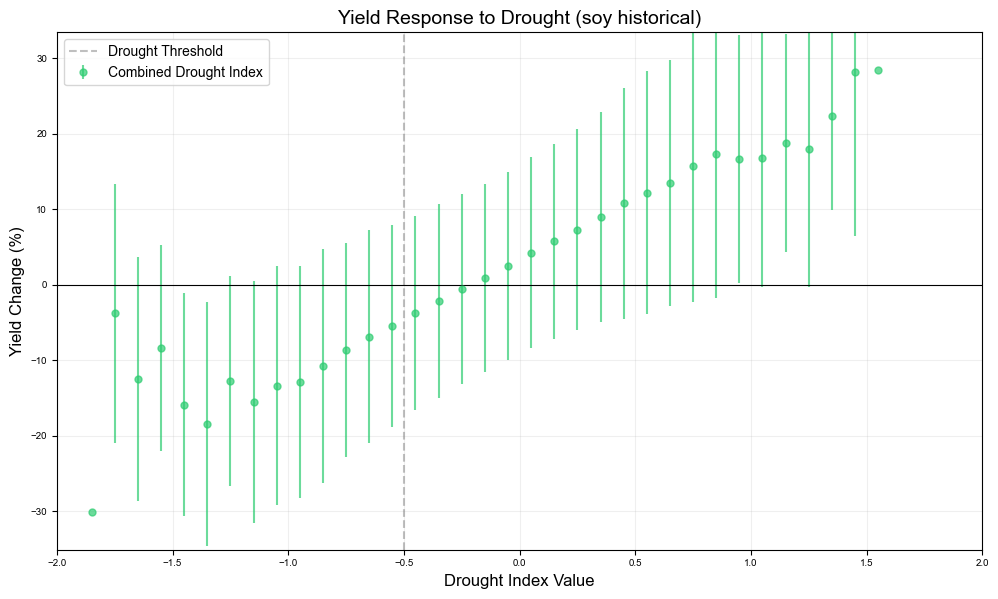

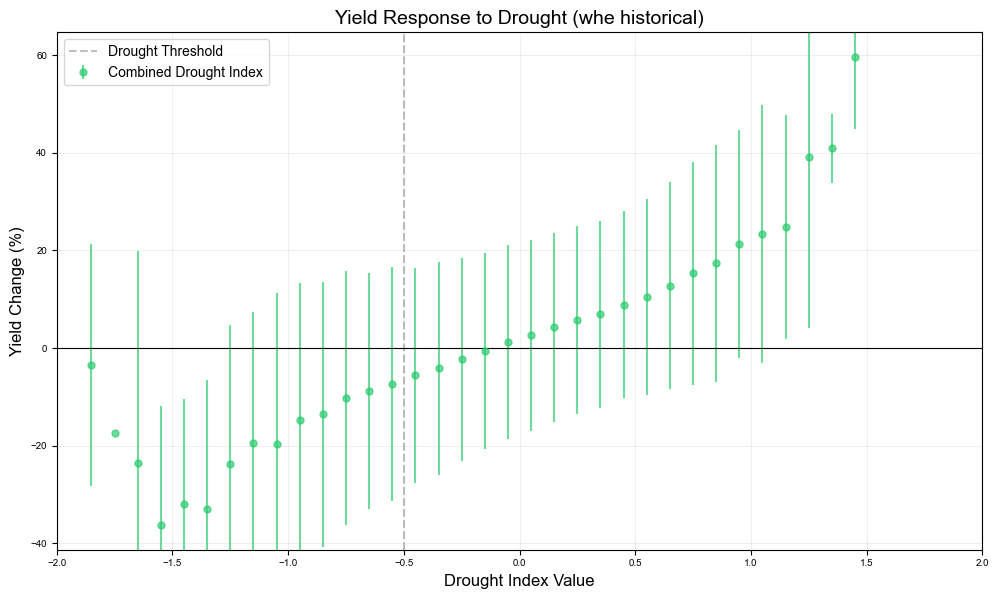

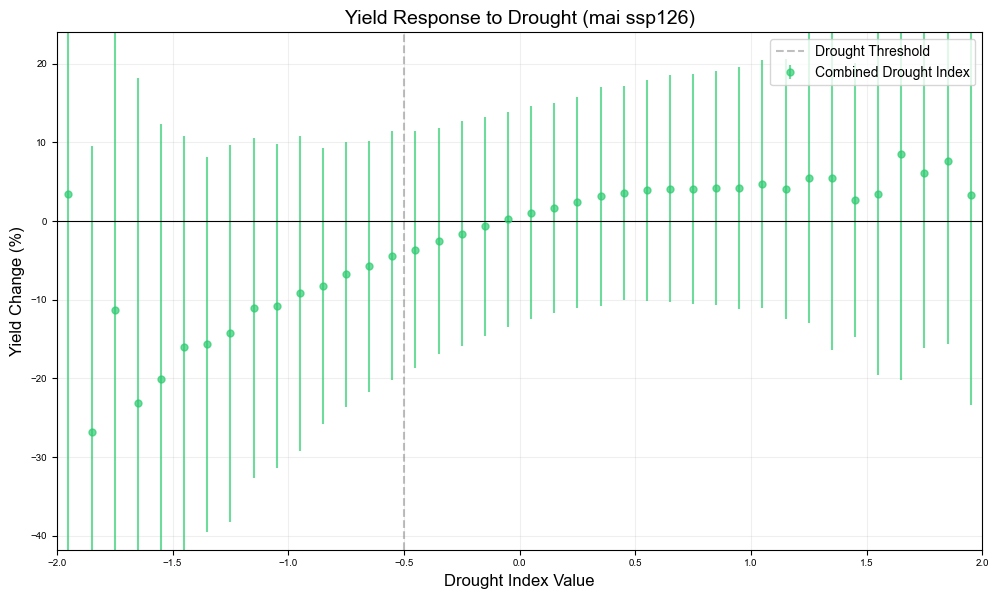

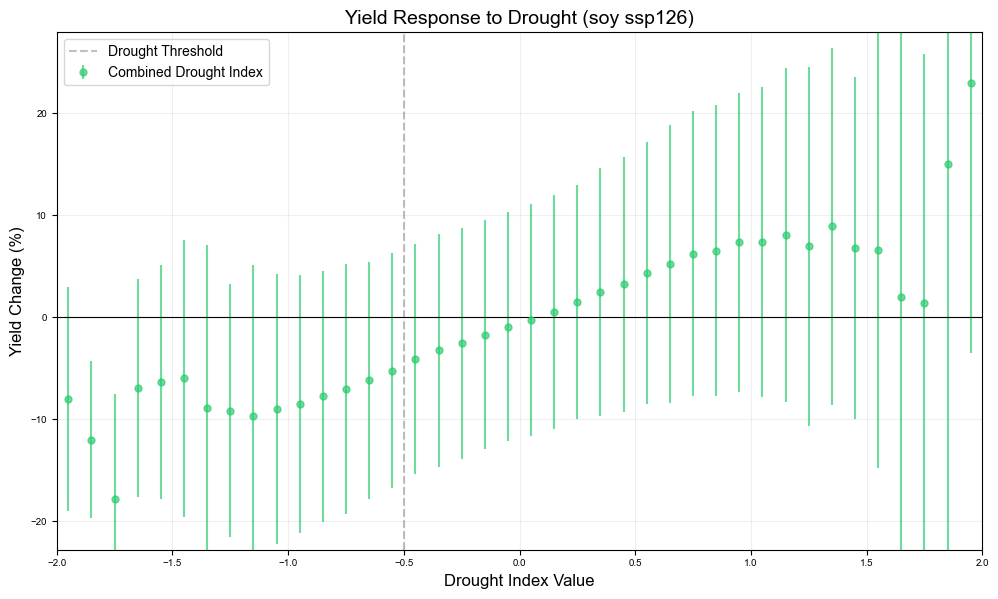

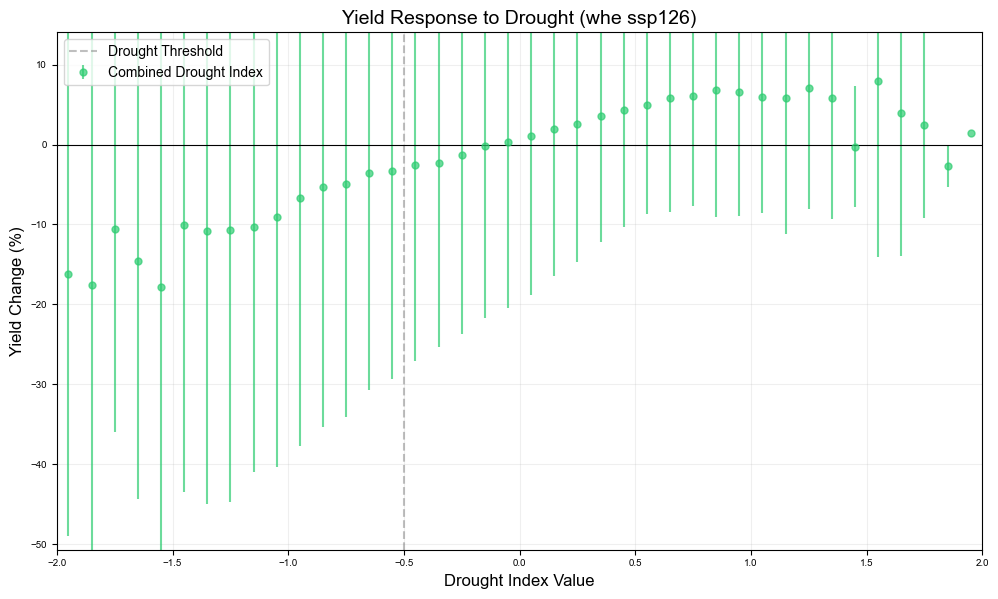

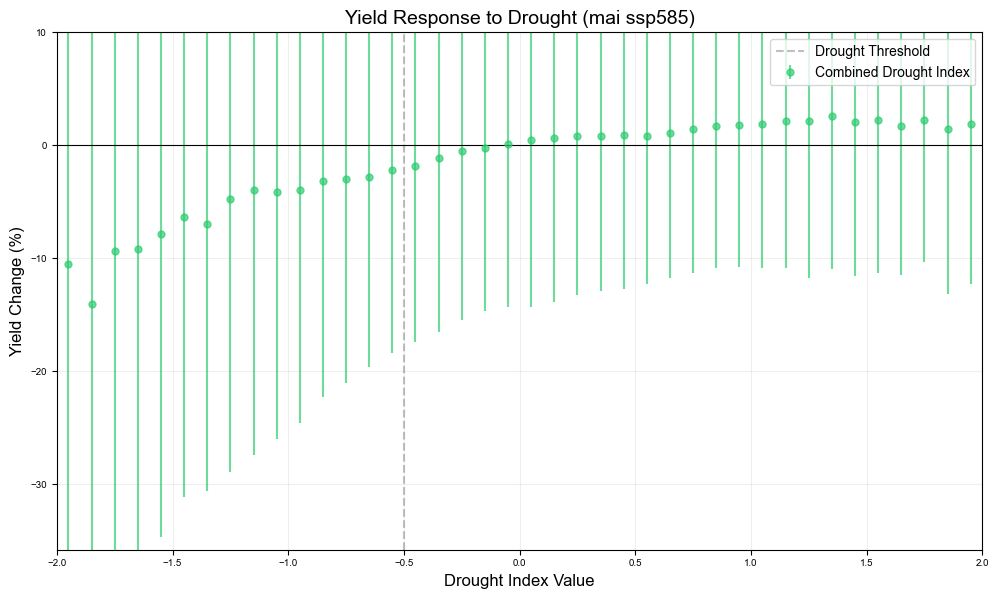

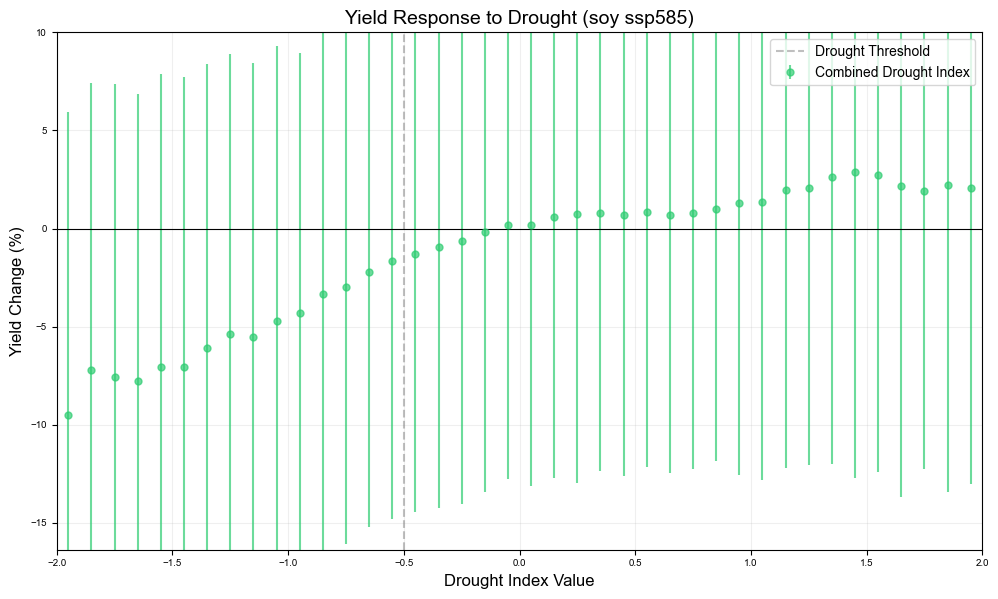

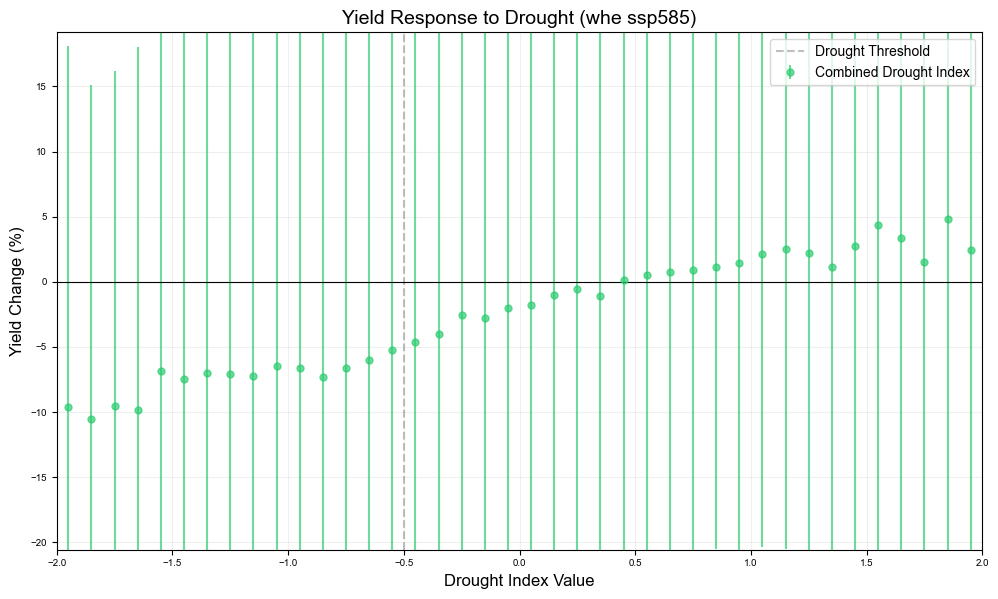

In [122]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # 用于显示进度

# 设置绘图风格
sns.set_palette("husl")
plt.rcParams['font.family'] = 'Arial'

def analyze_drought_bins(result_dict1, result_dict2, bins=np.arange(-3, 3, 0.1)):
    """分析不同干旱区间下的产量变化（合并SSI和SPEI）"""
    results = {}
    
    for ssp in tqdm(ssps, desc='Processing SSPs'):
        results[ssp] = {}
        idx = 33 if ssp == 'historical' else 30  # 时间长度
        
        for crop in tqdm(crops, desc='Processing Crops', leave=False):
            # try:
                # 加载主导类型数据
                dominant_type = xr.open_dataset(f"D:/AAUDE/paper/paper8/data/copula/impact_type_{crop}_{ssp}.nc").impact_type
                
                # 准备产量数据
                expect_yield = result_dict2[ssp][crop]['expect_yield'][:-1]
                yied = result_dict1[ssp][crop]['yield'][-idx:]
                expect_yield = expect_yield[-idx:]
                yied = yied.where(yied > 0)
                yield_loss = (yied - expect_yield) / expect_yield * 100
                ssi = result_dict1[ssp][crop]['ssi'][ -idx:]
                
                # 应用筛选条件
                mask = (abs(yield_loss) < 200) & (dominant_type ==1)
                ssi = ssi.where(mask)
                yield_loss = yield_loss.where(mask)
                
                # 初始化结果存储
                results[ssp][crop] = {
                    'bins': [],
                    'yield_mean': [],
                    'yield_std': [],
                    'count': []
                }
                
                # 分析每个区间
                for i in tqdm(range(len(bins)-1), desc='Processing Bins', leave=False):
                    lower, upper = bins[i], bins[i+1]
                    
                    # 筛选当前区间的数据
                    di_mask = ((ssi >= lower) & (ssi < upper))
                    yl_values = yield_loss.where(di_mask).values
                    yl_values = yl_values[~np.isnan(yl_values)]
                    
                    # 存储结果
                    results[ssp][crop]['bins'].append((lower + upper)/2)
                    results[ssp][crop]['yield_mean'].append(np.mean(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['yield_std'].append(np.std(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['count'].append(len(yl_values))

                
    return results

def plot_combined_response(results, crop, ssp):
    """绘制合并的干旱响应曲线"""
    if ssp not in results or crop not in results[ssp]:
        print(f"No data for {crop}-{ssp}")
        return
    
    data = results[ssp][crop]
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制响应曲线（合并SSI和SPEI）
    plt.errorbar(data['bins'], data['yield_mean'], 
                yerr=data['yield_std'], fmt='o', markersize=5,
                color='#2ecc71', alpha=0.7, 
                label='Combined Drought Index')
    
    # 图形装饰
    plt.title(f'Yield Response to Drought ({crop} {ssp})', fontsize=14)
    plt.xlabel('Drought Index Value', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.5, label='Drought Threshold')
    plt.axhline(y=0, color='black', linewidth=0.8)
    
    # 设置坐标范围
    plt.xlim(-2, 2)
    y_min = np.nanmin(data['yield_mean']) - 5
    y_max = np.nanmax(data['yield_mean']) + 5
    plt.ylim(y_min, max(y_max, 10))  # 限制y轴最大值
    
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    
    # 显示并保存图形
    plt.tight_layout()
    # save_path = f'{save_dir}/{crop}_{ssp}_combined_drought_response.png'
    plt.show()
    plt.close()
    # print(f"Saved to {save_path}")

# 运行分析
if __name__ == '__main__':
    # 定义干旱区间（-3到3，间隔0.1）
    bins = np.arange(-3, 3, 0.1)
    
    # 运行分析（合并SSI和SPEI）
    results = analyze_drought_bins(result_dict1, result_dict2, bins)
    
    # # 为每个作物和情景绘制图形
    for ssp in ssps:
        for crop in crops:
            plot_combined_response(results, crop, ssp)

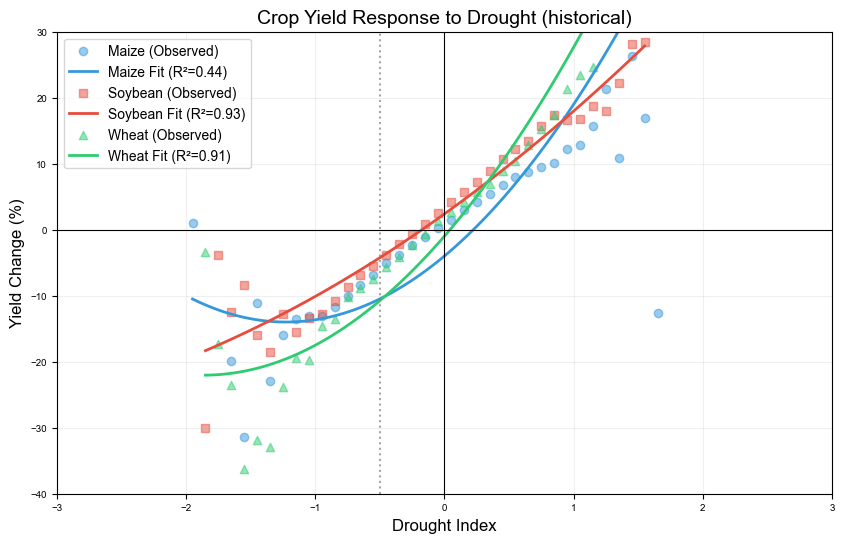


historical 拟合结果:
mai:
  参数: a=-4.00, b=16.32, c=6.66
  R²: 0.444
  RMSE: 20.235
soy:
  参数: a=2.38, b=14.04, c=1.53
  R²: 0.928
  RMSE: 3.844
whe:
  参数: a=-0.99, b=22.57, c=6.05
  R²: 0.907
  RMSE: 6.554


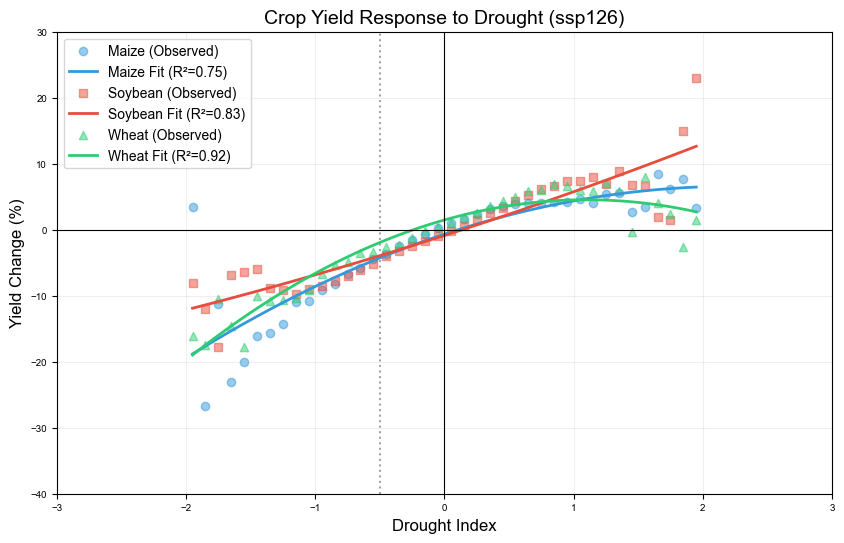


ssp126 拟合结果:
mai:
  参数: a=-0.69, b=6.48, c=-1.45
  R²: 0.749
  RMSE: 4.447
soy:
  参数: a=-0.89, b=6.29, c=0.33
  R²: 0.828
  RMSE: 3.316
whe:
  参数: a=1.47, b=5.56, c=-2.53
  R²: 0.916
  RMSE: 2.150


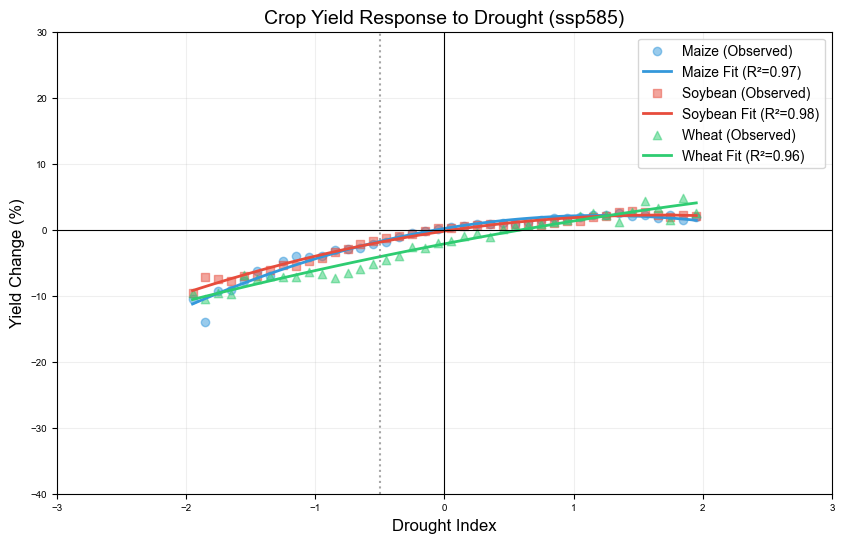


ssp585 拟合结果:
mai:
  参数: a=0.18, b=3.25, c=-1.34
  R²: 0.969
  RMSE: 0.728
soy:
  参数: a=-0.23, b=2.92, c=-0.87
  R²: 0.982
  RMSE: 0.473
whe:
  参数: a=-2.15, b=3.75, c=-0.29
  R²: 0.961
  RMSE: 0.876


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# 1. 定义多项式拟合函数
def polynomial(x, a, b, c):
    """二次多项式函数：a + b*x + c*x^2"""
    return a + b*x + c*x**2

# 2. 拟合和评估函数
def fit_polynomial(x_data, y_data):
    """执行多项式拟合并评估"""
    # 移除nan值
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data)) & (x_data >= -2) & (x_data <= 2)
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) < 5:  # 数据点不足
        return None, None, None
    
    try:
        # 执行二次多项式拟合
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        
        # 计算评估指标
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        return {
            'params': popt,
            'cov': pcov,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"多项式拟合失败: {str(e)}")
        return None

# 3. 为每个SSP绘制所有作物的响应曲线
def plot_ssp_response(results, ssp, save_path=None):
    """绘制同一SSP下所有作物的响应曲线"""
    plt.figure(figsize=(10, 6))
    
    # 定义作物颜色和样式
    crop_styles = {
        'mai': {'color': '#3498db', 'marker': 'o', 'label': 'Maize'},
        'soy': {'color': '#e74c3c', 'marker': 's', 'label': 'Soybean'},
        'whe': {'color': '#2ecc71', 'marker': '^', 'label': 'Wheat'}
    }
    
    # 为每个作物拟合并绘制曲线
    for crop in crops:
        if ssp not in results or crop not in results[ssp]:
            continue
            
        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])
        
        # 执行多项式拟合
        fit_result = fit_polynomial(x_data, y_data)
        
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']
            
            # 绘制原始数据点
            plt.scatter(x_clean, y_clean, 
                       color=crop_styles[crop]['color'],
                       marker=crop_styles[crop]['marker'],
                       alpha=0.5,
                       label=f'{crop_styles[crop]["label"]} (Observed)')
            
            # 绘制拟合曲线
            x_smooth = np.linspace(min(x_clean), max(x_clean), 100)
            y_smooth = polynomial(x_smooth, *params)
            
            plt.plot(x_smooth, y_smooth, 
                    color=crop_styles[crop]['color'],
                    linestyle='-',
                    linewidth=2,
                    label=f'{crop_styles[crop]["label"]} Fit (R²={r2:.2f})')
    
    # 图形装饰
    plt.title(f'Crop Yield Response to Drought ({ssp})', fontsize=14)
    plt.xlabel('Drought Index', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(-0.5, color='gray', linestyle=':', alpha=0.7)
    
    plt.grid(alpha=0.2)
    plt.legend(fontsize=10, frameon=True)
    
    # 统一坐标范围
    plt.xlim(-3, 3)
    plt.ylim(-40, 30)  # 可根据实际数据调整
    
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 4. 主分析流程
def analyze_all_results(results):
    """分析所有结果并绘制综合图表"""
    # 创建输出目录
    import os
    # os.makedirs('./figures', exist_ok=True)
    
    # 为每个SSP情景绘制图表
    for ssp in ssps:
        save_path = f'./figures/{ssp}_crop_response.png'
        plot_ssp_response(results, ssp, save_path)
        
        # 打印拟合结果
        print(f"\n{ssp} 拟合结果:")
        for crop in crops:
            if ssp in results and crop in results[ssp]:
                data = results[ssp][crop]
                x_data = np.array(data['bins'])
                y_data = np.array(data['yield_mean'])
                
                fit_result = fit_polynomial(x_data, y_data)
                if fit_result:
                    print(f"{crop}:")
                    print(f"  参数: a={fit_result['params'][0]:.2f}, b={fit_result['params'][1]:.2f}, c={fit_result['params'][2]:.2f}")
                    print(f"  R²: {fit_result['r2']:.3f}")
                    print(f"  RMSE: {fit_result['rmse']:.3f}")

# 5. 执行分析
if __name__ == '__main__':
    # 运行分析
    analyze_all_results(results)

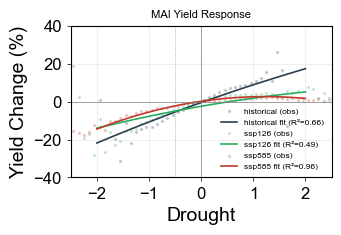

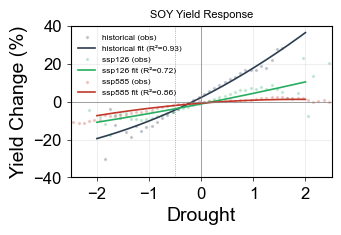

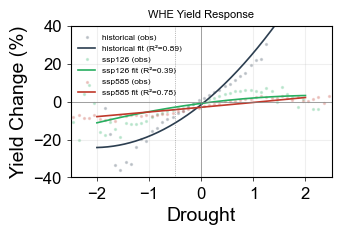

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib as mpl

# Nature 期刊图像规范设置
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7
mpl.rcParams['pdf.fonttype'] = 42  # 确保字体在 Illustrator 可编辑
mpl.rcParams['ps.fonttype'] = 42

# 二次拟合函数
def polynomial(x, a, b, c):
    return a + b * x + c * x**2

def fit_polynomial(x_data, y_data):
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data))#& (x_data >= -2) & (x_data <= 2)
    x_clean = x_data[mask]
    y_clean = y_data[mask]

    if len(x_clean) < 5:
        return None

    try:
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        return {
            'params': popt,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"拟合失败: {str(e)}")
        return None

# 每个作物一张图，三个情景
def plot_crop_response_multi_ssp(results, crop, ssps, save_path=None):
    fig_width_cm = 8.7
    fig_height_cm = 6.0
    fig, ax = plt.subplots(figsize=(fig_width_cm / 2.54, fig_height_cm / 2.54))

    ssp_colors = {
        'historical': '#2c3e50',
        'ssp126': '#27ae60',
        'ssp585': '#c0392b'
    }

    for ssp in ssps:
        if ssp not in results or crop not in results[ssp]:
            continue

        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])

        fit_result = fit_polynomial(x_data, y_data)
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']

            # 原始数据
            ax.scatter(x_clean, y_clean,
                       color=ssp_colors[ssp],
                       alpha=0.2,s=2,
                       label=f"{ssp} (obs)")

            # 拟合曲线
            x_fit = np.linspace(-2, 2, 2000)
            y_fit = polynomial(x_fit, *params)
            ax.plot(x_fit, y_fit,
                    color=ssp_colors[ssp],
                    linewidth=1.2,
                    label=f"{ssp} fit (R²={r2:.2f})")

    # 装饰
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(-0.5, color='gray', linestyle=':', linewidth=0.5)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-40, 40)
    ax.set_xlabel('Drought', fontsize=14)
    ax.set_ylabel('Yield Change (%)', fontsize=14)
    ax.set_title(f'{crop.upper()} Yield Response', fontsize=8)
    ax.legend(frameon=False, fontsize=6, loc='best')
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
    plt.tight_layout()

    # if save_path:
    #     plt.savefig(save_path.replace('.svg', '.pdf'),
    #                 format='pdf', bbox_inches='tight',
    #                 dpi=300, metadata={'CreationDate': None})
    plt.show()
    plt.close()

# 主函数
def analyze_by_crop(results, ssps, crops):
    for crop in crops:
        save_path = f'./figures/{crop}_multi_ssp_response.pdf'
        plot_crop_response_multi_ssp(results, crop, ssps, save_path)
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
analyze_by_crop(results, ssps, crops)


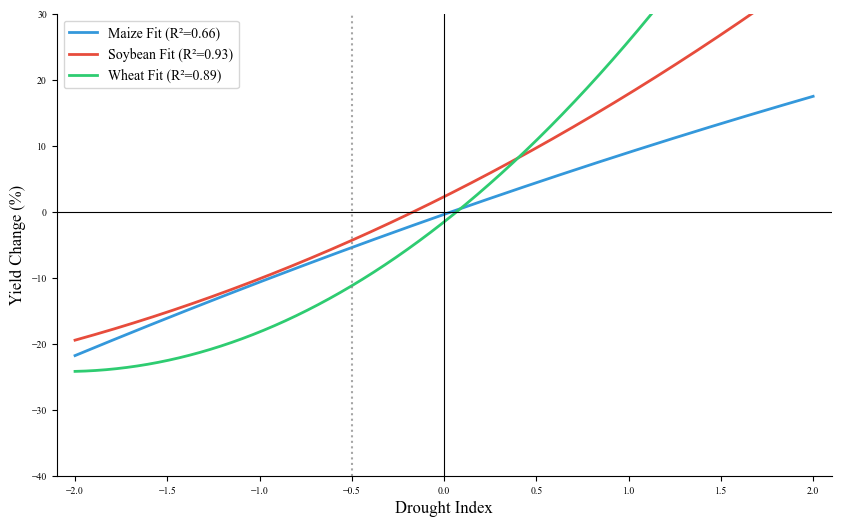


historical 拟合结果 (-2到2范围):
mai:
  参数: a=-0.40, b=9.82, c=-0.44
  使用数据点: 35
  R²: 0.661
  RMSE: 7.230
soy:
  参数: a=2.28, b=14.01, c=1.57
  使用数据点: 35
  R²: 0.928
  RMSE: 3.821
whe:
  参数: a=-1.54, b=22.03, c=5.35
  使用数据点: 34
  R²: 0.891
  RMSE: 7.004


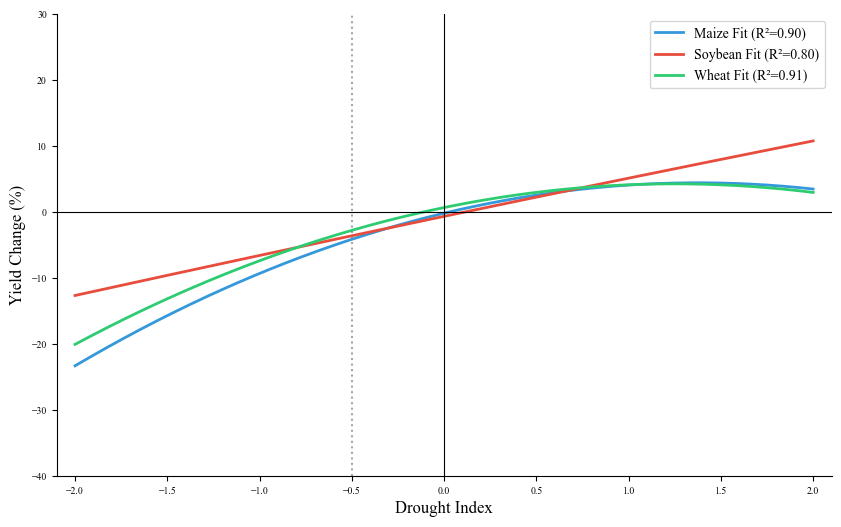


ssp126 拟合结果 (-2到2范围):
mai:
  参数: a=-0.22, b=6.70, c=-2.43
  使用数据点: 40
  R²: 0.898
  RMSE: 2.782
soy:
  参数: a=-0.70, b=5.85, c=-0.07
  使用数据点: 40
  R²: 0.797
  RMSE: 3.414
whe:
  参数: a=0.63, b=5.76, c=-2.31
  使用数据点: 40
  R²: 0.908
  RMSE: 2.282


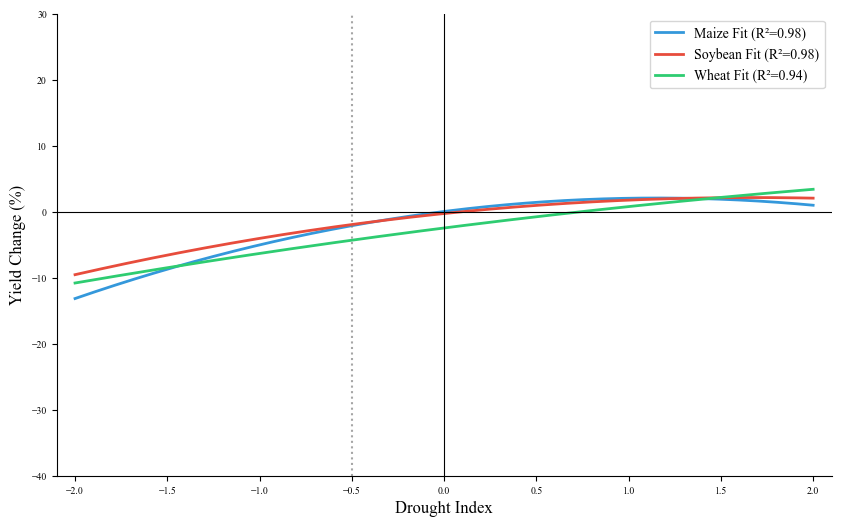


ssp585 拟合结果 (-2到2范围):
mai:
  参数: a=0.04, b=3.53, c=-1.53
  使用数据点: 40
  R²: 0.976
  RMSE: 0.695
soy:
  参数: a=-0.27, b=2.90, c=-0.87
  使用数据点: 40
  R²: 0.983
  RMSE: 0.467
whe:
  参数: a=-2.46, b=3.55, c=-0.31
  使用数据点: 40
  R²: 0.939
  RMSE: 1.047


In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# 1. 定义多项式拟合函数
def polynomial(x, a, b, c):
    """二次多项式函数：a + b*x + c*x^2"""
    return a + b*x + c*x**2

# 2. 拟合和评估函数（限制在-2到2之间）
def fit_polynomial(x_data, y_data):
    """执行多项式拟合并评估（仅使用-2到2范围内的数据）"""
    # 移除nan值并限制范围
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data)) & (x_data >= -2) & (x_data <= 2)
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) < 5:  # 数据点不足
        return None
    
    try:
        # 执行二次多项式拟合
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        
        # 计算评估指标
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        return {
            'params': popt,
            'cov': pcov,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"多项式拟合失败: {str(e)}")
        return None

# 3. 为每个SSP绘制所有作物的响应曲线
def plot_ssp_response(results, ssp, save_path=None):
    """绘制同一SSP下所有作物的响应曲线"""
    plt.figure(figsize=(10, 6))
    plt.rcParams["font.family"] = "Times New Roman"
    # 定义作物颜色和样式
    crop_styles = {
        'mai': {'color': '#3498db', 'marker': 'o', 'label': 'Maize'},
        'soy': {'color': '#e74c3c', 'marker': 's', 'label': 'Soybean'},
        'whe': {'color': '#2ecc71', 'marker': '^', 'label': 'Wheat'}
    }
    
    # 为每个作物拟合并绘制曲线
    for crop in crops:
        if ssp not in results or crop not in results[ssp]:
            continue
            
        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])
        
        # 执行多项式拟合（仅使用-2到2的数据）
        fit_result = fit_polynomial(x_data, y_data)
        
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']
            
            # 绘制原始数据点（全部数据）
            # plt.scatter(x_data, y_data, 
            #            color=crop_styles[crop]['color'],
            #            marker=crop_styles[crop]['marker'],
            #            alpha=0.3,  # 全部数据透明度降低
            #            label=f'{crop_styles[crop]["label"]} (All data)')
            
            # 绘制用于拟合的数据点（-2到2）
            # plt.scatter(x_clean, y_clean,
            #            color=crop_styles[crop]['color'],
            #            marker=crop_styles[crop]['marker'],
            #            alpha=0.7,  # 拟合数据更明显
            #            label=f'{crop_styles[crop]["label"]} (Fit data)')
            
            # 绘制拟合曲线（仅在-2到2范围内）
            x_smooth = np.linspace(-2, 2, 10000)
            y_smooth = polynomial(x_smooth, *params)
            
            plt.plot(x_smooth, y_smooth, 
                    color=crop_styles[crop]['color'],
                    linestyle='-',
                    linewidth=2,
                    label=f'{crop_styles[crop]["label"]} Fit (R²={r2:.2f})')
    
    # 图形装饰
    # plt.title(f'Crop Yield Response to Drought ({ssp})\n(Fitted range: -2 to 2)', fontsize=14)
    plt.xlabel('Drought Index', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(-0.5, color='gray', linestyle=':', alpha=0.7)
    # plt.axvline(-2, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    # plt.axvline(2, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    
    # plt.grid(alpha=0.2)
    plt.legend(fontsize=10, frameon=True)
    
    # 统一坐标范围
    plt.xlim(-2.1, 2.1)  # 仍显示-3到3的全范围
    plt.ylim(-40, 30)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['top'].set_visible(False)    # 隐藏顶部边框
    plt.show()
    plt.close()

# 4. 主分析流程
def analyze_all_results(results):
    """分析所有结果并绘制综合图表"""
    # 为每个SSP情景绘制图表
    for ssp in ssps:
        plot_ssp_response(results, ssp)
        
        # 打印拟合结果
        print(f"\n{ssp} 拟合结果 (-2到2范围):")
        for crop in crops:
            if ssp in results and crop in results[ssp]:
                data = results[ssp][crop]
                x_data = np.array(data['bins'])
                y_data = np.array(data['yield_mean'])
                
                fit_result = fit_polynomial(x_data, y_data)
                if fit_result:
                    print(f"{crop}:")
                    print(f"  参数: a={fit_result['params'][0]:.2f}, b={fit_result['params'][1]:.2f}, c={fit_result['params'][2]:.2f}")
                    print(f"  使用数据点: {len(fit_result['x_clean'])}")
                    print(f"  R²: {fit_result['r2']:.3f}")
                    print(f"  RMSE: {fit_result['rmse']:.3f}")

# 5. 执行分析
if __name__ == '__main__':
    # 运行分析
    analyze_all_results(results)

In [17]:
xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type

<xarray.DataArray 'dominant_type' (lat: 360, lon: 720)> Size: 2MB
[259200 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Attributes:
    long_name:  主导类型（0未知，1干旱主导，2洪涝主导，3共同主导）

Processing SSPs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/119 [00:00<?, ?it/s]

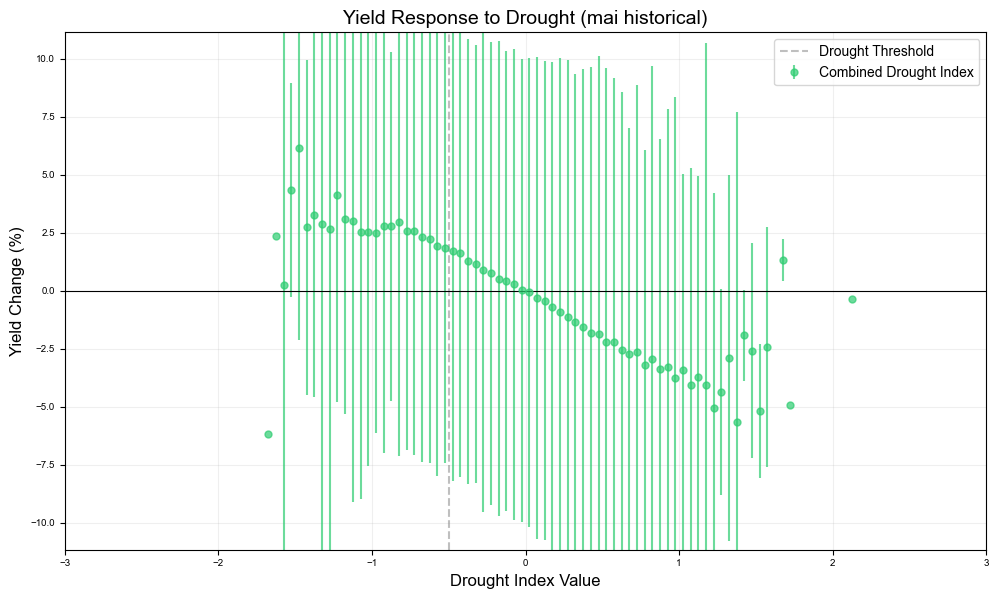

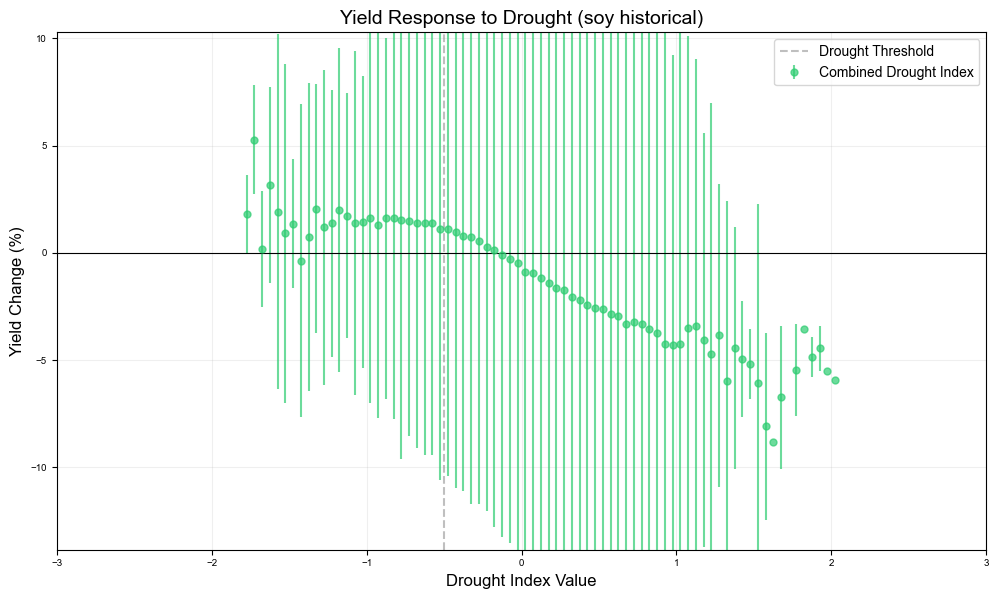

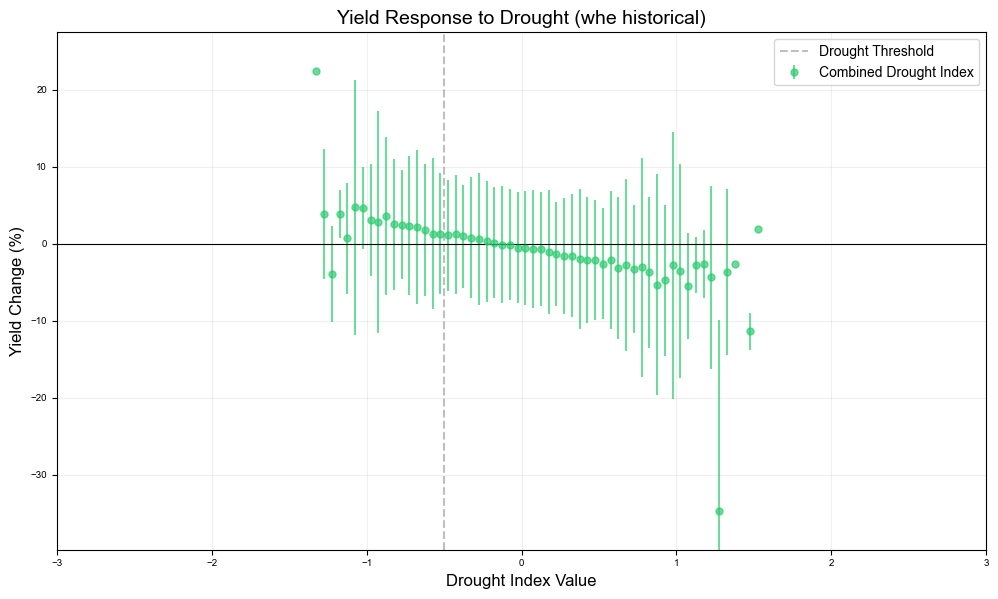

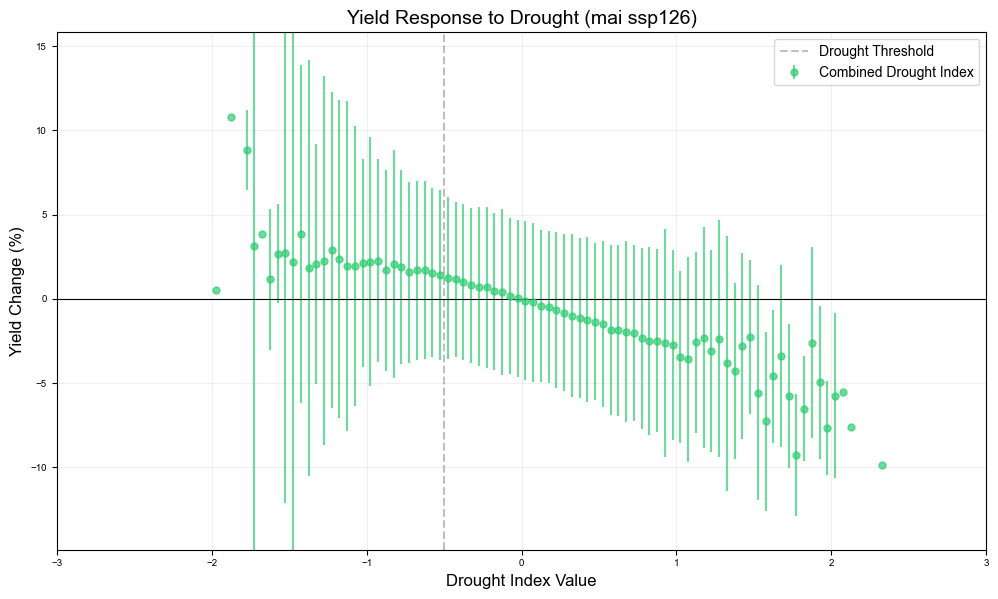

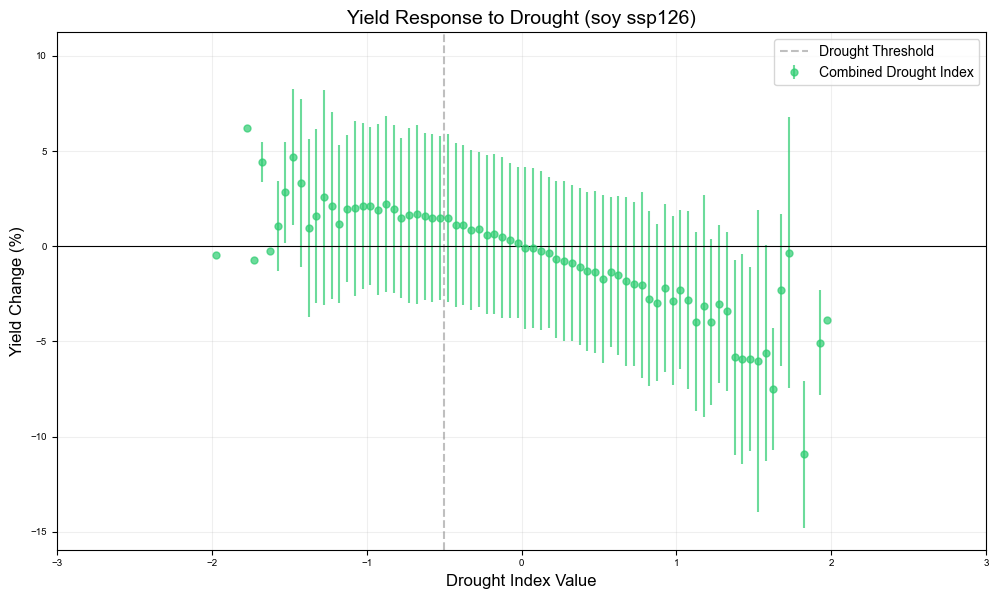

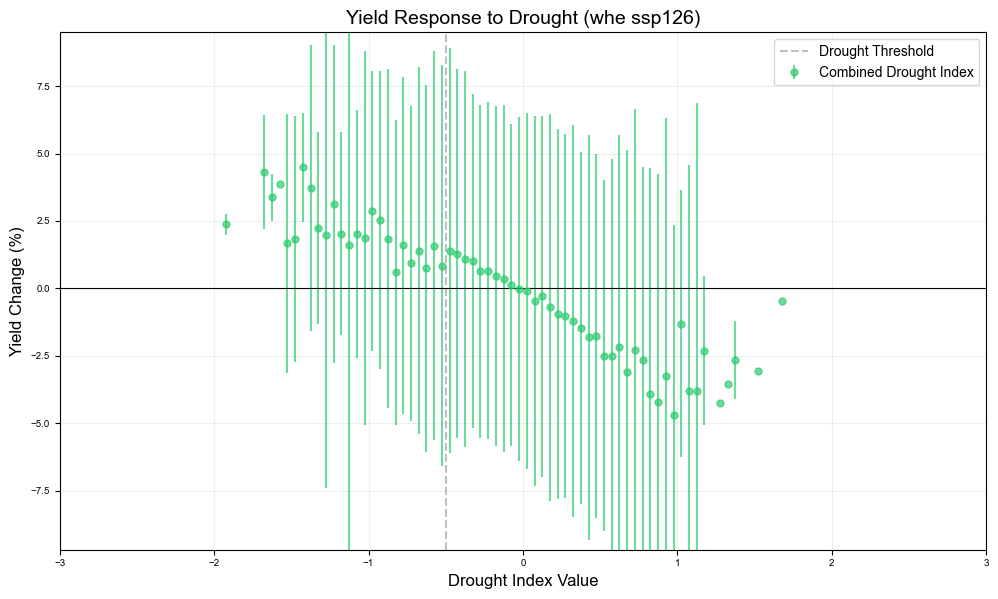

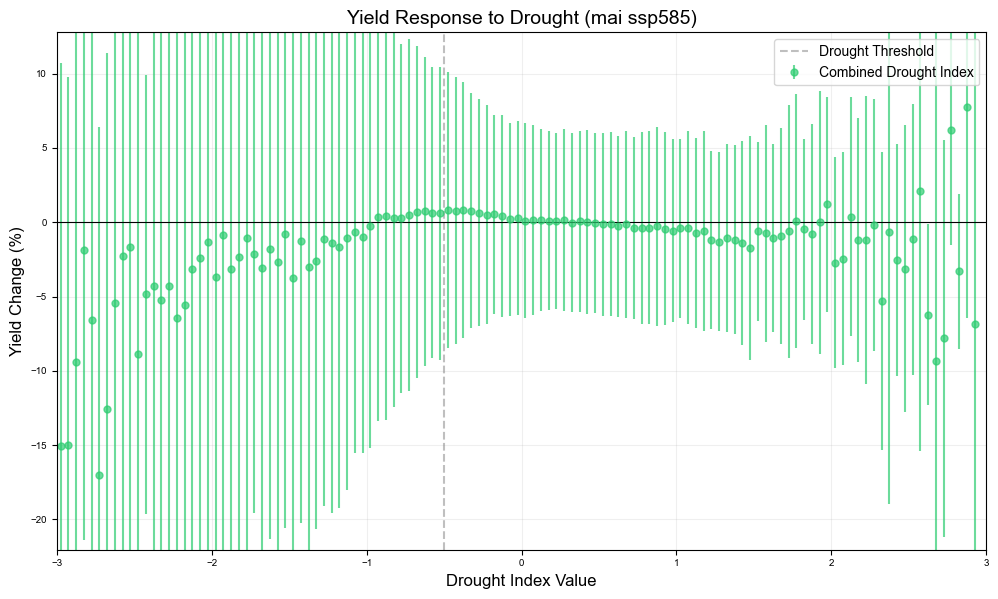

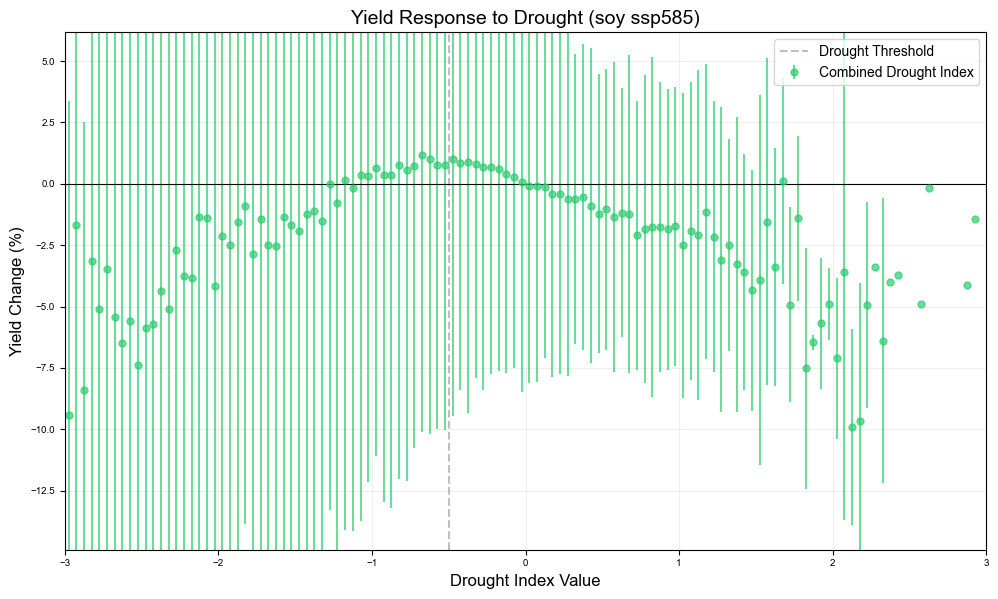

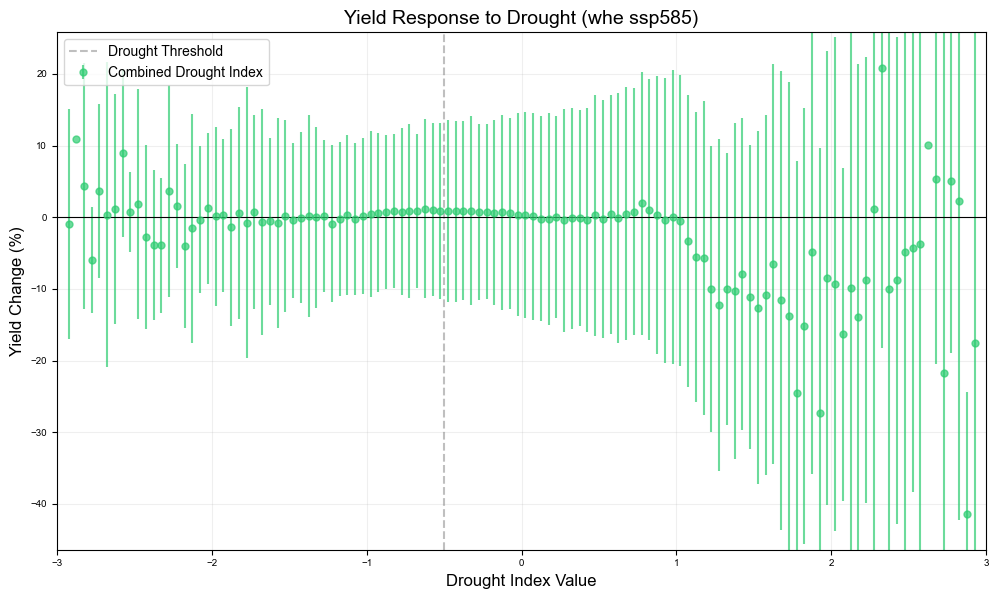

In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # 用于显示进度

# 设置绘图风格
sns.set_palette("husl")
plt.rcParams['font.family'] = 'Arial'

def analyze_drought_bins(result_dict1, result_dict2, bins=np.arange(-3, 3, 0.1)):
    """分析不同干旱区间下的产量变化（合并SSI和SPEI）"""
    results = {}
    
    for ssp in tqdm(ssps, desc='Processing SSPs'):
        results[ssp] = {}
        idx = 33 if ssp == 'historical' else 30  # 时间长度
        
        for crop in tqdm(crops, desc='Processing Crops', leave=False):
            try:
                # 加载主导类型数据
                dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
                
                
                # 准备产量数据
                expect_yield = result_dict2[ssp][crop]['expect_yield'][:-1]
                yied = result_dict1[ssp][crop]['yield'][:]
                expect_yield = expect_yield[-len(yied):]
                expect_yield['time'] = yied.time.values
                yied = yied.where(yied > 0)
                yield_loss = (yied - expect_yield) / yied * 100
                
                # 获取干旱指数数据（合并SSI和SPEI）
                ssi = result_dict1[ssp][crop]['ssi'][:, :, :]
                spei = result_dict1[ssp][crop]['spei'][:, :, :]
                spei['time'] = yied.time.values
                ssi['time'] = yied.time.values
                
                # 应用筛选条件
                mask = (abs(yield_loss) < 100) & (dominant_type == 2)
                ssi = ssi.where(mask)
                spei = spei.where(mask)
                yield_loss = yield_loss.where(mask)
                
                # 初始化结果存储
                results[ssp][crop] = {
                    'bins': [],
                    'yield_mean': [],
                    'yield_std': [],
                    'count': []
                }
                
                # 分析每个区间
                for i in tqdm(range(len(bins)-1), desc='Processing Bins', leave=False):
                    lower, upper = bins[i], bins[i+1]
                    
                    # 筛选当前区间的数据
                    di_mask = ((spei >= lower) & (spei < upper))|((ssi >= lower) & (ssi < upper))
                    yl_values = yield_loss.where(di_mask).values
                    yl_values = yl_values[~np.isnan(yl_values)]
                    
                    # 存储结果
                    results[ssp][crop]['bins'].append((lower + upper)/2)
                    results[ssp][crop]['yield_mean'].append(np.median(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['yield_std'].append(np.std(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['count'].append(len(yl_values))
                    
            except Exception as e:
                print(f"Error processing {ssp}-{crop}: {str(e)}")
                continue
                
    return results

def plot_combined_response(results, crop, ssp):
    """绘制合并的干旱响应曲线"""
    if ssp not in results or crop not in results[ssp]:
        print(f"No data for {crop}-{ssp}")
        return
    
    data = results[ssp][crop]
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制响应曲线（合并SSI和SPEI）
    plt.errorbar(data['bins'], data['yield_mean'], 
                yerr=data['yield_std'], fmt='o', markersize=5,
                color='#2ecc71', alpha=0.7, 
                label='Combined Drought Index')
    
    # 图形装饰
    plt.title(f'Yield Response to Drought ({crop} {ssp})', fontsize=14)
    plt.xlabel('Drought Index Value', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.5, label='Drought Threshold')
    plt.axhline(y=0, color='black', linewidth=0.8)
    
    # 设置坐标范围
    plt.xlim(-3, 3)
    y_min = np.nanmin(data['yield_mean']) - 5
    y_max = np.nanmax(data['yield_mean']) + 5
    plt.ylim(y_min, y_max)  # 限制y轴最大值
    
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    
    # 显示并保存图形
    plt.tight_layout()
    # save_path = f'{save_dir}/{crop}_{ssp}_combined_drought_response.png'
    plt.show()
    plt.close()
    # print(f"Saved to {save_path}")

# 运行分析
if __name__ == '__main__':
    # 定义干旱区间（-3到3，间隔0.1）
    bins = np.arange(-3, 3, 0.05)
    
    # 运行分析（合并SSI和SPEI）
    results1 = analyze_drought_bins(result_dict1, result_dict2, bins)
    
    # 为每个作物和情景绘制图形
    for ssp in ssps:
        for crop in crops:
            plot_combined_response(results1, crop, ssp)

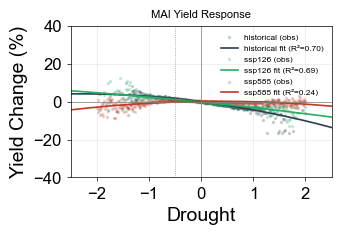

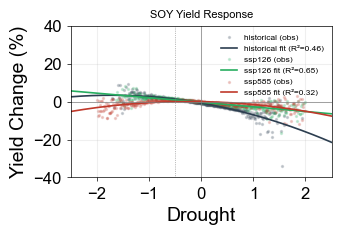

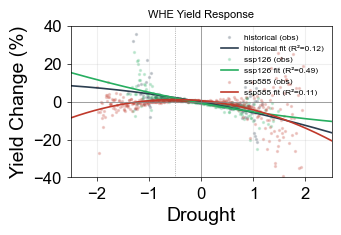

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib as mpl

# Nature 期刊图像规范设置
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7
mpl.rcParams['pdf.fonttype'] = 42  # 确保字体在 Illustrator 可编辑
mpl.rcParams['ps.fonttype'] = 42

# 二次拟合函数
def polynomial(x, a, b, c):
    return a + b * x + c * x**2

def fit_polynomial(x_data, y_data):
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data)) & (x_data >= -2) & (x_data <= 2)
    x_clean = x_data[mask]
    y_clean = y_data[mask]

    if len(x_clean) < 5:
        return None

    try:
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        return {
            'params': popt,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"拟合失败: {str(e)}")
        return None

# 每个作物一张图，三个情景
def plot_crop_response_multi_ssp(results, crop, ssps, save_path=None):
    fig_width_cm = 8.7
    fig_height_cm = 6.0
    fig, ax = plt.subplots(figsize=(fig_width_cm / 2.54, fig_height_cm / 2.54))

    ssp_colors = {
        'historical': '#2c3e50',
        'ssp126': '#27ae60',
        'ssp585': '#c0392b'
    }

    for ssp in ssps:
        if ssp not in results or crop not in results[ssp]:
            continue

        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])

        fit_result = fit_polynomial(x_data, y_data)
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']

            # 原始数据
            ax.scatter(x_clean, y_clean,
                       color=ssp_colors[ssp],
                       alpha=0.2,s=2,
                       label=f"{ssp} (obs)")

            # 拟合曲线
            x_fit = np.linspace(-2.5, 2.5, 200)
            y_fit = polynomial(x_fit, *params)
            ax.plot(x_fit, y_fit,
                    color=ssp_colors[ssp],
                    linewidth=1.2,
                    label=f"{ssp} fit (R²={r2:.2f})")

    # 装饰
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(-0.5, color='gray', linestyle=':', linewidth=0.5)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-40, 40)
    ax.set_xlabel('Drought', fontsize=14)
    ax.set_ylabel('Yield Change (%)', fontsize=14)
    ax.set_title(f'{crop.upper()} Yield Response', fontsize=8)
    ax.legend(frameon=False, fontsize=6, loc='best')
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path.replace('.svg', '.pdf'),
                    format='pdf', bbox_inches='tight',
                    dpi=300, metadata={'CreationDate': None})
    plt.show()
    plt.close()

# 主函数
def analyze_by_crop(results, ssps, crops):
    for crop in crops:
        save_path = f'./figures/{crop}_multi_ssp_response_flood.pdf'
        plot_crop_response_multi_ssp(results, crop, ssps, save_path)
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
analyze_by_crop(results1, ssps, crops)


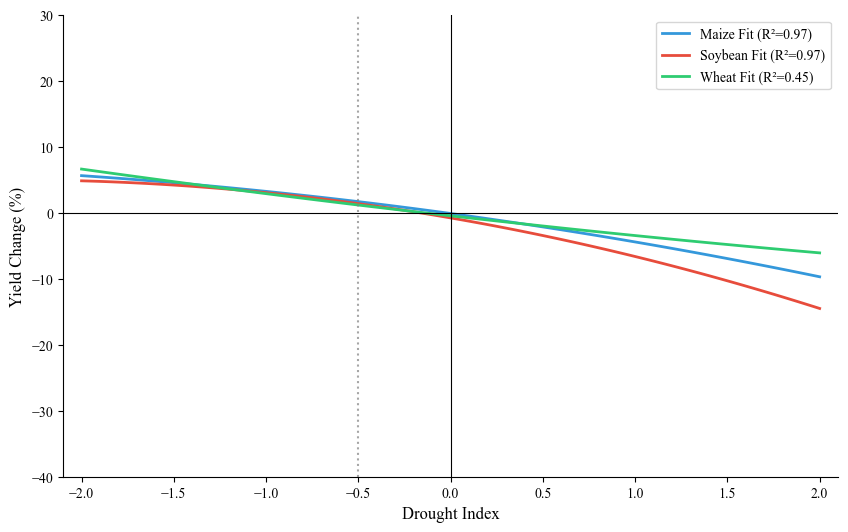


historical 拟合结果 (-2到2范围):
mai:
  参数: a=-0.11, b=-3.83, c=-0.48
  使用数据点: 200
  R²: 0.972
  RMSE: 0.375
soy:
  参数: a=-0.79, b=-4.83, c=-1.01
  使用数据点: 200
  R²: 0.971
  RMSE: 0.488
whe:
  参数: a=-0.47, b=-3.17, c=0.18
  使用数据点: 199
  R²: 0.452
  RMSE: 2.012


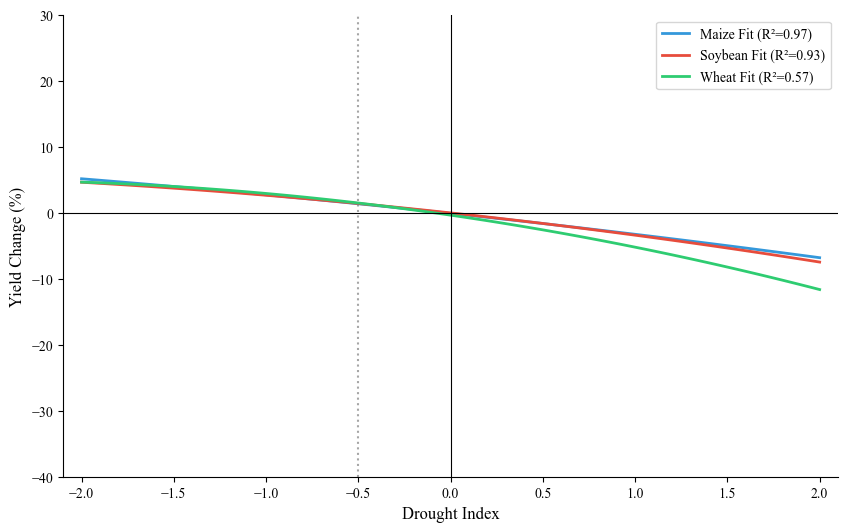


ssp126 拟合结果 (-2到2范围):
mai:
  参数: a=-0.09, b=-2.99, c=-0.18
  使用数据点: 200
  R²: 0.971
  RMSE: 0.300
soy:
  参数: a=-0.03, b=-3.02, c=-0.35
  使用数据点: 200
  R²: 0.932
  RMSE: 0.474
whe:
  参数: a=-0.37, b=-4.07, c=-0.78
  使用数据点: 200
  R²: 0.570
  RMSE: 2.051


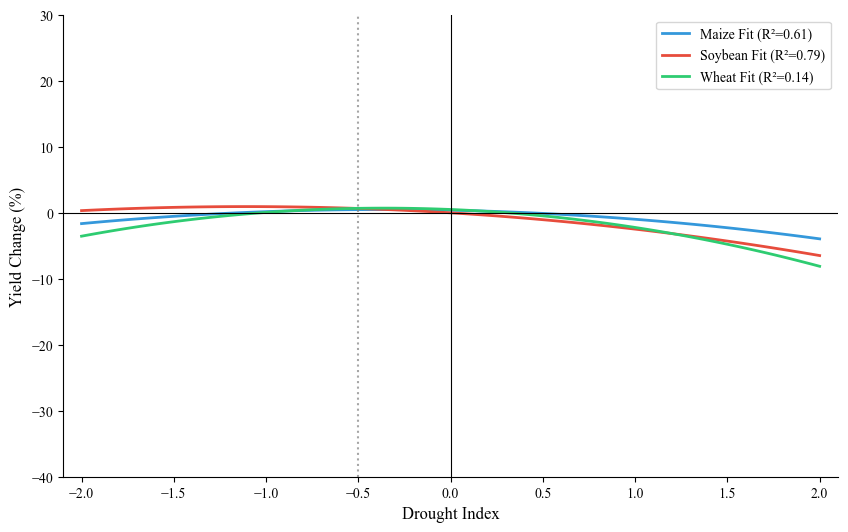


ssp585 拟合结果 (-2到2范围):
mai:
  参数: a=0.38, b=-0.58, c=-0.80
  使用数据点: 200
  R²: 0.615
  RMSE: 0.324
soy:
  参数: a=-0.01, b=-1.70, c=-0.77
  使用数据点: 200
  R²: 0.790
  RMSE: 0.520
whe:
  参数: a=0.49, b=-1.14, c=-1.58
  使用数据点: 200
  R²: 0.140
  RMSE: 2.003


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# 1. 定义多项式拟合函数
def polynomial(x, a, b, c):
    """二次多项式函数：a + b*x + c*x^2"""
    return a + b*x + c*x**2

# 2. 拟合和评估函数（限制在-2到2之间）
def fit_polynomial(x_data, y_data):
    """执行多项式拟合并评估（仅使用-2到2范围内的数据）"""
    # 移除nan值并限制范围
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data)) & (x_data >= -1) & (x_data <= 1)
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) < 5:  # 数据点不足
        return None
    
    try:
        # 执行二次多项式拟合
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        
        # 计算评估指标
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        return {
            'params': popt,
            'cov': pcov,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"多项式拟合失败: {str(e)}")
        return None

# 3. 为每个SSP绘制所有作物的响应曲线
def plot_ssp_response(results, ssp, save_path=None):
    """绘制同一SSP下所有作物的响应曲线"""
    plt.figure(figsize=(10, 6))
    plt.rcParams["font.family"] = "Times New Roman"
    # 定义作物颜色和样式
    crop_styles = {
        'mai': {'color': '#3498db', 'marker': 'o', 'label': 'Maize'},
        'soy': {'color': '#e74c3c', 'marker': 's', 'label': 'Soybean'},
        'whe': {'color': '#2ecc71', 'marker': '^', 'label': 'Wheat'}
    }
    
    # 为每个作物拟合并绘制曲线
    for crop in crops:
        if ssp not in results or crop not in results[ssp]:
            continue
            
        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])
        
        # 执行多项式拟合（仅使用-2到2的数据）
        fit_result = fit_polynomial(x_data, y_data)
        
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']
            
            # 绘制原始数据点（全部数据）
            # plt.scatter(x_data, y_data, 
            #            color=crop_styles[crop]['color'],
            #            marker=crop_styles[crop]['marker'],
            #            alpha=0.3,  # 全部数据透明度降低
            #            label=f'{crop_styles[crop]["label"]} (All data)')
            
            # 绘制用于拟合的数据点（-2到2）
            # plt.scatter(x_clean, y_clean,
            #            color=crop_styles[crop]['color'],
            #            marker=crop_styles[crop]['marker'],
            #            alpha=0.7,  # 拟合数据更明显
            #            label=f'{crop_styles[crop]["label"]} (Fit data)')
            
            # 绘制拟合曲线（仅在-2到2范围内）
            x_smooth = np.linspace(-2, 2, 100)
            y_smooth = polynomial(x_smooth, *params)
            
            plt.plot(x_smooth, y_smooth, 
                    color=crop_styles[crop]['color'],
                    linestyle='-',
                    linewidth=2,
                    label=f'{crop_styles[crop]["label"]} Fit (R²={r2:.2f})')
    
    # 图形装饰
    # plt.title(f'Crop Yield Response to Drought ({ssp})\n(Fitted range: -2 to 2)', fontsize=14)
    plt.xlabel('Drought Index', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(-0.5, color='gray', linestyle=':', alpha=0.7)
    # plt.axvline(-2, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    # plt.axvline(2, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    
    # plt.grid(alpha=0.2)
    plt.legend(fontsize=10, frameon=True)
    
    # 统一坐标范围
    plt.xlim(-2.1, 2.1)  # 仍显示-3到3的全范围
    plt.ylim(-40, 30)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['top'].set_visible(False)    # 隐藏顶部边框
    plt.show()
    plt.close()

# 4. 主分析流程
def analyze_all_results(results):
    """分析所有结果并绘制综合图表"""
    # 为每个SSP情景绘制图表
    for ssp in ssps:
        plot_ssp_response(results, ssp)
        
        # 打印拟合结果
        print(f"\n{ssp} 拟合结果 (-2到2范围):")
        for crop in crops:
            if ssp in results and crop in results[ssp]:
                data = results[ssp][crop]
                x_data = np.array(data['bins'])
                y_data = np.array(data['yield_mean'])
                
                fit_result = fit_polynomial(x_data, y_data)
                if fit_result:
                    print(f"{crop}:")
                    print(f"  参数: a={fit_result['params'][0]:.2f}, b={fit_result['params'][1]:.2f}, c={fit_result['params'][2]:.2f}")
                    print(f"  使用数据点: {len(fit_result['x_clean'])}")
                    print(f"  R²: {fit_result['r2']:.3f}")
                    print(f"  RMSE: {fit_result['rmse']:.3f}")

# 5. 执行分析
if __name__ == '__main__':
    # 运行分析
    analyze_all_results(results1)

Processing SSPs:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Crops:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

Processing Bins:   0%|          | 0/599 [00:00<?, ?it/s]

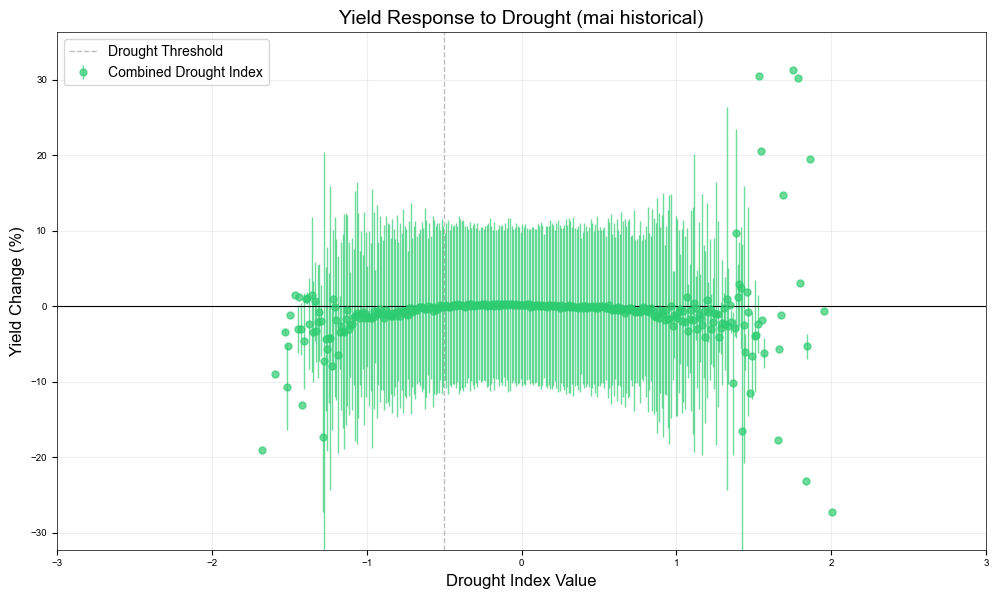

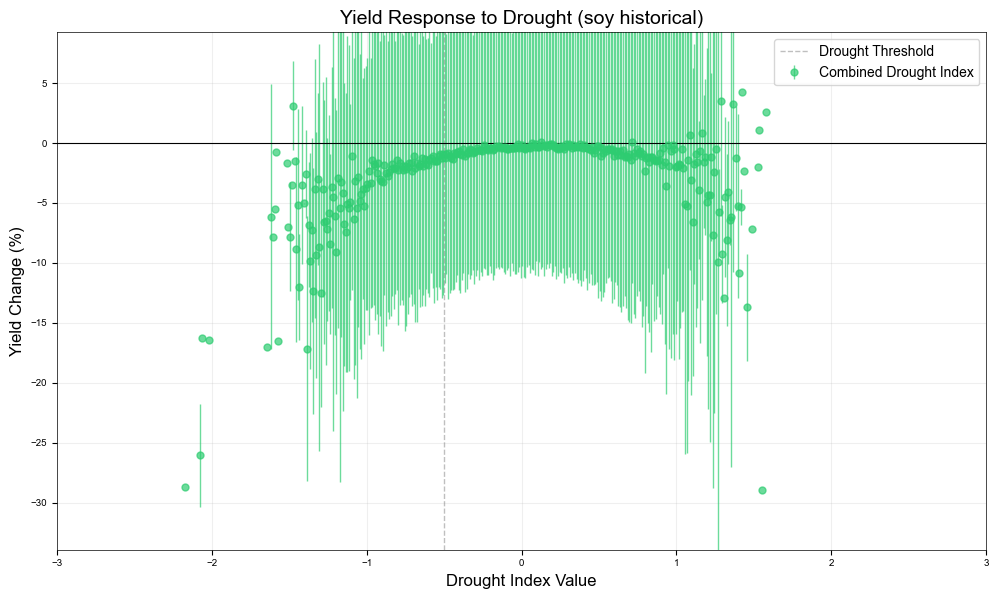

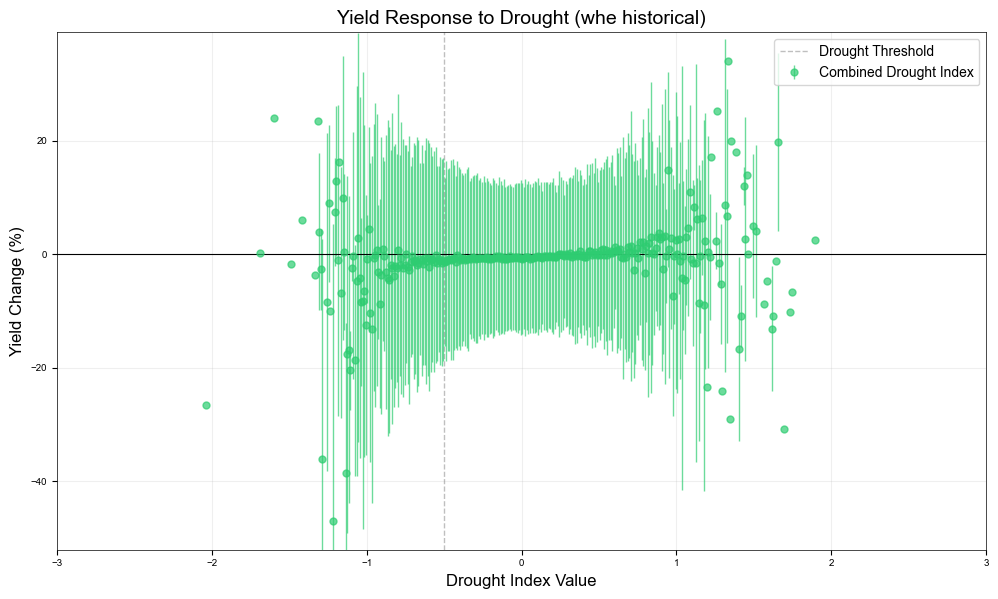

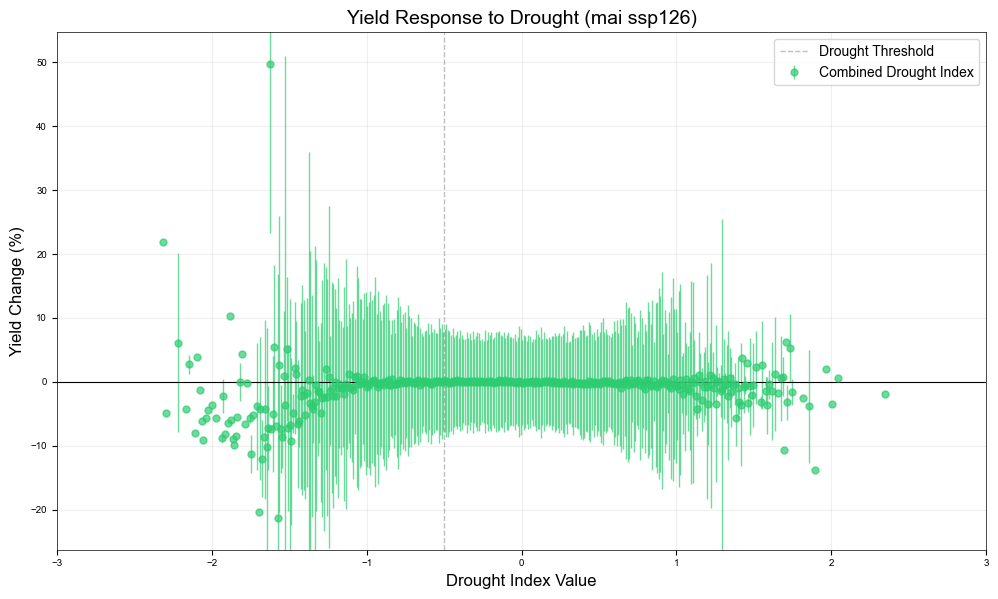

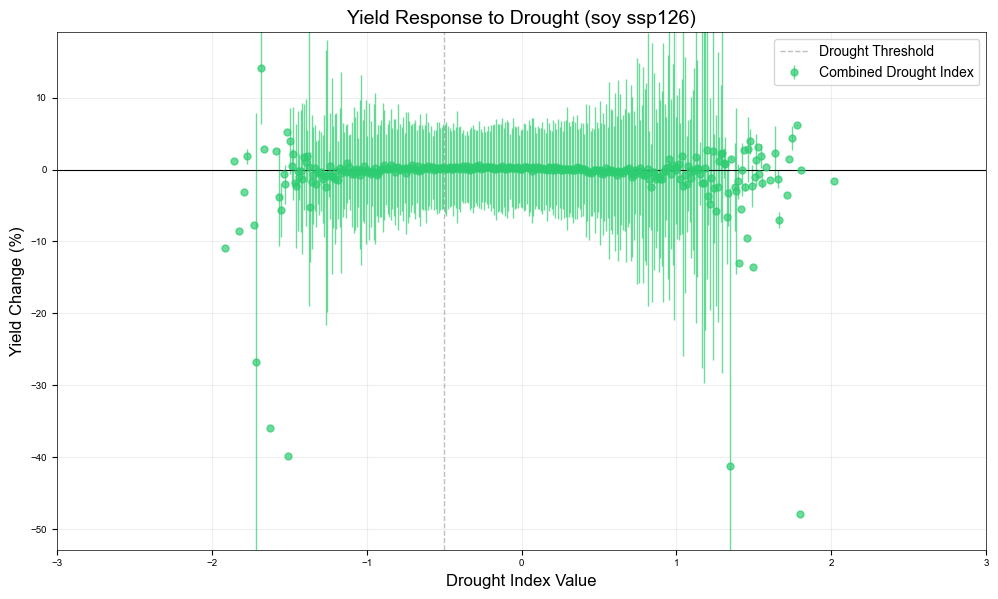

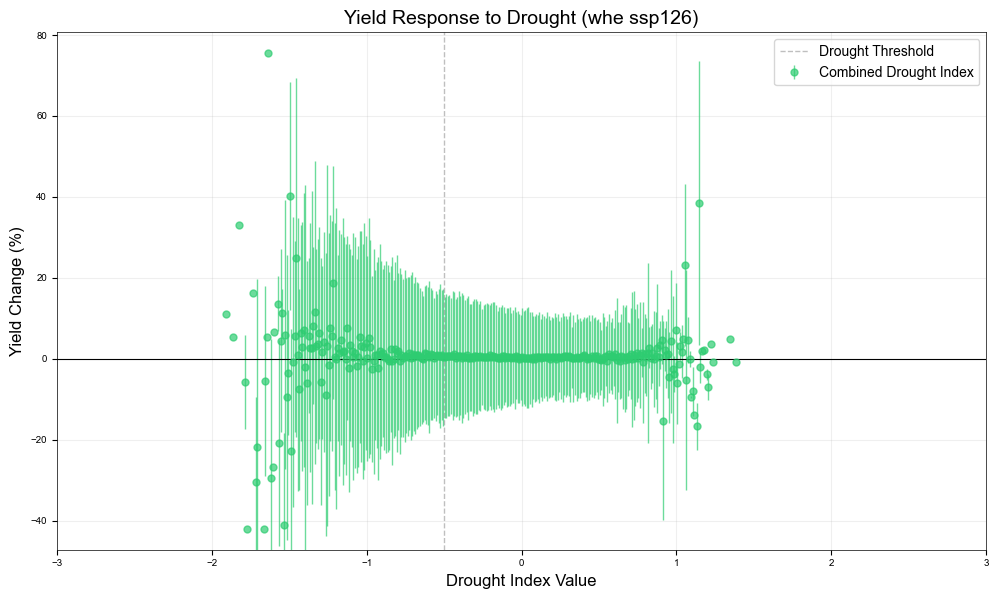

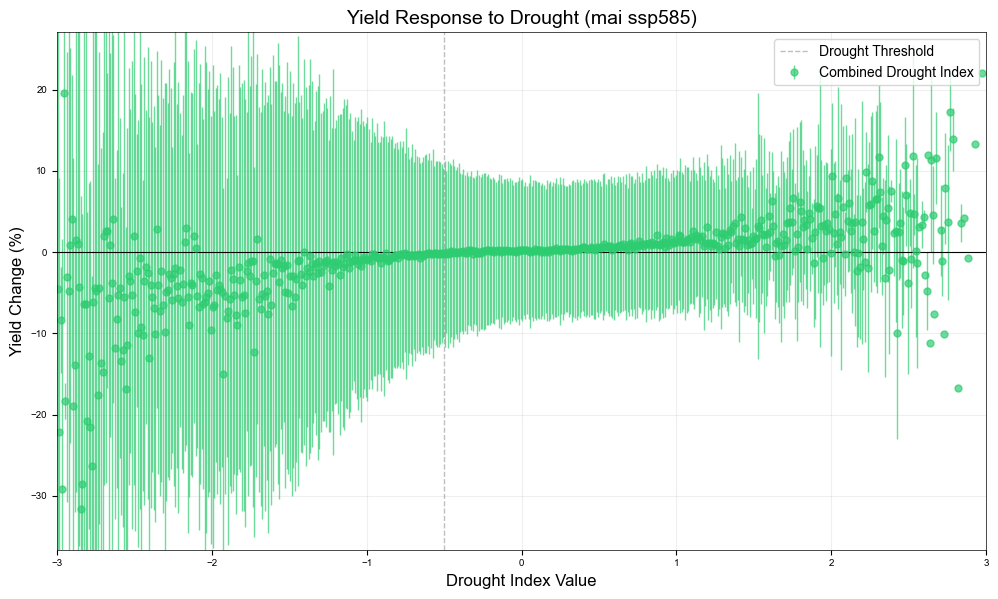

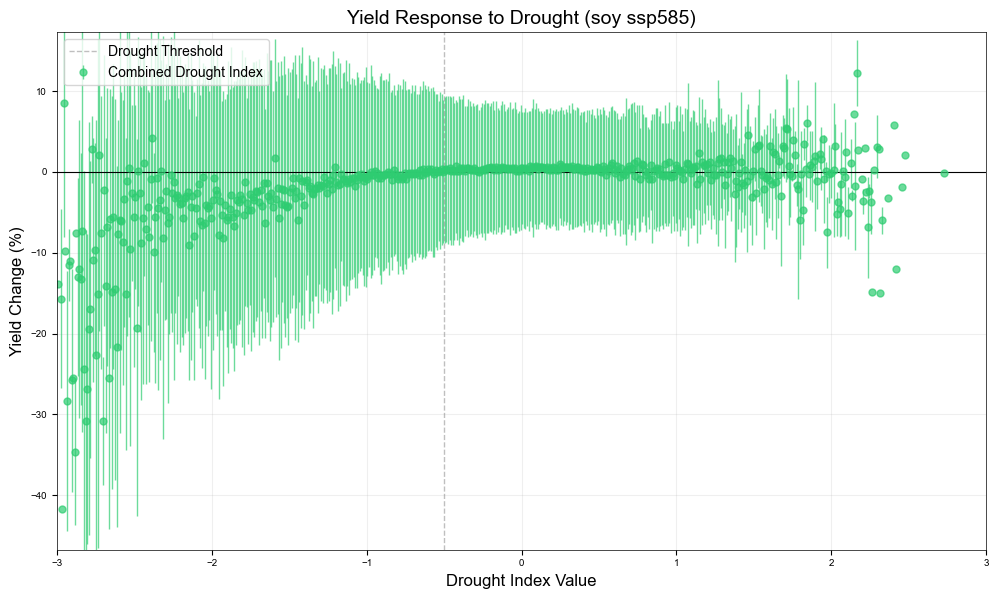

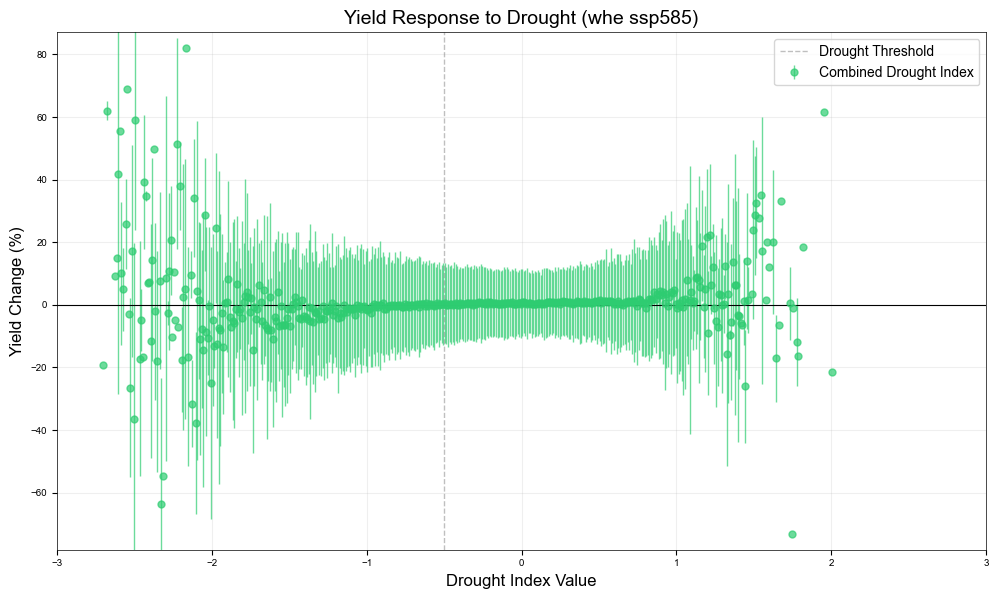

In [47]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # 用于显示进度

# 设置绘图风格
sns.set_palette("husl")
plt.rcParams['font.family'] = 'Arial'

def analyze_drought_bins(result_dict1, result_dict2, bins=np.arange(-3, 3, 0.1)):
    """分析不同干旱区间下的产量变化（合并SSI和SPEI）"""
    results = {}
    
    for ssp in tqdm(ssps, desc='Processing SSPs'):
        results[ssp] = {}
        idx = 33 if ssp == 'historical' else 30  # 时间长度
        
        for crop in tqdm(crops, desc='Processing Crops', leave=False):
            try:
                # 加载主导类型数据
                dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
                
                
                # 准备产量数据
                expect_yield = result_dict2[ssp][crop]['expect_yield'][:-1]
                yied = result_dict1[ssp][crop]['yield'][:]
                expect_yield = expect_yield[-len(yied):]
                expect_yield['time'] = yied.time.values
                yied = yied.where(yied > 0)
                yield_loss = (yied - expect_yield) / yied * 100
                
                # 获取干旱指数数据（合并SSI和SPEI）
                ssi = result_dict1[ssp][crop]['ssi'][:, :, :]
                spei = result_dict1[ssp][crop]['spei'][:, :, :]
                spei['time'] = yied.time.values
                ssi['time'] = yied.time.values
                
                # 应用筛选条件
                mask = (abs(yield_loss) < 100) & (dominant_type == 3)
                ssi = ssi.where(mask)
                spei = spei.where(mask)
                yield_loss = yield_loss.where(mask)
                
                # 初始化结果存储
                results[ssp][crop] = {
                    'bins': [],
                    'yield_mean': [],
                    'yield_std': [],
                    'count': []
                }
                
                # 分析每个区间
                for i in tqdm(range(len(bins)-1), desc='Processing Bins', leave=False):
                    lower, upper = bins[i], bins[i+1]
                    
                    # 筛选当前区间的数据
                    di_mask = ((spei >= lower) & (spei < upper))|((ssi >= lower) & (ssi < upper))
                    yl_values = yield_loss.where(di_mask).values
                    yl_values = yl_values[~np.isnan(yl_values)]
                    
                    # 存储结果
                    results[ssp][crop]['bins'].append((lower + upper)/2)
                    results[ssp][crop]['yield_mean'].append(np.median(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['yield_std'].append(np.std(yl_values) if len(yl_values) > 0 else np.nan)
                    results[ssp][crop]['count'].append(len(yl_values))
                    
            except Exception as e:
                print(f"Error processing {ssp}-{crop}: {str(e)}")
                continue
                
    return results

def plot_combined_response(results, crop, ssp):
    """绘制合并的干旱响应曲线"""
    if ssp not in results or crop not in results[ssp]:
        print(f"No data for {crop}-{ssp}")
        return
    
    data = results[ssp][crop]
    
    # 创建图形
    plt.figure(figsize=(10, 6))
    
    # 绘制响应曲线（合并SSI和SPEI）
    plt.errorbar(data['bins'], data['yield_mean'], 
                yerr=data['yield_std'], fmt='o', markersize=5,
                color='#2ecc71', alpha=0.7, 
                label='Combined Drought Index')
    
    # 图形装饰
    plt.title(f'Yield Response to Drought ({crop} {ssp})', fontsize=14)
    plt.xlabel('Drought Index Value', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.5, label='Drought Threshold')
    plt.axhline(y=0, color='black', linewidth=0.8)
    
    # 设置坐标范围
    plt.xlim(-3, 3)
    y_min = np.nanmin(data['yield_mean']) - 5
    y_max = np.nanmax(data['yield_mean']) + 5
    plt.ylim(y_min, y_max)  # 限制y轴最大值
    
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    
    # 显示并保存图形
    plt.tight_layout()
    # save_path = f'{save_dir}/{crop}_{ssp}_combined_drought_response.png'
    plt.show()
    plt.close()
    # print(f"Saved to {save_path}")

# 运行分析
if __name__ == '__main__':
    # 定义干旱区间（-3到3，间隔0.1）
    bins = np.arange(-3, 3, 0.01)
    
    # 运行分析（合并SSI和SPEI）
    results2 = analyze_drought_bins(result_dict1, result_dict2, bins)
    
    # 为每个作物和情景绘制图形
    for ssp in ssps:
        for crop in crops:
            plot_combined_response(results2, crop, ssp)

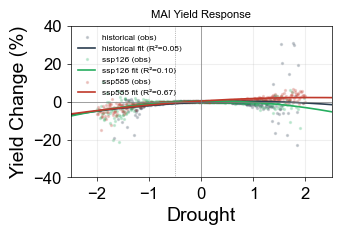

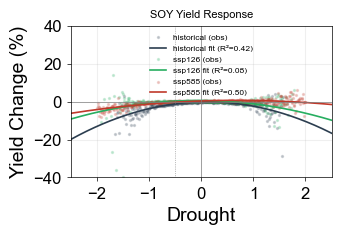

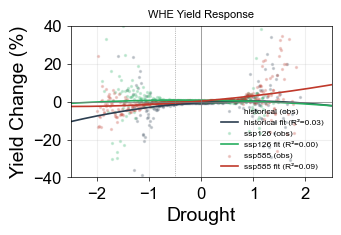

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib as mpl

# Nature 期刊图像规范设置
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7
mpl.rcParams['pdf.fonttype'] = 42  # 确保字体在 Illustrator 可编辑
mpl.rcParams['ps.fonttype'] = 42

# 二次拟合函数
def polynomial(x, a, b, c):
    return a + b * x + c * x**2

def fit_polynomial(x_data, y_data):
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data)) & (x_data >= -2) & (x_data <= 2)
    x_clean = x_data[mask]
    y_clean = y_data[mask]

    if len(x_clean) < 5:
        return None

    try:
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        return {
            'params': popt,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"拟合失败: {str(e)}")
        return None

# 每个作物一张图，三个情景
def plot_crop_response_multi_ssp(results, crop, ssps, save_path=None):
    fig_width_cm = 8.7
    fig_height_cm = 6.0
    fig, ax = plt.subplots(figsize=(fig_width_cm / 2.54, fig_height_cm / 2.54))

    ssp_colors = {
        'historical': '#2c3e50',
        'ssp126': '#27ae60',
        'ssp585': '#c0392b'
    }

    for ssp in ssps:
        if ssp not in results or crop not in results[ssp]:
            continue

        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])

        fit_result = fit_polynomial(x_data, y_data)
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']

            # 原始数据
            ax.scatter(x_clean, y_clean,
                       color=ssp_colors[ssp],
                       alpha=0.2,s=2,
                       label=f"{ssp} (obs)")

            # 拟合曲线
            x_fit = np.linspace(-2.5, 2.5, 200)
            y_fit = polynomial(x_fit, *params)
            ax.plot(x_fit, y_fit,
                    color=ssp_colors[ssp],
                    linewidth=1.2,
                    label=f"{ssp} fit (R²={r2:.2f})")

    # 装饰
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(-0.5, color='gray', linestyle=':', linewidth=0.5)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-40, 40)
    ax.set_xlabel('Drought', fontsize=14)
    ax.set_ylabel('Yield Change (%)', fontsize=14)
    ax.set_title(f'{crop.upper()} Yield Response', fontsize=8)
    ax.legend(frameon=False, fontsize=6, loc='best')
    ax.grid(True, alpha=0.2)
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path.replace('.svg', '.pdf'),
                    format='pdf', bbox_inches='tight',
                    dpi=300, metadata={'CreationDate': None})
    plt.show()
    plt.close()

# 主函数
def analyze_by_crop(results, ssps, crops):
    for crop in crops:
        save_path = f'./figures/{crop}_multi_ssp_response_coeffect.pdf'
        plot_crop_response_multi_ssp(results, crop, ssps, save_path)
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
analyze_by_crop(results2, ssps, crops)


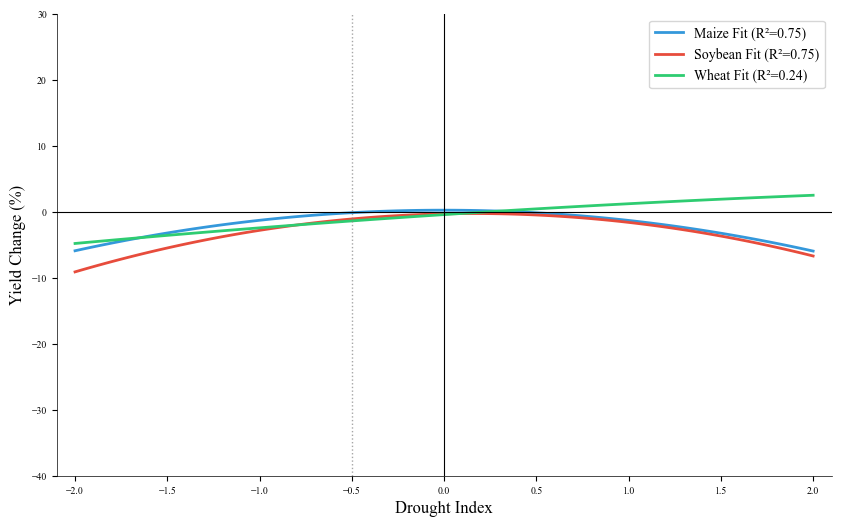


historical 拟合结果 (-2到2范围):
mai:
  参数: a=0.23, b=-0.01, c=-1.54
  使用数据点: 200
  R²: 0.745
  RMSE: 0.269
soy:
  参数: a=-0.32, b=0.60, c=-1.90
  使用数据点: 200
  R²: 0.754
  RMSE: 0.380
whe:
  参数: a=-0.44, b=1.83, c=-0.18
  使用数据点: 200
  R²: 0.238
  RMSE: 1.887


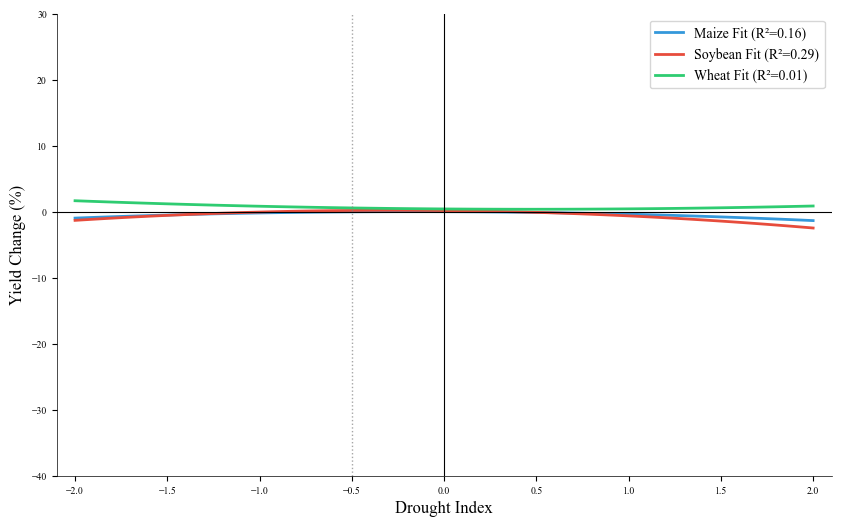


ssp126 拟合结果 (-2到2范围):
mai:
  参数: a=0.01, b=-0.09, c=-0.29
  使用数据点: 200
  R²: 0.165
  RMSE: 0.231
soy:
  参数: a=0.18, b=-0.29, c=-0.52
  使用数据点: 200
  R²: 0.292
  RMSE: 0.354
whe:
  参数: a=0.42, b=-0.20, c=0.21
  使用数据点: 200
  R²: 0.007
  RMSE: 1.559


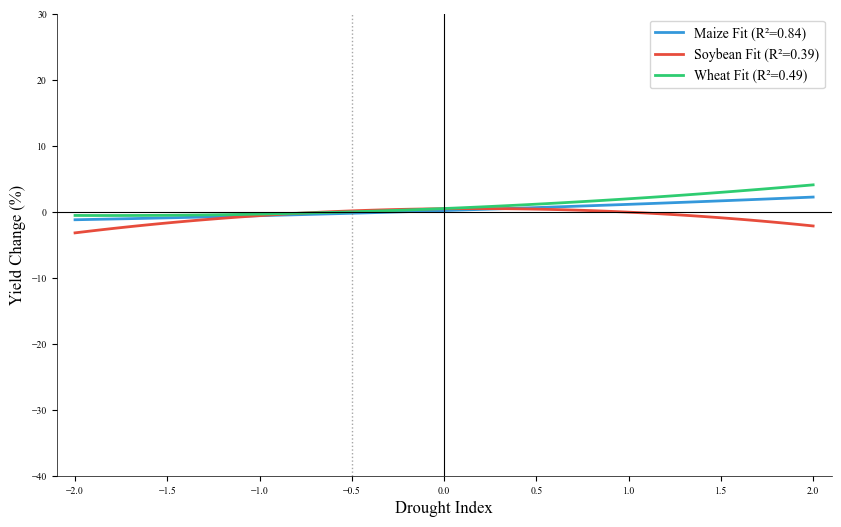


ssp585 拟合结果 (-2到2范围):
mai:
  参数: a=0.18, b=0.86, c=0.08
  使用数据点: 200
  R²: 0.840
  RMSE: 0.216
soy:
  参数: a=0.46, b=0.26, c=-0.78
  使用数据点: 200
  R²: 0.386
  RMSE: 0.351
whe:
  参数: a=0.48, b=1.16, c=0.32
  使用数据点: 200
  R²: 0.488
  RMSE: 0.692


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# 1. 定义多项式拟合函数
def polynomial(x, a, b, c):
    """二次多项式函数：a + b*x + c*x^2"""
    return a + b*x + c*x**2

# 2. 拟合和评估函数（限制在-2到2之间）
def fit_polynomial(x_data, y_data):
    """执行多项式拟合并评估（仅使用-2到2范围内的数据）"""
    # 移除nan值并限制范围
    mask = (~np.isnan(x_data)) & (~np.isnan(y_data)) & (x_data >= -1) & (x_data <= 1)
    x_clean = x_data[mask]
    y_clean = y_data[mask]
    
    if len(x_clean) < 5:  # 数据点不足
        return None
    
    try:
        # 执行二次多项式拟合
        popt, pcov = curve_fit(polynomial, x_clean, y_clean, p0=[0, 0, 0])
        
        # 计算评估指标
        y_pred = polynomial(x_clean, *popt)
        r2 = r2_score(y_clean, y_pred)
        rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
        
        return {
            'params': popt,
            'cov': pcov,
            'r2': r2,
            'rmse': rmse,
            'x_clean': x_clean,
            'y_clean': y_clean
        }
    except Exception as e:
        print(f"多项式拟合失败: {str(e)}")
        return None

# 3. 为每个SSP绘制所有作物的响应曲线
def plot_ssp_response(results, ssp, save_path=None):
    """绘制同一SSP下所有作物的响应曲线"""
    plt.figure(figsize=(10, 6))
    plt.rcParams["font.family"] = "Times New Roman"
    # 定义作物颜色和样式
    crop_styles = {
        'mai': {'color': '#3498db', 'marker': 'o', 'label': 'Maize'},
        'soy': {'color': '#e74c3c', 'marker': 's', 'label': 'Soybean'},
        'whe': {'color': '#2ecc71', 'marker': '^', 'label': 'Wheat'}
    }
    
    # 为每个作物拟合并绘制曲线
    for crop in crops:
        if ssp not in results or crop not in results[ssp]:
            continue
            
        data = results[ssp][crop]
        x_data = np.array(data['bins'])
        y_data = np.array(data['yield_mean'])
        
        # 执行多项式拟合（仅使用-2到2的数据）
        fit_result = fit_polynomial(x_data, y_data)
        
        if fit_result:
            x_clean = fit_result['x_clean']
            y_clean = fit_result['y_clean']
            params = fit_result['params']
            r2 = fit_result['r2']
            
            # 绘制原始数据点（全部数据）
            # plt.scatter(x_data, y_data, 
            #            color=crop_styles[crop]['color'],
            #            marker=crop_styles[crop]['marker'],
            #            alpha=0.3,  # 全部数据透明度降低
            #            label=f'{crop_styles[crop]["label"]} (All data)')
            
            # 绘制用于拟合的数据点（-2到2）
            # plt.scatter(x_clean, y_clean,
            #            color=crop_styles[crop]['color'],
            #            marker=crop_styles[crop]['marker'],
            #            alpha=0.7,  # 拟合数据更明显
            #            label=f'{crop_styles[crop]["label"]} (Fit data)')
            
            # 绘制拟合曲线（仅在-2到2范围内）
            x_smooth = np.linspace(-2, 2, 100)
            y_smooth = polynomial(x_smooth, *params)
            
            plt.plot(x_smooth, y_smooth, 
                    color=crop_styles[crop]['color'],
                    linestyle='-',
                    linewidth=2,
                    label=f'{crop_styles[crop]["label"]} Fit (R²={r2:.2f})')
    
    # 图形装饰
    # plt.title(f'Crop Yield Response to Drought ({ssp})\n(Fitted range: -2 to 2)', fontsize=14)
    plt.xlabel('Drought Index', fontsize=12)
    plt.ylabel('Yield Change (%)', fontsize=12)
    
    # 添加参考线
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(-0.5, color='gray', linestyle=':', alpha=0.7)
    # plt.axvline(-2, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    # plt.axvline(2, color='red', linestyle='--', alpha=0.5, linewidth=0.5)
    
    # plt.grid(alpha=0.2)
    plt.legend(fontsize=10, frameon=True)
    
    # 统一坐标范围
    plt.xlim(-2.1, 2.1)  # 仍显示-3到3的全范围
    plt.ylim(-40, 30)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['top'].set_visible(False)    # 隐藏顶部边框
    plt.show()
    plt.close()

# 4. 主分析流程
def analyze_all_results(results):
    """分析所有结果并绘制综合图表"""
    # 为每个SSP情景绘制图表
    for ssp in ssps:
        plot_ssp_response(results, ssp)
        
        # 打印拟合结果
        print(f"\n{ssp} 拟合结果 (-2到2范围):")
        for crop in crops:
            if ssp in results and crop in results[ssp]:
                data = results[ssp][crop]
                x_data = np.array(data['bins'])
                y_data = np.array(data['yield_mean'])
                
                fit_result = fit_polynomial(x_data, y_data)
                if fit_result:
                    print(f"{crop}:")
                    print(f"  参数: a={fit_result['params'][0]:.2f}, b={fit_result['params'][1]:.2f}, c={fit_result['params'][2]:.2f}")
                    print(f"  使用数据点: {len(fit_result['x_clean'])}")
                    print(f"  R²: {fit_result['r2']:.3f}")
                    print(f"  RMSE: {fit_result['rmse']:.3f}")

# 5. 执行分析
if __name__ == '__main__':
    # 运行分析
    analyze_all_results(results2)

In [55]:
result_dict1[ssp][crop]['yield']

<xarray.DataArray (time: 84, lat: 360, lon: 720)> Size: 174MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 672B 2016-01-01 2017-01-01 ... 2099-01-01

In [57]:
result_dict2[ssp][crop]['expect_yield'][:-1]

<xarray.DataArray 'expected_yield' (time: 85, lat: 360, lon: 720)> Size: 88MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 680B 2015-12-31 2016-12-31 ... 2099-12-31
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

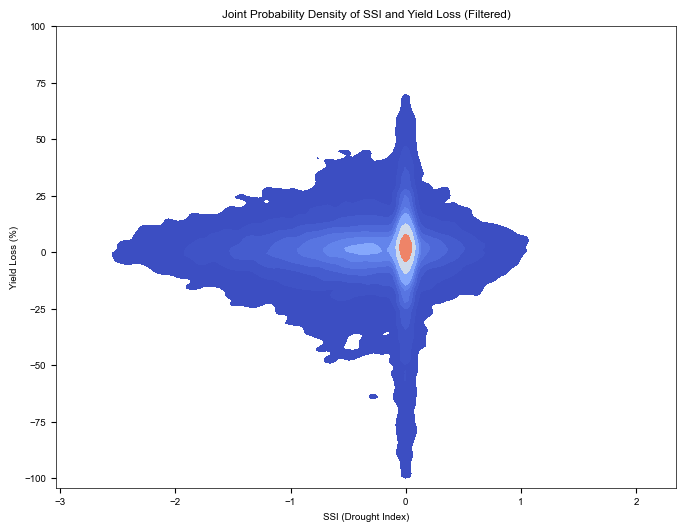

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
mk=dominant_type == 1
expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1]
yied=result_dict1[ssp][crop]['yield'][-idx:]
expect_yield=expect_yield[-len(yied):]
expect_yield['time']=yied.time.values
# yied = yied.where(yied>0.1)
yield_loss=(yied-expect_yield)/yied*100
ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:]
spei=result_dict1[ssp][crop]['spei'][:,:,-idx:]
spei['time']=yied.time.values
ssi['time']=yied.time.values
# 假设 ssi 和 yield_loss 是 xarray.DataArray，展平成1维
ssi_all = spei.values.flatten()
yield_loss_all = yield_loss.values.flatten()

# 先去掉 NaN
mask = (~np.isnan(ssi_all)) & (~np.isnan(yield_loss_all))

ssi_all = ssi_all[mask]
yield_loss_all = yield_loss_all[mask]

# 过滤异常值，举例阈值为 [-100%, 100%]
valid_mask = (yield_loss_all > -100) & (yield_loss_all < 100)

ssi_all = ssi_all[valid_mask]
yield_loss_all = yield_loss_all[valid_mask]

# 绘制联合概率密度
plt.figure(figsize=(8,6))
sns.kdeplot(x=ssi_all, y=yield_loss_all, cmap="coolwarm", fill=True, bw_adjust=0.5)
plt.xlabel('SSI (Drought Index)')
plt.ylabel('Yield Loss (%)')
plt.title('Joint Probability Density of SSI and Yield Loss (Filtered)')
plt.show()

In [73]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ssp='historical';crop='mai'
dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
mk=dominant_type == 1
expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1].where(mk)
yied=result_dict1[ssp][crop]['yield'][-idx:].where(mk)
expect_yield=expect_yield[-len(yied):]
expect_yield['time']=yied.time.values
# yied = yied.where(yied>0.1)
yield_loss=(yied-expect_yield)/yied*100
ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:].where(mk)
spei=result_dict1[ssp][crop]['spei'][:,:,-idx:].where(mk)
spei['time']=yied.time.values
ssi['time']=yied.time.values

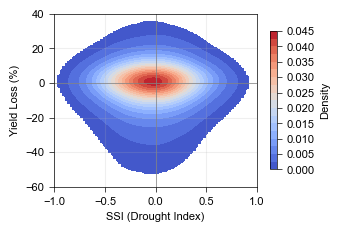

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib as mpl

# 1. 设置字体等以符合期刊规范
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 8
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# 2. 扁平化数据、去除异常
ssi_all = ssi.values.flatten()
yield_loss_all = ((yied - expect_yield) / yied * 100).values.flatten()

mask = (~np.isnan(ssi_all)) & (~np.isnan(yield_loss_all))
ssi_all = ssi_all[mask]
yield_loss_all = yield_loss_all[mask]

valid_mask = (yield_loss_all > -100) & (yield_loss_all < 100)
ssi_all = ssi_all[valid_mask]
yield_loss_all = yield_loss_all[valid_mask]

# # 3. KDE估计密度
# xy = np.vstack([ssi_all, yield_loss_all])
# kde = gaussian_kde(xy, bw_method=0.3)  # 可调带宽

# # 网格化坐标
# xgrid = np.linspace(-2.5, 2.5, 200)
# ygrid = np.linspace(-60, 40, 200)
# X, Y = np.meshgrid(xgrid, ygrid)
# Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# 4. 设置密度下限阈值（去除太小概率的区域）
density_threshold = 0.001  # 根据数据可调，比如 1e-5 ~ 1e-3
Z_masked = np.ma.masked_where(Z < density_threshold, Z)

# 5. 绘图
fig_width_cm = 8.7
fig_height_cm = 6
fig, ax = plt.subplots(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))

cmap = plt.get_cmap("coolwarm")
cf = ax.contourf(X, Y, Z_masked, levels=20, cmap=cmap)

# 6. 装饰
ax.set_xlabel('SSI (Drought Index)')
ax.set_ylabel('Yield Loss (%)')
ax.set_xlim(-1, 1)
# ax.set_ylim(-25, 25)
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
ax.grid(alpha=0.2)
cbar = fig.colorbar(cf, ax=ax, shrink=0.8, pad=0.05)
cbar.set_label('Density', fontsize=8)

plt.tight_layout()

# 7. 保存为矢量图
# plt.savefig("joint_density_yield_ssi.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()


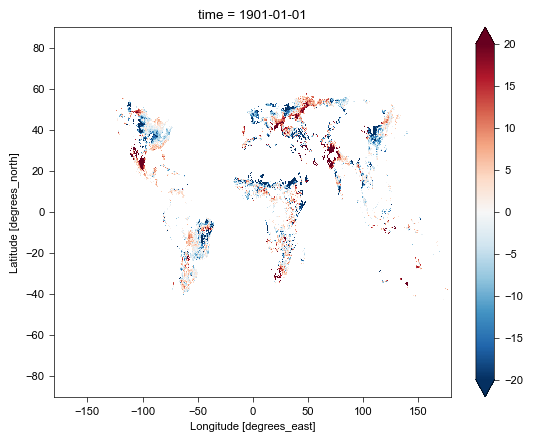

In [90]:
yield_loss=(yied-expect_yield)/yied*100
yield_loss[0].plot(vmax=20)

In [97]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ssp='historical';crop='mai'
dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
mk=dominant_type == 3
expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1].where(mk)
yied=result_dict1[ssp][crop]['yield'][-idx:].where(mk)
expect_yield=expect_yield[-len(yied):]
expect_yield['time']=yied.time.values
# yied = yied.where(yied>0.1)
yield_loss=(yied-expect_yield)/yied*100
ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:].where(mk)
spei=result_dict1[ssp][crop]['spei'][:,:,-idx:].where(mk)
spei['time']=yied.time.values
ssi['time']=yied.time.values
ssi_all = ssi.values.flatten()
yield_loss_all = ((yied - expect_yield) / yied * 100).values.flatten()

mask = (~np.isnan(ssi_all)) & (~np.isnan(yield_loss_all))
ssi_all = ssi_all[mask]
yield_loss_all = yield_loss_all[mask]

valid_mask = (yield_loss_all > -100) & (yield_loss_all < 100)
ssi_all = ssi_all[valid_mask]
yield_loss_all = yield_loss_all[valid_mask]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15452\2919292207.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('ssi_bin').agg({


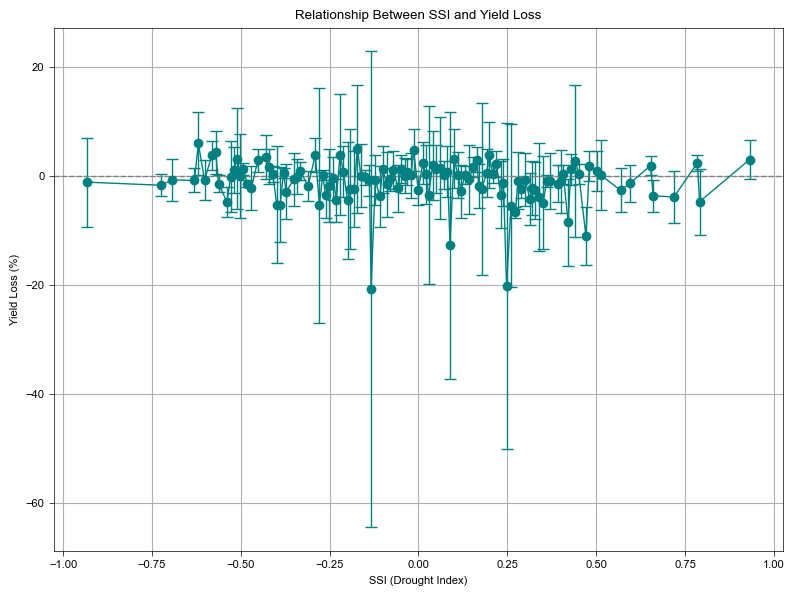

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ssp='historical';crop='mai'
dominant_type = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type
mk=dominant_type == 1
expect_yield=result_dict2[ssp][crop]['expect_yield'][:-1].where(mk)
yied=result_dict1[ssp][crop]['yield'][-idx:].where(mk)
expect_yield=expect_yield[-len(yied):]
expect_yield['time']=yied.time.values
# yied = yied.where(yied>0.1)
yield_loss=(yied-expect_yield)/yied*100
ssi=result_dict1[ssp][crop]['ssi'][:,:,-idx:].where(mk)
spei=result_dict1[ssp][crop]['spei'][:,:,-idx:].where(mk)
spei['time']=yied.time.values
ssi['time']=yied.time.values
ssi_all = spei.values.flatten()
yield_loss_all = ((yied - expect_yield) / yied * 100).values.flatten()

mask = (~np.isnan(ssi_all)) & (~np.isnan(yield_loss_all))
ssi_all = ssi_all[mask]
yield_loss_all = yield_loss_all[mask]

valid_mask = (yield_loss_all > -100) & (yield_loss_all < 100)
ssi_all = ssi_all[valid_mask]
yield_loss_all = yield_loss_all[valid_mask]
# 转为 DataFrame
df = pd.DataFrame({
    'ssi': ssi_all,
    'yield_loss': yield_loss_all
})

# 分箱（可调整 bin 宽度）
bins = np.linspace(-3, 3, 600)
df['ssi_bin'] = pd.cut(df['ssi'], bins)

# 计算每个 bin 内的均值和标准差
grouped = df.groupby('ssi_bin').agg({
    'ssi': 'mean',
    'yield_loss': ['mean', 'std', 'count']
}).dropna()

# 解包列名
grouped.columns = ['ssi_mean', 'yield_loss_mean', 'yield_loss_std', 'count']

# 画图
plt.figure(figsize=(8,6))
plt.errorbar(grouped['ssi_mean'], grouped['yield_loss_mean'], 
             yerr=grouped['yield_loss_std'], fmt='o-', capsize=4, color='teal')

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('SSI (Drought Index)')
plt.ylabel('Yield Loss (%)')
plt.title('Relationship Between SSI and Yield Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


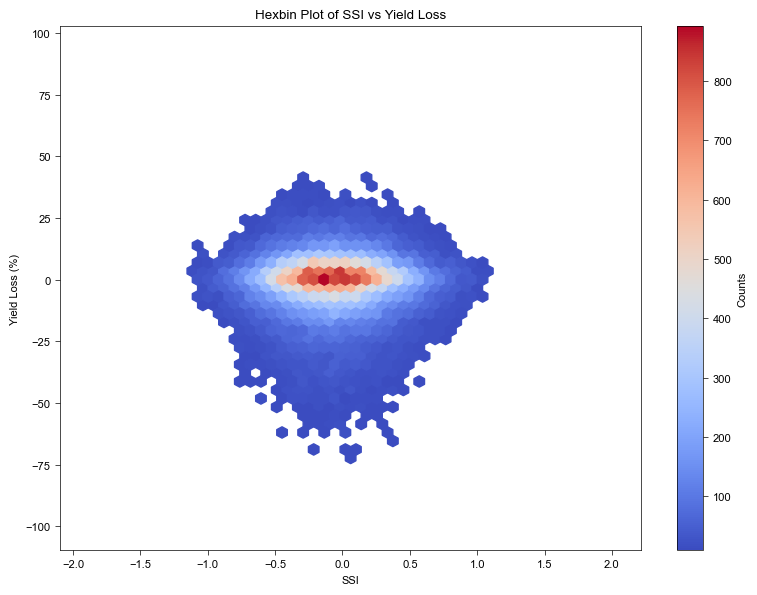

In [91]:
plt.figure(figsize=(8,6))
hb = plt.hexbin(ssi_all, yield_loss_all, gridsize=50, cmap='coolwarm', mincnt=10)
cb = plt.colorbar(hb)
cb.set_label('Counts')
plt.xlabel('SSI')
plt.ylabel('Yield Loss (%)')
plt.title('Hexbin Plot of SSI vs Yield Loss')
plt.tight_layout()
plt.show()


In [26]:
spei_data.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-01"))

<xarray.DataArray 'spei' (time: 48)> Size: 384B
[48 values with dtype=float64]
Coordinates:
    lon      float64 8B 21.25
    lat      float64 8B -21.25
  * time     (time) datetime64[ns] 384B 1950-01-01 1950-02-01 ... 1953-12-01

In [18]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join

# 1. 加载玉米种植和成熟月份数据
crop = 'mai'
crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
crop_data = xr.open_dataset(crop_calendar_path)
spei_path = r'D:\AAUDE\paper\paper8\data\result2\spei_scale3_Historical_median_all.nc'
spei_data = xr.open_dataset(spei_path).spei

start_year = 1950;end_year=1953
years = np.arange(start_year, end_year)
lat = crop_data.lat;lon = crop_data.lon
all_months = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-01", freq='MS')
total_months = len(all_months)

spei = spei_data.sel(time=slice(f"{start_year}-01-01", f"{end_year}-01-01"))
is_cross=crop_data.maturity_day<=crop_data.planting_day
mask=np.zeros((total_months, spei['lat'].size, spei['lon'].size), dtype=bool)
planting_month = crop_data['planting_month']  
maturity_month = crop_data['maturity_month']  

spei_mean = np.zeros((years.size,spei['lat'].size, spei['lon'].size)) * np.nan
for y_idx, year in enumerate(years):
    spei_mean[y_idx]
    if not is_cross_year:
        spei_mean[y_idx]=spei_data.sel(time=slice(f"{year}-{int(planting_month)}-01", f"{year}-{int(maturity_month)}-01")).mean(dim='time').values

    else:
         spei_mean[y_idx]=spei_data.sel(time=slice(f"{year}-{int(planting_month)}-01", f"{year+1}-{int(maturity_month)}-01")).mean(dim='time').values
         # print(slice(f"{year}-{int(planting_month)}-01", f"{year+1}-{int(maturity_month)}-01"))



# 8. 转换为 xarray DataArray 并保存
result = xr.DataArray(
    spei_growing_season_mean,
    dims=['lat', 'lon'],
    coords={'lat': spei_data['lat'], 'lon': spei_data['lon']},
    name='spei_growing_season_mean'
)

# 9. 保存结果
# output_path = join(r'D:\AAUDE\paper\paper8\data\result2', 'spei_mai_growing_season_1950.nc')
result.to_netcdf(output_path)

TypeError: 'DataArray' object is not callable

In [21]:
crop = 'mai'
crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
crop_data = xr.open_dataset(crop_calendar_path)
spei_path = r'D:\AAUDE\paper\paper8\data\result2\spei_scale3_Historical_median_all.nc'
spei_data = xr.open_dataset(spei_path).spei[222,402]

start_year = 1950;end_year=1953
years = np.arange(start_year, end_year)
lat = crop_data.lat;lon = crop_data.lon
all_months = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-01", freq='MS')
total_months = len(all_months)

spei = spei_data.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-01"))
is_cross=crop_data.maturity_day[222,402]<=crop_data.planting_day[222,402]
mask=np.zeros((total_months, spei['lat'].size, spei['lon'].size), dtype=bool)
planting_month = crop_data['planting_month'][222,402] 
maturity_month = crop_data['maturity_month'][222,402]

In [30]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join

# 1. 加载数据
crop = 'mai'
crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
crop_data = xr.open_dataset(crop_calendar_path)
spei_path = r'D:\AAUDE\paper\paper8\data\result2\spei_scale3_Historical_median_all.nc'
spei_data = xr.open_dataset(spei_path).spei[222, 402]  # 提取单个格点 (lat=222, lon=402)

# 2. 设置时间范围
start_year, end_year = 1950, 1953
years = np.arange(start_year, end_year)  # 包含 end_year
all_months = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-01", freq='MS')  # 月度数据

# 3. 提取该格点的种植和成熟信息
planting_day = crop_data['planting_day'][222, 402].values  # 种植日（年积日）
maturity_day = crop_data['maturity_day'][222, 402].values  # 成熟日（年积日）
planting_month = crop_data['planting_month'][222, 402].values  # 种植月份
maturity_month = crop_data['maturity_month'][222, 402].values  # 成熟月份

# 4. 判断是否跨年
is_cross_year = (maturity_day <= planting_day)  # 如果成熟日 ≤ 种植日，说明跨年
spei_mean = np.zeros((years.size)) * np.nan
# 5. 生成生长季掩码（标记哪些月份属于生长季）
mask = np.zeros(len(all_months), dtype=bool)  # 初始化掩码
for y_idx, year in enumerate(years):
    spei_mean[y_idx]
    if not is_cross_year:
        spei_mean[y_idx]=spei_data.sel(time=slice(f"{year}-{int(planting_month)}-01", f"{year}-{int(maturity_month)}-01")).mean(dim='time').values

    else:
         spei_mean[y_idx]=spei_data.sel(time=slice(f"{year}-{int(planting_month)}-01", f"{year+1}-{int(maturity_month)}-01")).mean(dim='time').values


print(f"生长季 SPEI 均值：{spei_mean}")

slice('1950-11-01', '1951-5-01', None)
slice('1951-11-01', '1952-5-01', None)
slice('1952-11-01', '1953-5-01', None)
格点 (lat=222, lon=402) 的生长季月份：
生长季 SPEI 均值：[-0.3369171  -0.39493651 -0.1249145 ]


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
from dask import delayed
import dask.array as da
from dask.diagnostics import ProgressBar

# 1. 加载数据
crop = 'mai'
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
spei_path = r'D:\AAUDE\paper\paper8\data\result2\spei_scale3_Historical_median_all.nc'

crop_data = xr.open_dataset(crop_calendar_path)
spei_data = xr.open_dataset(spei_path)

# 2. 时间范围
start_year, end_year = 1901, 2014
years = np.arange(start_year, end_year)

# 3. 并行计算函数
def calculate_growing_season_spei(lat_idx, lon_idx):
    planting_day = crop_data['planting_day'].where(area > 0)[lat_idx, lon_idx].values
    maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values

    if np.isnan(planting_day) or np.isnan(maturity_day):
        return np.full(len(years), np.nan)

    # 修正：逐像元提取月份
    planting_month = crop_data['planting_month'][lat_idx, lon_idx].values
    maturity_month = crop_data['maturity_month'][lat_idx, lon_idx].values

    if np.isnan(planting_month) or np.isnan(maturity_month):
        return np.full(len(years), np.nan)

    is_cross_year = (maturity_day <= planting_day)

    spei_vals = []
    for year in years:
        try:
            if not is_cross_year:
                start = f"{year}-{int(planting_month):02d}-01"
                end = f"{year}-{int(maturity_month):02d}-01"
            else:
                start = f"{year}-{int(planting_month):02d}-01"
                end = f"{year+1}-{int(maturity_month):02d}-01"

            # 使用 isel 提高效率
            spei = spei_data['spei'].isel(lat=lat_idx, lon=lon_idx).sel(time=slice(start, end))
            spei_mean = spei.mean().values
            spei_vals.append(spei_mean)
        except Exception as e:
            print(f"Error at lat_idx={lat_idx}, lon_idx={lon_idx}, year={year}: {e}")
            spei_vals.append(np.nan)

    return np.array(spei_vals)

# 4. 构造懒加载任务
tasks = []
for i in tqdm(range(len(crop_data.lat))):
    for j in range(len(crop_data.lon)):
        task = delayed(calculate_growing_season_spei)(i, j)
        tasks.append(da.from_delayed(task, shape=(len(years),), dtype=float))

# 5. 合并为 Dask 数组并计算
lazy_results = da.stack(tasks).reshape((len(crop_data.lat), len(crop_data.lon), len(years)))

with ProgressBar():
    computed_results = lazy_results.compute()

# 6. 构建结果 DataArray
result = xr.DataArray(
    computed_results.transpose(2, 0, 1),  # (year, lat, lon)
    dims=['year', 'lat', 'lon'],
    coords={'year': years, 'lat': crop_data.lat, 'lon': crop_data.lon},
    name='spei_gs_mean'
)
result.attrs['description'] = 'Growing season mean SPEI (scale=3)'
result.attrs['units'] = 'dimensionless'
result.attrs['crop'] = crop

# 7. 保存结果
output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_spei_growing_season_mean.nc')
result.to_netcdf(output_path)
print(f"所有格点生长季SPEI均值已保存至: {output_path}")


  0%|          | 0/360 [00:00<?, ?it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 827


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm  # 进度条

# 1. 加载数据
crop = 'mai'
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
spei_path = r'D:\AAUDE\paper\paper8\data\result2\spei_scale3_Historical_median_all.nc'

crop_data = xr.open_dataset(crop_calendar_path)
spei_data = xr.open_dataset(spei_path)

# 2. 时间范围
start_year, end_year = 1901, 2014
years = np.arange(start_year, end_year)

# 3. 预分配结果数组
result = np.full((len(years), len(crop_data.lat), len(crop_data.lon)), np.nan)

# 4. 逐格点计算（顺序执行）
for lat_idx in tqdm(range(len(crop_data.lat)), desc='处理纬度'):
    for lon_idx in range(len(crop_data.lon)):
        # 跳过非种植区
        if area[lat_idx, lon_idx].values <= 0:
            continue
            
        planting_day = crop_data['planting_day'][lat_idx, lon_idx].values
        maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values
        
        # 跳过无效数据
        if np.isnan(planting_day) or np.isnan(maturity_day):
            continue
            
        # 直接使用预计算的月份（更准确）
        planting_month = int(crop_data['planting_month'][lat_idx, lon_idx].values)
        maturity_month = int(crop_data['maturity_month'][lat_idx, lon_idx].values)
        
        # 判断是否跨年
        is_cross_year = (maturity_day <= planting_day)
        
        # 计算每年的生长季SPEI
        for y_idx, year in enumerate(years):
            try:
                if not is_cross_year:
                    start = f"{year}-{planting_month:02d}-01"
                    end = f"{year}-{maturity_month:02d}-01"
                else:
                    start = f"{year}-{planting_month:02d}-01"
                    end = f"{year+1}-{maturity_month:02d}-01"
                
                # 提取生长季数据并计算均值
                spei_slice = spei_data['spei'].sel(
                    lat=crop_data.lat[lat_idx],
                    lon=crop_data.lon[lon_idx],
                    time=slice(start, end)
                )
                result[y_idx, lat_idx, lon_idx] = spei_slice.mean().values
            except Exception as e:
                print(f"Error at lat={crop_data.lat[lat_idx].values}, lon={crop_data.lon[lon_idx].values}, year={year}: {str(e)}")
                continue

# 5. 转换为xarray并保存
result_da = xr.DataArray(
    result,
    dims=['year', 'lat', 'lon'],
    coords={
        'year': years,
        'lat': crop_data.lat,
        'lon': crop_data.lon
    },
    name='spei_gs_mean'
)

# 添加元数据
result_da.attrs = {
    'description': 'Growing season mean SPEI (scale=3), year refers to sowing year',
    'units': 'dimensionless',
    'crop': crop,
    'calculation_method': 'Sequential non-parallel'
}

output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_spei_growing_season_mean_sequential.nc')
result_da.to_netcdf(output_path)
print(f"顺序计算完成，结果已保存至: {output_path}")

处理纬度:   0%|          | 0/360 [00:00<?, ?it/s]


KeyboardInterrupt


KeyboardInterrupt



In [13]:
sample_lat, sample_lon = 100, 200  # 调整为您数据中的有效位置
print("示例格点信息:")
print("种植日:", planting_day[sample_lat, sample_lon].item())
print("成熟日:", maturity_day[sample_lat, sample_lon].item())
print("种植月:", planting_month[sample_lat, sample_lon].item())
print("成熟月:", maturity_month[sample_lat, sample_lon].item())

示例格点信息:
种植日: 121.0
成熟日: 283.0
种植月: 5.0
成熟月: 10.0


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm  # 进度条
import dask
from dask import delayed, compute

# 1. 加载数据
crop = 'mai'
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
# 为了不重复打开两次文件，可先打开后取变量
ds_area = xr.open_dataset(area_path)
area = ds_area[list(ds_area.data_vars)[0]]
crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
spei_path = r'D:\AAUDE\paper\paper8\data\result2\spei_scale3_Historical_median_all.nc'

crop_data = xr.open_dataset(crop_calendar_path)
spei_data = xr.open_dataset(spei_path)

# 2. 时间范围
start_year, end_year = 1901, 2014
years = np.arange(start_year, end_year)

# 定义针对一块纬度（若干行）的处理函数（注意：这部分函数将在 delayed 任务中执行）
def process_lat_chunk(lat_indices):
    # 分配该块的结果，形状：(年份, 本块纬度个数, 经度数)
    sub_result = np.full((len(years), len(lat_indices), len(crop_data.lon)), np.nan)

    # 对每个格点进行循环计算
    for i, lat_idx in enumerate(lat_indices):
        for lon_idx in range(len(crop_data.lon)):
            # 检查非种植区条件
            if area[lat_idx, lon_idx].values <= 0:
                continue

            # 提取种植日和成熟日
            planting_day = crop_data['planting_day'][lat_idx, lon_idx].values
            maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values
            if np.isnan(planting_day) or np.isnan(maturity_day):
                continue

            # 使用预计算的月份
            planting_month = int(crop_data['planting_month'][lat_idx, lon_idx].values)
            maturity_month = int(crop_data['maturity_month'][lat_idx, lon_idx].values)

            # 判断是否跨年
            is_cross_year = (maturity_day <= planting_day)

            # 对每一年计算对应生长季内 SPEI 均值
            for y_idx, year in enumerate(years):
                try:
                    if not is_cross_year:
                        start = f"{year}-{planting_month:02d}-01"
                        end = f"{year}-{maturity_month:02d}-01"
                    else:
                        start = f"{year}-{planting_month:02d}-01"
                        end = f"{year+1}-{maturity_month:02d}-01"

                    # 提取生长季数据并计算均值（沿时间维度计算）
                    spei_slice = spei_data['spei'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start, end)
                    )
                    # 计算均值后赋值
                    sub_result[y_idx, i, lon_idx] = float(spei_slice.mean().values)
                except Exception as e:
                    print(f"Error at lat={crop_data.lat[lat_idx].values}, lon={crop_data.lon[lon_idx].values}, year={year}: {str(e)}")
                    continue
    return sub_result

# 3. 构造分块任务
# 设定分块大小，根据实际数据量调节，以下示例中每10个纬度为一块
chunk_size = 60
lat_indices = np.arange(len(crop_data.lat))
chunks = [lat_indices[i:i+chunk_size] for i in range(0, len(crop_data.lat), chunk_size)]

# 使用 dask.delayed 构造多个任务
tasks = [delayed(process_lat_chunk)(chunk) for chunk in chunks]

# 4. 计算所有任务
results_chunks = compute(*tasks)

# 5. 拼接各块结果，注意 axis=1 是纬度方向
result = np.concatenate(results_chunks, axis=1)

# 6. 转换为 xarray.DataArray 并保存
result_da = xr.DataArray(
    result,
    dims=['year', 'lat', 'lon'],
    coords={
        'year': years,
        'lat': crop_data.lat,
        'lon': crop_data.lon
    },
    name='spei_gs_mean'
)

# 添加元数据
result_da.attrs = {
    'description': 'Growing season mean SPEI (scale=3), year refers to sowing year',
    'units': 'dimensionless',
    'crop': crop,
    'calculation_method': 'Chunked parallel using dask.delayed'
}

output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_spei_growing_season_mean_chunked.nc')
result_da.to_netcdf(output_path)
print(f"基于 chunked 的并行计算完成，结果已保存至: {output_path}")



KeyboardInterrupt


KeyboardInterrupt



In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
ss=['historical','ssp126','ssp585']
crops = ['mai', 'swh','wwh', 'soy']
for crop in crops[:]:
    for ssp in ss:
# crop = 'swh'
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
        spei_path = rf'D:\AAUDE\paper\paper8\data\result2\spei_scale3_{ssp}_median_all.nc'
        
        crop_data = xr.open_dataset(crop_calendar_path)
        spei_data = xr.open_dataset(spei_path)
        
        if ssp=='historical':
            start_year, end_year = 1901, 2014
        else:
            start_year, end_year = 2015, 2100
        years = np.arange(start_year, end_year)
        
        # 3. 并行处理函数
        def compute_pixel_spei(lat_idx, lon_idx):
            if area[lat_idx, lon_idx].values <= 0:
                return None
        
            planting_day = crop_data['planting_day'][lat_idx, lon_idx].values
            maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values
        
            if np.isnan(planting_day) or np.isnan(maturity_day):
                return None
        
            try:
                planting_month = int(crop_data['planting_month'][lat_idx, lon_idx].values)
                maturity_month = int(crop_data['maturity_month'][lat_idx, lon_idx].values)
            except:
                return None
        
            is_cross_year = (maturity_day <= planting_day)
            pixel_series = []
        
            for year in years:
                try:
                    if not is_cross_year:
                        start = f"{year}-{planting_month:02d}-01"
                        end = f"{year}-{maturity_month:02d}-01"
                    else:
                        start = f"{year}-{planting_month:02d}-01"
                        end = f"{year+1}-{maturity_month:02d}-01"
        
                    spei_slice = spei_data['spei'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start, end)
                    )
                    pixel_series.append(spei_slice.mean().values)
                except:
                    pixel_series.append(np.nan)
        
            return (lat_idx, lon_idx, pixel_series)
        
        # 4. 并行执行
        lat_len = len(crop_data.lat)
        lon_len = len(crop_data.lon)
        all_coords = [(i, j) for i in range(lat_len) for j in range(lon_len)]
        
        results = Parallel(n_jobs=-1)(delayed(compute_pixel_spei)(i, j) for i, j in tqdm(all_coords, desc="并行处理"))
        
        # 5. 填充结果数组
        result = np.full((len(years), lat_len, lon_len), np.nan)
        for item in results:
            if item is None:
                continue
            lat_idx, lon_idx, series = item
            result[:, lat_idx, lon_idx] = series
        
        # 6. 转换为xarray并保存
        result_da = xr.DataArray(
            result,
            dims=['year', 'lat', 'lon'],
            coords={
                'year': years,
                'lat': crop_data.lat,
                'lon': crop_data.lon
            },
            name='spei_gs_mean'
        )
        
        result_da.attrs = {
            'description': 'Growing season mean SPEI (scale=3), year refers to sowing year',
            'units': 'dimensionless',
            'crop': crop,
            'calculation_method': 'Parallel with joblib'
        }
        
        output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_{ssp}_spei_growing_season_mean_parallel.nc')
        result_da.to_netcdf(output_path)
        print(f"并行计算完成，结果已保存至: {output_path}")


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_historical_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_ssp126_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_ssp585_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_historical_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_ssp126_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_ssp585_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_historical_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_ssp126_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_ssp585_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_historical_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_ssp126_spei_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_ssp585_spei_growing_season_mean_parallel.nc


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
ss=['historical','ssp126','ssp585']
crops = ['mai', 'swh','wwh', 'soy']
for crop in crops[2:]:
    for ssp in ss:
# crop = 'swh'
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
        spei_path = rf'D:\AAUDE\paper\paper8\data\result2\ssi_scale3_{crop}_{ssp}_median_all.nc'
        
        crop_data = xr.open_dataset(crop_calendar_path)
        spei_data = xr.open_dataset(spei_path)
        
        if ssp=='historical':
            start_year, end_year = 1901, 2014
        else:
            start_year, end_year = 2015, 2100
        years = np.arange(start_year, end_year)
        
        # 3. 并行处理函数
        def compute_pixel_spei(lat_idx, lon_idx):
            if area[lat_idx, lon_idx].values <= 0:
                return None
        
            planting_day = crop_data['planting_day'][lat_idx, lon_idx].values
            maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values
        
            if np.isnan(planting_day) or np.isnan(maturity_day):
                return None
        
            try:
                planting_month = int(crop_data['planting_month'][lat_idx, lon_idx].values)
                maturity_month = int(crop_data['maturity_month'][lat_idx, lon_idx].values)
            except:
                return None
        
            is_cross_year = (maturity_day <= planting_day)
            pixel_series = []
        
            for year in years:
                try:
                    if not is_cross_year:
                        start = f"{year}-{planting_month:02d}-01"
                        end = f"{year}-{maturity_month:02d}-01"
                    else:
                        start = f"{year}-{planting_month:02d}-01"
                        end = f"{year+1}-{maturity_month:02d}-01"
        
                    spei_slice = spei_data['ssi'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start, end)
                    )
                    pixel_series.append(spei_slice.mean().values)
                except:
                    pixel_series.append(np.nan)
        
            return (lat_idx, lon_idx, pixel_series)
        
        # 4. 并行执行
        lat_len = len(crop_data.lat)
        lon_len = len(crop_data.lon)
        all_coords = [(i, j) for i in range(lat_len) for j in range(lon_len)]
        
        results = Parallel(n_jobs=-1)(delayed(compute_pixel_spei)(i, j) for i, j in tqdm(all_coords, desc="并行处理"))
        
        # 5. 填充结果数组
        result = np.full((len(years), lat_len, lon_len), np.nan)
        for item in results:
            if item is None:
                continue
            lat_idx, lon_idx, series = item
            result[:, lat_idx, lon_idx] = series
        
        # 6. 转换为xarray并保存
        result_da = xr.DataArray(
            result,
            dims=['year', 'lat', 'lon'],
            coords={
                'year': years,
                'lat': crop_data.lat,
                'lon': crop_data.lon
            },
            name='ssi_gs_mean'
        )
        
        result_da.attrs = {
            'description': 'Growing season mean SSI (scale=3), year refers to sowing year',
            'units': 'dimensionless',
            'crop': crop,
            'calculation_method': 'Parallel with joblib'
        }
        
        output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_{ssp}_ssi_growing_season_mean_parallel.nc')
        result_da.to_netcdf(output_path)
        print(f"并行计算完成，结果已保存至: {output_path}")


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_historical_ssi_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_ssp126_ssi_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_ssp585_ssi_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_historical_ssi_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_ssp126_ssi_growing_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_ssp585_ssi_growing_season_mean_parallel.nc


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
def adjust_month_year(base_year, base_month, delta_months):
    new_month = base_month - delta_months
    if new_month <= 0:
        adjusted_year = base_year - 1
        adjusted_month = 12 + new_month  # new_month is negative
    else:
        adjusted_year = base_year
        adjusted_month = new_month
    return adjusted_year, adjusted_month

ss=['historical','ssp126','ssp585']
crops = ['mai', 'swh','wwh', 'soy']
for crop in crops[:]:
    for ssp in ss:
# crop = 'swh'
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
        spei_path = rf'D:\AAUDE\paper\paper8\data\result2\spei_scale3_{ssp}_median_all.nc'
        
        crop_data = xr.open_dataset(crop_calendar_path)
        spei_data = xr.open_dataset(spei_path)
        
        if ssp=='historical':
            start_year, end_year = 1901, 2014
        else:
            start_year, end_year = 2015, 2100
        years = np.arange(start_year, end_year)
        
        # 3. 并行处理函数
        def compute_pixel_spei(lat_idx, lon_idx):
            if area[lat_idx, lon_idx].values <= 0:
                return None
        
            planting_day = crop_data['planting_day'][lat_idx, lon_idx].values
            maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values
        
            if np.isnan(planting_day) or np.isnan(maturity_day):
                return None
        
            try:
                planting_month = int(crop_data['planting_month'][lat_idx, lon_idx].values)
                maturity_month = int(crop_data['maturity_month'][lat_idx, lon_idx].values)
            except:
                return None
        
            is_cross_year = (maturity_day <= planting_day)
            pixel_series1 = []
            pixel_series2 = []
        
            for year in years:
                try:
                    year1, month1 = adjust_month_year(year, int(planting_month), 3)
                    start1 = f"{year1}-{month1:02d}-01"
                    
                    # 计算 start2 (6个月前)
                    year2, month2 = adjust_month_year(year, int(planting_month), 6)
                    start2 = f"{year2}-{month2:02d}-01"
                    
                    # 计算 end (1个月前)
                    yeare1, monthe1 = adjust_month_year(year, int(planting_month), 1)
                    end1 = f"{yeare1}-{monthe1:02d}-01"
                    yeare2, monthe2 = adjust_month_year(year, int(planting_month), 4)
                    end2 = f"{yeare2}-{monthe2:02d}-01"

                    pixel_series1.append(spei_data['spei'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start1, end1)
                    ).mean().values)
                    pixel_series2.append(spei_data['spei'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start2, end2)
                    ).mean().values)
                except:
                    pixel_series1.append(np.nan)
                    pixel_series2.append(np.nan)
        
            return (lat_idx, lon_idx, pixel_series1,pixel_series2)
        
        # 4. 并行执行
        lat_len = len(crop_data.lat)
        lon_len = len(crop_data.lon)
        all_coords = [(i, j) for i in range(lat_len) for j in range(lon_len)]
        
        results = Parallel(n_jobs=-1)(delayed(compute_pixel_spei)(i, j) for i, j in tqdm(all_coords, desc="并行处理"))
        
        # 5. 填充结果数组
        result1 = np.full((len(years), lat_len, lon_len), np.nan)
        result2 = np.full((len(years), lat_len, lon_len), np.nan)
        for item in results:
            if item is None:
                continue
            lat_idx, lon_idx, series1,series2 = item
            result1[:, lat_idx, lon_idx] = series1
            result2[:, lat_idx, lon_idx] = series2
        
        # 6. 转换为xarray并保存
        result_da1 = xr.DataArray(
            result1,
            dims=['year', 'lat', 'lon'],
            coords={
                'year': years,
                'lat': crop_data.lat,
                'lon': crop_data.lon
            },
            name='spei_pre3_mean'
        )
        result_da2 = xr.DataArray(
            result2,
            dims=['year', 'lat', 'lon'],
            coords={
                'year': years,
                'lat': crop_data.lat,
                'lon': crop_data.lon
            },
            name='spei_pre6_mean'
        )
        output_ds = xr.Dataset({
            'spei_pre3_mean': result_da1,
            'spei_pre6_mean': result_da2,  
        })

        
        output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_{ssp}_spei_pre_season_mean_parallel.nc')
        output_ds.to_netcdf(output_path)
        print(f"并行计算完成，结果已保存至: {output_path}")

并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_historical_spei_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_ssp126_spei_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_ssp585_spei_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from os.path import join
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
def adjust_month_year(base_year, base_month, delta_months):
    new_month = base_month - delta_months
    if new_month <= 0:
        adjusted_year = base_year - 1
        adjusted_month = 12 + new_month  # new_month is negative
    else:
        adjusted_year = base_year
        adjusted_month = new_month
    return adjusted_year, adjusted_month

ss=['historical','ssp126','ssp585']
crops = ['mai', 'swh','wwh', 'soy']
for crop in crops[:]:
    for ssp in ss:
# crop = 'swh'
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        crop_calendar_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
        spei_path = rf'D:\AAUDE\paper\paper8\data\result2\ssi_scale3_{crop}_{ssp}_median_all.nc'
        
        crop_data = xr.open_dataset(crop_calendar_path)
        spei_data = xr.open_dataset(spei_path)
        
        if ssp=='historical':
            start_year, end_year = 1901, 2014
        else:
            start_year, end_year = 2015, 2100
        years = np.arange(start_year, end_year)
        
        # 3. 并行处理函数
        def compute_pixel_spei(lat_idx, lon_idx):
            if area[lat_idx, lon_idx].values <= 0:
                return None
        
            planting_day = crop_data['planting_day'][lat_idx, lon_idx].values
            maturity_day = crop_data['maturity_day'][lat_idx, lon_idx].values
        
            if np.isnan(planting_day) or np.isnan(maturity_day):
                return None
        
            try:
                planting_month = int(crop_data['planting_month'][lat_idx, lon_idx].values)
                maturity_month = int(crop_data['maturity_month'][lat_idx, lon_idx].values)
            except:
                return None
        
            is_cross_year = (maturity_day <= planting_day)
            pixel_series1 = []
            pixel_series2 = []
        
            for year in years:
                try:
                    year1, month1 = adjust_month_year(year, int(planting_month), 3)
                    start1 = f"{year1}-{month1:02d}-01"
                    
                    # 计算 start2 (6个月前)
                    year2, month2 = adjust_month_year(year, int(planting_month), 6)
                    start2 = f"{year2}-{month2:02d}-01"
                    
                    # 计算 end (1个月前)
                    yeare1, monthe1 = adjust_month_year(year, int(planting_month), 1)
                    end1 = f"{yeare1}-{monthe1:02d}-01"
                    yeare2, monthe2 = adjust_month_year(year, int(planting_month), 4)
                    end2 = f"{yeare2}-{monthe2:02d}-01"

                    pixel_series1.append(spei_data['ssi'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start1, end1)
                    ).mean().values)
                    pixel_series2.append(spei_data['ssi'].sel(
                        lat=crop_data.lat[lat_idx],
                        lon=crop_data.lon[lon_idx],
                        time=slice(start2, end2)
                    ).mean().values)
                except:
                    pixel_series1.append(np.nan)
                    pixel_series2.append(np.nan)
        
            return (lat_idx, lon_idx, pixel_series1,pixel_series2)
        
        # 4. 并行执行
        lat_len = len(crop_data.lat)
        lon_len = len(crop_data.lon)
        all_coords = [(i, j) for i in range(lat_len) for j in range(lon_len)]
        
        results = Parallel(n_jobs=-1)(delayed(compute_pixel_spei)(i, j) for i, j in tqdm(all_coords, desc="并行处理"))
        
        # 5. 填充结果数组
        result1 = np.full((len(years), lat_len, lon_len), np.nan)
        result2 = np.full((len(years), lat_len, lon_len), np.nan)
        for item in results:
            if item is None:
                continue
            lat_idx, lon_idx, series1,series2 = item
            result1[:, lat_idx, lon_idx] = series1
            result2[:, lat_idx, lon_idx] = series2
        
        # 6. 转换为xarray并保存
        result_da1 = xr.DataArray(
            result1,
            dims=['year', 'lat', 'lon'],
            coords={
                'year': years,
                'lat': crop_data.lat,
                'lon': crop_data.lon
            },
            name='ssi_pre3_mean'
        )
        result_da2 = xr.DataArray(
            result2,
            dims=['year', 'lat', 'lon'],
            coords={
                'year': years,
                'lat': crop_data.lat,
                'lon': crop_data.lon
            },
            name='ssi_pre6_mean'
        )
        output_ds = xr.Dataset({
            'ssi_pre3_mean': result_da1,
            'ssi_pre6_mean': result_da2,  
        })

        
        output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_{ssp}_ssi_pre_season_mean_parallel.nc')
        output_ds.to_netcdf(output_path)
        print(f"并行计算完成，结果已保存至: {output_path}")


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_historical_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_ssp126_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_ssp585_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_historical_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_ssp126_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_ssp585_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_historical_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_ssp126_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_ssp585_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_historical_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_ssp126_ssi_pre_season_mean_parallel.nc


并行处理:   0%|          | 0/259200 [00:00<?, ?it/s]

并行计算完成，结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_ssp585_ssi_pre_season_mean_parallel.nc


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\matplotlib\transforms.py:2035: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\matplotlib\transforms.py:2035: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\matplotlib\transforms.py:2035: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx


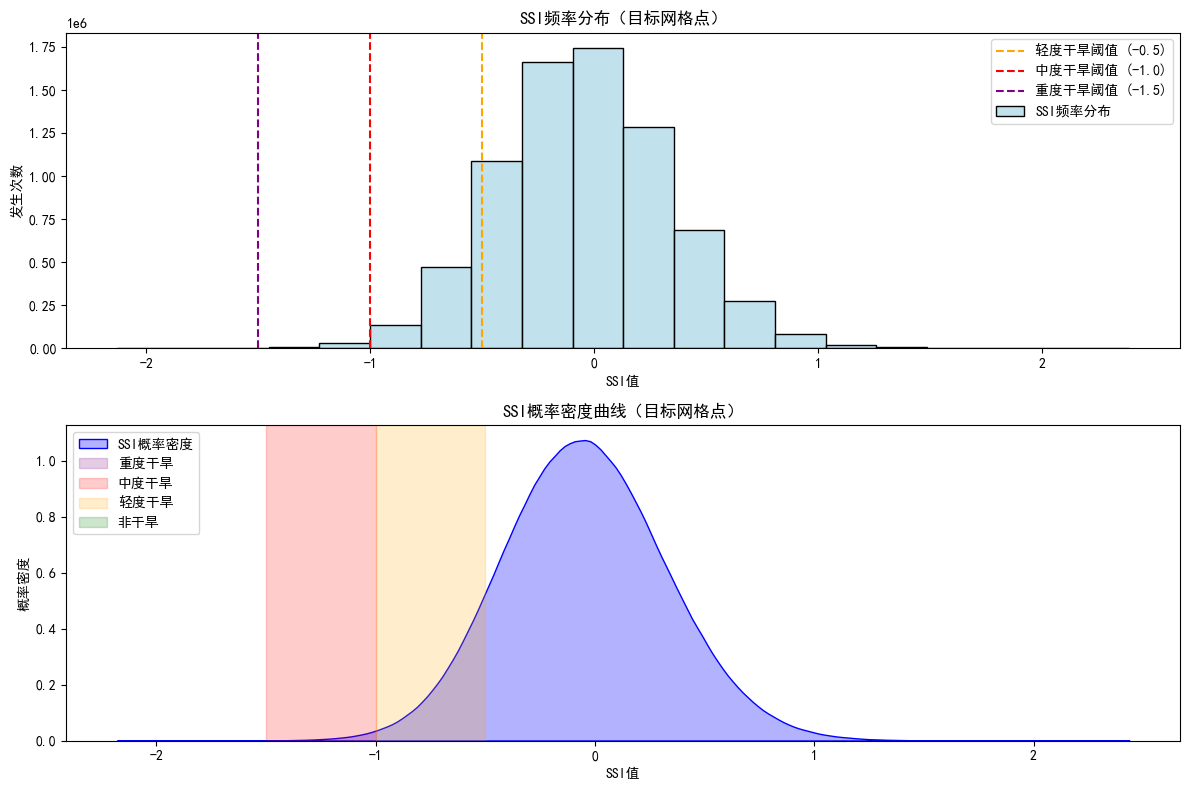

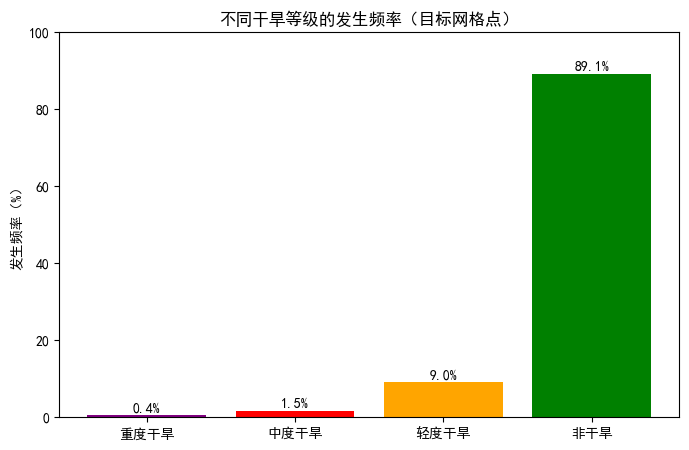

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# 指定默认字体
matplotlib.rcParams['font.family'] = 'SimHei' #或其他支持中文的字体
matplotlib.rcParams['axes.unicode_minus'] = False #解决负号'-'显示为方块的问题
# aa=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\resu\ssi_scale2_mai_Historical_median.nc").ssi
ssi_data = result_da.values  # 提取SSI数值
ssi_valid = ssi_data[~np.isnan(ssi_data)]  # 去除无效值

# 1. 频率分布直方图 + 概率密度曲线
plt.figure(figsize=(12, 8))

# 直方图（频率分布）
plt.subplot(2, 1, 1)
sns.histplot(ssi_valid, bins=20, kde=False, stat='count', 
             color='lightblue', edgecolor='black', label='SSI频率分布')
plt.axvline(x=-0.5, color='orange', linestyle='--', label='轻度干旱阈值 (-0.5)')
plt.axvline(x=-1.0, color='red', linestyle='--', label='中度干旱阈值 (-1.0)')
plt.axvline(x=-1.5, color='purple', linestyle='--', label='重度干旱阈值 (-1.5)')
plt.xlabel('SSI值')
plt.ylabel('发生次数')
plt.title('SSI频率分布（目标网格点）')
plt.legend()

# 概率密度曲线（核密度估计）
plt.subplot(2, 1, 2)
sns.kdeplot(ssi_valid, color='blue', fill=True, alpha=0.3, label='SSI概率密度')
# 标注干旱区间
plt.axvspan(-np.inf, -1.5, color='purple', alpha=0.2, label='重度干旱')
plt.axvspan(-1.5, -1.0, color='red', alpha=0.2, label='中度干旱')
plt.axvspan(-1.0, -0.5, color='orange', alpha=0.2, label='轻度干旱')
plt.axvspan(-0.5, np.inf, color='green', alpha=0.2, label='非干旱')
plt.xlabel('SSI值')
plt.ylabel('概率密度')
plt.title('SSI概率密度曲线（目标网格点）')
plt.legend()

plt.tight_layout()
plt.show()

# 2. 不同干旱等级的发生频率计算及可视化
# 统计各等级发生次数
total = len(ssi_valid)
severe = np.sum(ssi_valid <= -1)
moderate = np.sum((ssi_valid > -1) & (ssi_valid <= -0.8))
mild = np.sum((ssi_valid > -0.8) & (ssi_valid <= -0.5))
non_drought = total - severe - moderate - mild

# 计算频率（占比）
freq_severe = severe / total * 100
freq_moderate = moderate / total * 100
freq_mild = mild / total * 100
freq_non = non_drought / total * 100

# 柱状图展示
plt.figure(figsize=(8, 5))
bars = plt.bar(
    ['重度干旱', '中度干旱', '轻度干旱', '非干旱'],
    [freq_severe, freq_moderate, freq_mild, freq_non],
    color=['purple', 'red', 'orange', 'green']
)
# 标注频率值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')
plt.ylabel('发生频率（%）')
plt.title('不同干旱等级的发生频率（目标网格点）')
plt.ylim(0, 100)
plt.show()